## **Predicting Blood Pressure From Graphene Bioimpedence**

This notebook aims to predict blood pressure using bioimpedance measurements from graphene electronic tattoos.

For more detail and access to the data read this [article](https://physicsworld.com/a/graphene-tattoo-provides-cuffless-blood-pressure-monitoring/).

## **1. Data Exploration and Preprocessing**

### **1.1 Creating a combined dataset from the CSVs**

The goal of this section is to combine all of the CSVs into one pandas dataframe with the following schema:

***Subject, Day, SetupType, Setup, Trial, Time, Bioz, FinapresBP***

Each individual trial will be identified by the combination of the Subject, Day and Trial keys.

In [1]:
import pandas as pd
import os 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

>##### **Lets start by reading the data related to one patient and setup.**

In [2]:
# The path to the setup results
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0/subject1_day1/setup01_baseline"

csv_files_finapresBP = glob.glob(os.path.join(path, "*finapresBP.csv"))
csv_files_bioz = glob.glob(os.path.join(path, "*bioz.csv"))

# Combine both lists
csv_files = csv_files_finapresBP + csv_files_bioz

# A list to collect DataFrames
dfs = []

# Loop over the list of csv files 
for f in csv_files: 

    # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
    f = f.replace("\\", "/")

    # Extract the trial, setup and subject info from the file path
    trial_string = f.split("/")[-1]
    setup_string = f.split("/")[-2]
    subject_string = f.split("/")[-3]

    # Process the strings into keys
    trial = int(trial_string.split('_')[1].replace('trial', ''))
    setup_type = setup_string.split('_')[1]  # Include the type of experiment done
    setup = int(setup_string.split('_')[0].replace('setup', ''))

    # Day and subject should also be split so that subject 1 is properly accounted for
    # This should prevent data leakage across folds later on
    day = int(subject_string.split('_')[1].replace("day", ""))
    subject = int(subject_string.split('_')[0].replace("subject", ""))

    # Read the csv file and add the ids used to identify the experiment
    next_df = pd.read_csv(f)
    next_df['Subject'] = subject
    next_df['Day'] = day
    next_df['SetupType'] = setup_type
    next_df['Setup'] = setup
    next_df['Trial'] = trial

    dfs.append(next_df)

# Concatenate the dataframes into one
df = pd.concat(dfs, ignore_index=True)

df

time  FinapresBP  Subject  Day SetupType  Setup  Trial     BioZ1  \
0        2.000961   117.25990        1    1  baseline      1      1       NaN   
1        2.005961   116.50575        1    1  baseline      1      1       NaN   
2        2.010961   115.71514        1    1  baseline      1      1       NaN   
3        2.015961   114.89302        1    1  baseline      1      1       NaN   
4        2.020961   114.04378        1    1  baseline      1      1       NaN   
...           ...         ...      ...  ...       ...    ...    ...       ...   
250334  87.596021         NaN        1    1  baseline      1      2  35.90495   
250335  87.596821         NaN        1    1  baseline      1      2  36.05002   
250336  87.597621         NaN        1    1  baseline      1      2  36.19220   
250337  87.598421         NaN        1    1  baseline      1      2  36.33149   
250338  87.599221         NaN        1    1  baseline      1      2  36.46792   

           BioZ2    BioZ3    BioZ4  
0            NaN      NaN      NaN  
1            NaN      NaN      NaN  
2            NaN      NaN      NaN  
3            NaN      NaN      NaN  
4            NaN      NaN      NaN  
...          ...      ...      ...  
250334  12.90030  8.22138  5.59188  
250335  12.96404  8.24659  5.66730  
250336  13.02675  8.27244  5.74181  
250337  13.08843  8.29893  5.81538  
250338  13.14909  8.32605  5.88801  

[250339 rows x 11 columns]

> ##### **An overview of the current dataset.**

In [3]:
# Set the Seaborn Style
sns.set_style("whitegrid")

In [4]:
display(df)
df.info()
df.describe()

time  FinapresBP  Subject  Day SetupType  Setup  Trial     BioZ1  \
0        2.000961   117.25990        1    1  baseline      1      1       NaN   
1        2.005961   116.50575        1    1  baseline      1      1       NaN   
2        2.010961   115.71514        1    1  baseline      1      1       NaN   
3        2.015961   114.89302        1    1  baseline      1      1       NaN   
4        2.020961   114.04378        1    1  baseline      1      1       NaN   
...           ...         ...      ...  ...       ...    ...    ...       ...   
250334  87.596021         NaN        1    1  baseline      1      2  35.90495   
250335  87.596821         NaN        1    1  baseline      1      2  36.05002   
250336  87.597621         NaN        1    1  baseline      1      2  36.19220   
250337  87.598421         NaN        1    1  baseline      1      2  36.33149   
250338  87.599221         NaN        1    1  baseline      1      2  36.46792   

           BioZ2    BioZ3    BioZ4  
0            NaN      NaN      NaN  
1            NaN      NaN      NaN  
2            NaN      NaN      NaN  
3            NaN      NaN      NaN  
4            NaN      NaN      NaN  
...          ...      ...      ...  
250334  12.90030  8.22138  5.59188  
250335  12.96404  8.24659  5.66730  
250336  13.02675  8.27244  5.74181  
250337  13.08843  8.29893  5.81538  
250338  13.14909  8.32605  5.88801  

[250339 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250339 entries, 0 to 250338
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        250339 non-null  float64
 1   FinapresBP  33839 non-null   float64
 2   Subject     250339 non-null  int64  
 3   Day         250339 non-null  int64  
 4   SetupType   250339 non-null  object 
 5   Setup       250339 non-null  int64  
 6   Trial       250339 non-null  int64  
 7   BioZ1       216500 non-null  float64
 8   BioZ2       216500 non-null  float64
 9   BioZ3       216500 non-null  float64
 10  BioZ4       216500 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 21.0+ MB


time    FinapresBP   Subject       Day     Setup  \
count  250339.000000  33839.000000  250339.0  250339.0  250339.0   
mean       44.299563    100.468637       1.0       1.0       1.0   
std        24.921961     14.259206       0.0       0.0       0.0   
min         1.000021     70.307840       1.0       1.0       1.0   
25%        22.718821     88.941565       1.0       1.0       1.0   
50%        44.299923     98.811970       1.0       1.0       1.0   
75%        65.880421    111.115920       1.0       1.0       1.0   
max        87.599221    136.984660       1.0       1.0       1.0   

               Trial          BioZ1          BioZ2          BioZ3  \
count  250339.000000  216500.000000  216500.000000  216500.000000   
mean        1.499998      25.550801       9.075036      10.228314   
std         0.500001      42.981838      15.749782      15.668690   
min         1.000000     -84.635750     -31.683900     -40.261580   
25%         1.000000      -3.573203      -1.582795      -0.110363   
50%         1.000000      39.825125      14.179090      11.960885   
75%         2.000000      60.602902      21.819870      20.173572   
max         2.000000      94.314210      38.766850      62.628790   

               BioZ4  
count  216500.000000  
mean        3.341454  
std         5.928609  
min       -15.341980  
25%        -0.917353  
50%         4.429660  
75%         7.746480  
max        18.657800

Show the correlation matrix of each of the variables.

In [5]:
def plot_correlation_matrix(df, columns):
    correlation_matrix = df[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.show()

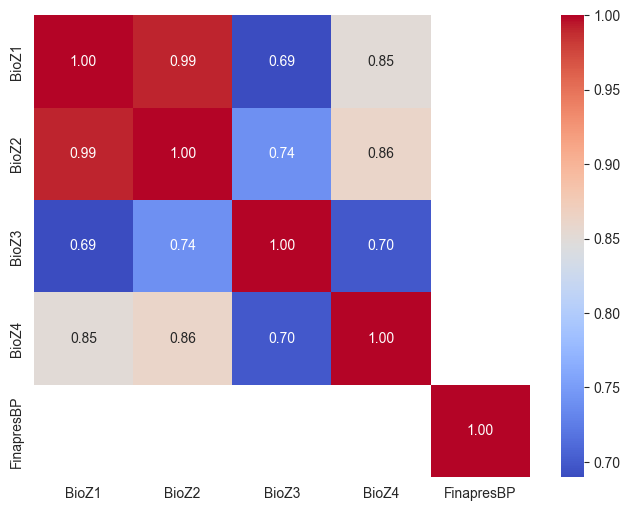

In [6]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_correlation_matrix(df, columns_to_plot)

There is no correlation between the BioZ measurements and FinapresBP because the time measurements do share overlapping timestamps (whenever one has values the other has NaNs).

In [7]:
display(df[df['FinapresBP'].notna()])
display(df[df['BioZ1'].notna()])

time  FinapresBP  Subject  Day SetupType  Setup  Trial  BioZ1  \
0       2.000961   117.25990        1    1  baseline      1      1    NaN   
1       2.005961   116.50575        1    1  baseline      1      1    NaN   
2       2.010961   115.71514        1    1  baseline      1      1    NaN   
3       2.015961   114.89302        1    1  baseline      1      1    NaN   
4       2.020961   114.04378        1    1  baseline      1      1    NaN   
...          ...         ...      ...  ...       ...    ...    ...    ...   
33834  86.574923   119.63236        1    1  baseline      1      2    NaN   
33835  86.579923   120.48830        1    1  baseline      1      2    NaN   
33836  86.584923   121.17915        1    1  baseline      1      2    NaN   
33837  86.589923   121.71462        1    1  baseline      1      2    NaN   
33838  86.594923   122.10559        1    1  baseline      1      2    NaN   

       BioZ2  BioZ3  BioZ4  
0        NaN    NaN    NaN  
1        NaN    NaN    NaN  
2        NaN    NaN    NaN  
3        NaN    NaN    NaN  
4        NaN    NaN    NaN  
...      ...    ...    ...  
33834    NaN    NaN    NaN  
33835    NaN    NaN    NaN  
33836    NaN    NaN    NaN  
33837    NaN    NaN    NaN  
33838    NaN    NaN    NaN  

[33839 rows x 11 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial     BioZ1  \
33839    1.000021         NaN        1    1  baseline      1      1  45.11402   
33840    1.000821         NaN        1    1  baseline      1      1  45.19330   
33841    1.001621         NaN        1    1  baseline      1      1  45.27085   
33842    1.002421         NaN        1    1  baseline      1      1  45.34667   
33843    1.003221         NaN        1    1  baseline      1      1  45.42077   
...           ...         ...      ...  ...       ...    ...    ...       ...   
250334  87.596021         NaN        1    1  baseline      1      2  35.90495   
250335  87.596821         NaN        1    1  baseline      1      2  36.05002   
250336  87.597621         NaN        1    1  baseline      1      2  36.19220   
250337  87.598421         NaN        1    1  baseline      1      2  36.33149   
250338  87.599221         NaN        1    1  baseline      1      2  36.46792   

           BioZ2     BioZ3    BioZ4  
33839   18.60437  20.92109  6.67912  
33840   18.60317  20.84464  6.61070  
33841   18.60096  20.76674  6.54201  
33842   18.59775  20.68740  6.47308  
33843   18.59353  20.60664  6.40395  
...          ...       ...      ...  
250334  12.90030   8.22138  5.59188  
250335  12.96404   8.24659  5.66730  
250336  13.02675   8.27244  5.74181  
250337  13.08843   8.29893  5.81538  
250338  13.14909   8.32605  5.88801  

[216500 rows x 11 columns]

>##### **I'll visualise one trial to get an understanding of the data.**

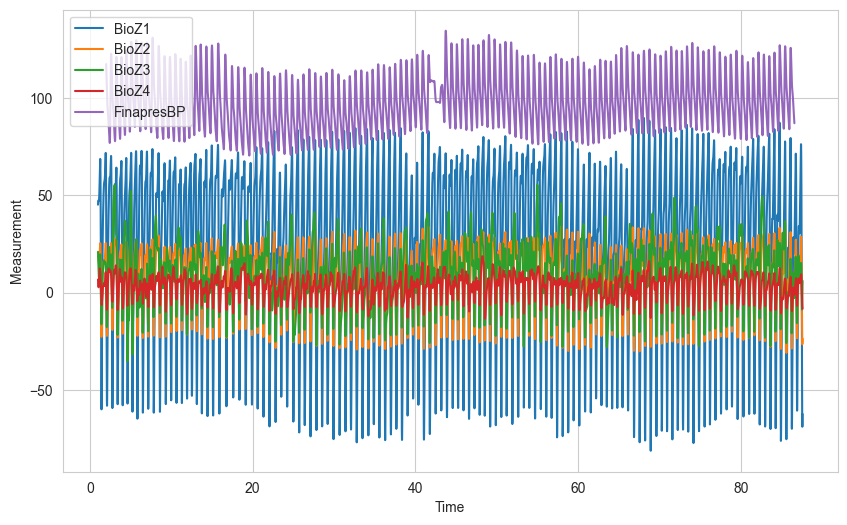

In [8]:
trial1_df = df[df['Trial'] == 1]
# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=trial1_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()

plt.show()

It's a bit cluttered. For more detail I'll limit it to a 5 second stretch

In [9]:
def plot_measurements(df, start_time, end_time):

    # Filter the DataFrame by time
    plot_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

    # Create the plot
    plt.figure(figsize=(10, 6))

    for column in columns_to_plot:
        sns.lineplot(data=plot_df, x='time', y=column, label=column)

    plt.xlabel('Time')
    plt.ylabel('Measurement')
    plt.legend()
    plt.show()

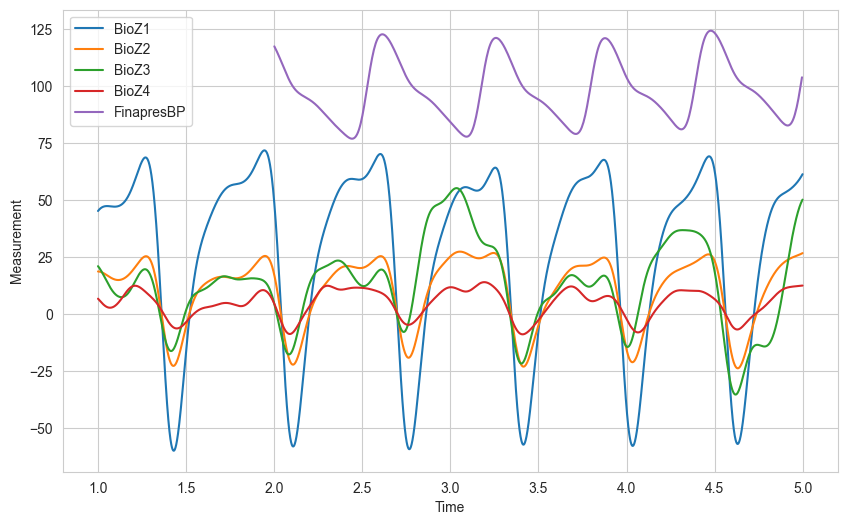

In [10]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(trial1_df, 0, 5)

We can see that the *FinapresBP* measurements start after the *BioZ* measurements.

Lets plot each Measurement directly against Blood Pressure.

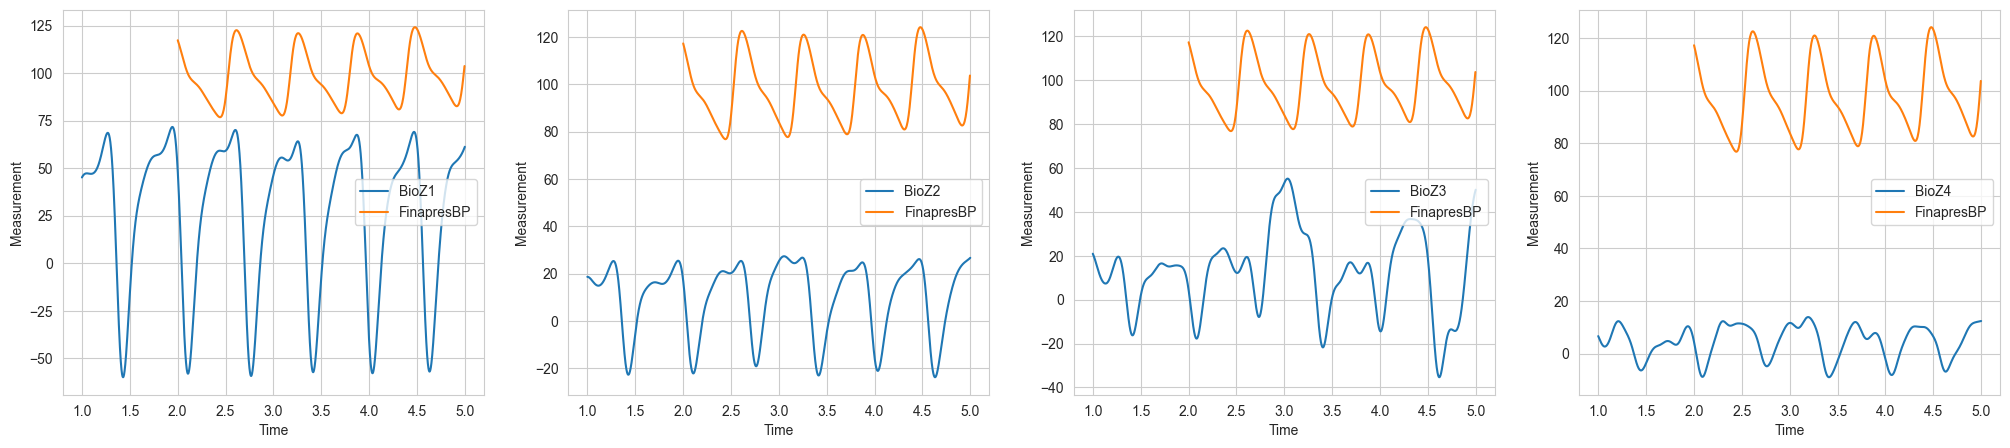

In [11]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(25, 5))

plot_df = trial1_df[(trial1_df['time'] >= 0) & (trial1_df['time'] <= 5)]

for ax, column in zip(axs, columns_to_plot):
    sns.lineplot(data=plot_df, x='time', y=column, label=column, ax=ax)
    sns.lineplot(data=plot_df, x='time', y='FinapresBP', label='FinapresBP', ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Measurement')
    ax.legend(loc='center right')

plt.show()

The two types of measurement also seem to be slightly out of phase, due to the sensor's different position on the arm.

### **1.2 Constuct a Common Time Axis**

I am going to repeat the approach from the starter notebook to create a shared time axis.

This will be shown using the first trial.

In [12]:
trial1_df = df[df['Trial']==1]
bioz_df = trial1_df.drop(columns='FinapresBP').dropna()
bp_df = trial1_df.drop(columns=['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']).dropna()
display(bioz_df)
display(bp_df)

time  Subject  Day SetupType  Setup  Trial     BioZ1     BioZ2  \
33839    1.000021        1    1  baseline      1      1  45.11402  18.60437   
33840    1.000821        1    1  baseline      1      1  45.19330  18.60317   
33841    1.001621        1    1  baseline      1      1  45.27085  18.60096   
33842    1.002421        1    1  baseline      1      1  45.34667  18.59775   
33843    1.003221        1    1  baseline      1      1  45.42077  18.59353   
...           ...      ...  ...       ...    ...    ...       ...       ...   
142084  87.596021        1    1  baseline      1      1 -63.81312 -24.29105   
142085  87.596821        1    1  baseline      1      1 -63.46248 -24.14836   
142086  87.597621        1    1  baseline      1      1 -63.10261 -24.00241   
142087  87.598421        1    1  baseline      1      1 -62.73376 -23.85328   
142088  87.599221        1    1  baseline      1      1 -62.35618 -23.70108   

           BioZ3    BioZ4  
33839   20.92109  6.67912  
33840   20.84464  6.61070  
33841   20.76674  6.54201  
33842   20.68740  6.47308  
33843   20.60664  6.40395  
...          ...      ...  
142084   4.84010 -8.15857  
142085   5.12880 -8.18565  
142086   5.41779 -8.21183  
142087   5.70698 -8.23710  
142088   5.99626 -8.26148  

[108250 rows x 10 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial
0       2.000961   117.25990        1    1  baseline      1      1
1       2.005961   116.50575        1    1  baseline      1      1
2       2.010961   115.71514        1    1  baseline      1      1
3       2.015961   114.89302        1    1  baseline      1      1
4       2.020961   114.04378        1    1  baseline      1      1
...          ...         ...      ...  ...       ...    ...    ...
16915  86.575961    88.07976        1    1  baseline      1      1
16916  86.580961    87.74439        1    1  baseline      1      1
16917  86.585961    87.43317        1    1  baseline      1      1
16918  86.590961    87.15423        1    1  baseline      1      1
16919  86.595961    86.91691        1    1  baseline      1      1

[16920 rows x 7 columns]

> ##### **Interpolate the data onto a common time axis.**

In [13]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [14]:
start_time = max(min(bioz_df['time']), min(bp_df['time']))
end_time = min(max(bioz_df['time']), max(bp_df['time']))
common_time = np.linspace(start_time, end_time, num=len(bp_df))  # Instead of 1000 I will match the sampling rate of the Finapres data

finapres_interpolator = interp1d(bp_df['time'], bp_df['FinapresBP'], bounds_error=False, fill_value="extrapolate")
bioz1_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ1'], bounds_error=False, fill_value="extrapolate")
bioz2_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ2'], bounds_error=False, fill_value="extrapolate")
bioz3_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ3'], bounds_error=False, fill_value="extrapolate")
bioz4_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ4'], bounds_error=False, fill_value="extrapolate")

finapres_common = finapres_interpolator(common_time)
bioz1_common = bioz1_interpolator(common_time)
bioz2_common = bioz2_interpolator(common_time)
bioz3_common = bioz3_interpolator(common_time)
bioz4_common = bioz4_interpolator(common_time)

Create a dataframe with the new time axis.

In [15]:
bp_df['BioZ1'] = bioz1_common
bp_df['BioZ2'] = bioz2_common
bp_df['BioZ3'] = bioz3_common
bp_df['BioZ4'] = bioz4_common

bp_df

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
0       2.000961   117.25990        1    1  baseline      1      1  48.332439   
1       2.005961   116.50575        1    1  baseline      1      1  43.384880   
2       2.010961   115.71514        1    1  baseline      1      1  37.969078   
3       2.015961   114.89302        1    1  baseline      1      1  32.123190   
4       2.020961   114.04378        1    1  baseline      1      1  25.896649   
...          ...         ...      ...  ...       ...    ...    ...        ...   
16915  86.575961    88.07976        1    1  baseline      1      1  20.277790   
16916  86.580961    87.74439        1    1  baseline      1      1  20.673994   
16917  86.585961    87.43317        1    1  baseline      1      1  21.228864   
16918  86.590961    87.15423        1    1  baseline      1      1  21.935641   
16919  86.595961    86.91691        1    1  baseline      1      1  22.785568   

           BioZ2     BioZ3     BioZ4  
0      16.943260  4.337878  4.415633  
1      15.087782  2.756093  3.484722  
2      13.056467  1.085794  2.508537  
3      10.864834 -0.655107  1.496772  
4       8.532647 -2.445484  0.460766  
...          ...       ...       ...  
16915   4.039298 -2.759994 -1.125975  
16916   4.207431 -2.845577 -1.102570  
16917   4.447118 -2.823403 -1.051217  
16918   4.756011 -2.693616 -0.973220  
16919   5.130968 -2.457402 -0.870083  

[16920 rows x 11 columns]

Now that they share an axis the correlation between the ***BioZ*** and ***FinapresBP*** measurements can be examined.

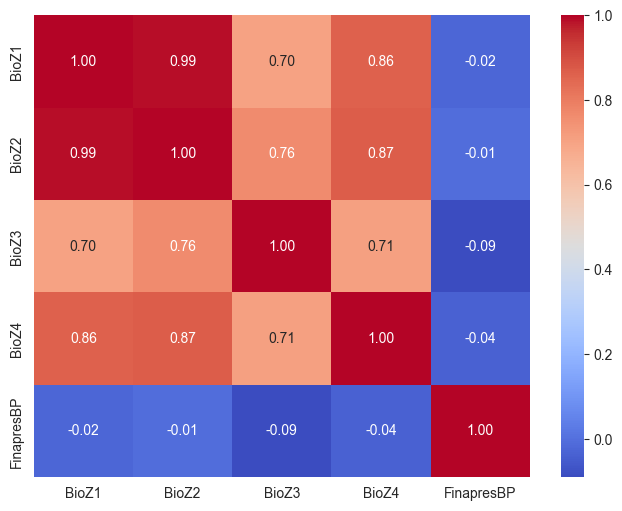

In [16]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_correlation_matrix(bp_df, columns_to_plot)

The correlation is quite low, this is most likely because the two measurements are still out of phase.

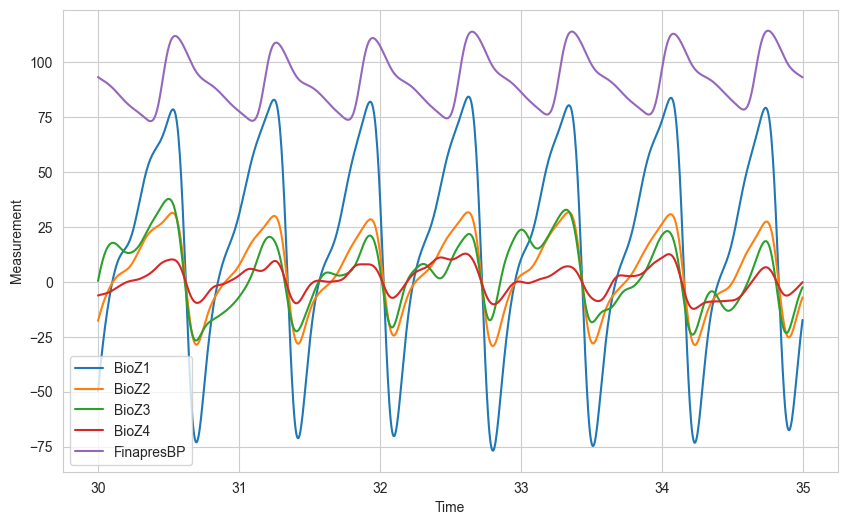

In [17]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_measurements(bp_df, 30, 35)

Lets try a regression model.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [19]:
features = bp_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = bp_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 5.6739049845153655
Root Mean Squared Error: 8.279149191716565
R^2 Score: 0.6438913430721231


I'll try to improve this by making them in-phase.

> ##### **Use Cross-Correlation to align the series.**

As different, subjects might have different gaps between the measurements, I'll use cross-correlation to align the different measurements instead of a hard-coded shift.

Cross correlation compares each series at every time lag, essentially finding out how a series should be shifted to maximise correlation.

In [20]:
from scipy.signal import correlate

In [21]:
def cross_correlate(series1, series2, plot=False):

    # Normalise the series, as they each have different scales
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    lags = np.arange(-len(series1) + 1, len(series1))
    cross_correlation = correlate(series1, series2, mode='full')

    # Find the lag with the maximum correlation
    lag_max = lags[cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, cross_correlation)
        plt.title('Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

Invert the BioZ measurement to find the maximum correlation with Blood Pressure.

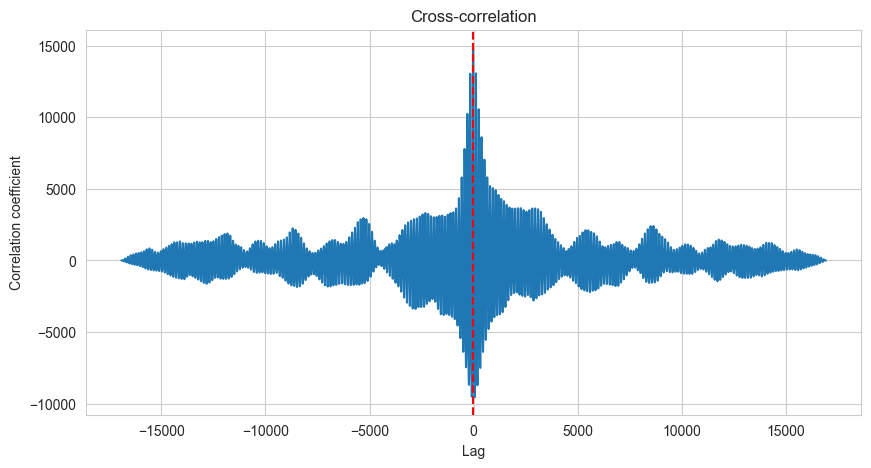

The maximum correlation is at lag -30, which equates to -0.1500 seconds.


-30

In [22]:
cross_correlate(bp_df['FinapresBP'], -1 * bp_df['BioZ1'], plot=True)

As the most highly correlated lag is negative this tells us that the ***BioZ1*** measurements occur 0.15 seconds after the ***FinpresBP*** measurements (Correlation is maximised when ***BioZ1*** is shifted back in time).

This goes against the initial hypothesis in the [Starter Notebook](./Starter_Notebook.ipynb) that the blood pressure measurements occur after the BioZ measurements, due to the sensor's more distant position from the heart, but I'll stick with it for now.

We can also check if the BioZ measurements are out of phase with each other.

In [23]:
print("Cross-correlation between BioZ1 and BioZ2: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ2'])))
print("Cross-correlation between BioZ1 and BioZ3: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ3'])))
print("Cross-correlation between BioZ1 and BioZ4: " + str(cross_correlate(bp_df['BioZ1'], bp_df['BioZ4'])))

Cross-correlation between BioZ1 and BioZ2: 0
Cross-correlation between BioZ1 and BioZ3: 4
Cross-correlation between BioZ1 and BioZ4: 1


BioZ 1 and 2 also occur slightly after 3 and 4.

I'll align all 4 BioZ metrics to FinapresBP in order to maximise the correlation and hopefully improve regression performance.

In [24]:
aligned_df = bp_df.copy()  # Copy to avoid shifting the original df

# Shift the values based on their lag to FinapresBP
aligned_df['BioZ1'] = aligned_df['BioZ1'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ1']))
aligned_df['BioZ2'] = aligned_df['BioZ2'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ2']))
aligned_df['BioZ3'] = aligned_df['BioZ3'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ3']))
aligned_df['BioZ4'] = aligned_df['BioZ4'].shift(cross_correlate(aligned_df['FinapresBP'], -1 * aligned_df['BioZ4']))

In [25]:
display(aligned_df)

# Drop the rows with NaNs at the end caused by the shift
aligned_df = aligned_df.dropna()
display(aligned_df)

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
0       2.000961   117.25990        1    1  baseline      1      1 -38.533330   
1       2.005961   116.50575        1    1  baseline      1      1 -34.658723   
2       2.010961   115.71514        1    1  baseline      1      1 -30.661121   
3       2.015961   114.89302        1    1  baseline      1      1 -26.593230   
4       2.020961   114.04378        1    1  baseline      1      1 -22.502636   
...          ...         ...      ...  ...       ...    ...    ...        ...   
16915  86.575961    88.07976        1    1  baseline      1      1        NaN   
16916  86.580961    87.74439        1    1  baseline      1      1        NaN   
16917  86.585961    87.43317        1    1  baseline      1      1        NaN   
16918  86.590961    87.15423        1    1  baseline      1      1        NaN   
16919  86.595961    86.91691        1    1  baseline      1      1        NaN   

           BioZ2      BioZ3     BioZ4  
0     -14.585256 -10.377965 -3.523223  
1     -13.120392  -8.771153 -2.842555  
2     -11.614628  -7.086624 -2.168193  
3     -10.087884  -5.347416 -1.504652  
4      -8.558192  -3.576163 -0.854642  
...          ...        ...       ...  
16915        NaN        NaN       NaN  
16916        NaN        NaN       NaN  
16917        NaN        NaN       NaN  
16918        NaN        NaN       NaN  
16919        NaN        NaN       NaN  

[16920 rows x 11 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
0       2.000961   117.25990        1    1  baseline      1      1 -38.533330   
1       2.005961   116.50575        1    1  baseline      1      1 -34.658723   
2       2.010961   115.71514        1    1  baseline      1      1 -30.661121   
3       2.015961   114.89302        1    1  baseline      1      1 -26.593230   
4       2.020961   114.04378        1    1  baseline      1      1 -22.502636   
...          ...         ...      ...  ...       ...    ...    ...        ...   
16885  86.425961    99.39077        1    1  baseline      1      1  20.277790   
16886  86.430961    99.04503        1    1  baseline      1      1  20.673994   
16887  86.435961    98.69012        1    1  baseline      1      1  21.228864   
16888  86.440961    98.32703        1    1  baseline      1      1  21.935641   
16889  86.445961    97.95688        1    1  baseline      1      1  22.785568   

           BioZ2      BioZ3     BioZ4  
0     -14.585256 -10.377965 -3.523223  
1     -13.120392  -8.771153 -2.842555  
2     -11.614628  -7.086624 -2.168193  
3     -10.087884  -5.347416 -1.504652  
4      -8.558192  -3.576163 -0.854642  
...          ...        ...       ...  
16885   4.039298  -0.818189 -1.120395  
16886   4.207431  -1.390865 -1.125975  
16887   4.447118  -1.878121 -1.102570  
16888   4.756011  -2.272390 -1.051217  
16889   5.130968  -2.567816 -0.973220  

[16890 rows x 11 columns]

The last 30 rows are dropped due to the shift of the BioZ measurements.

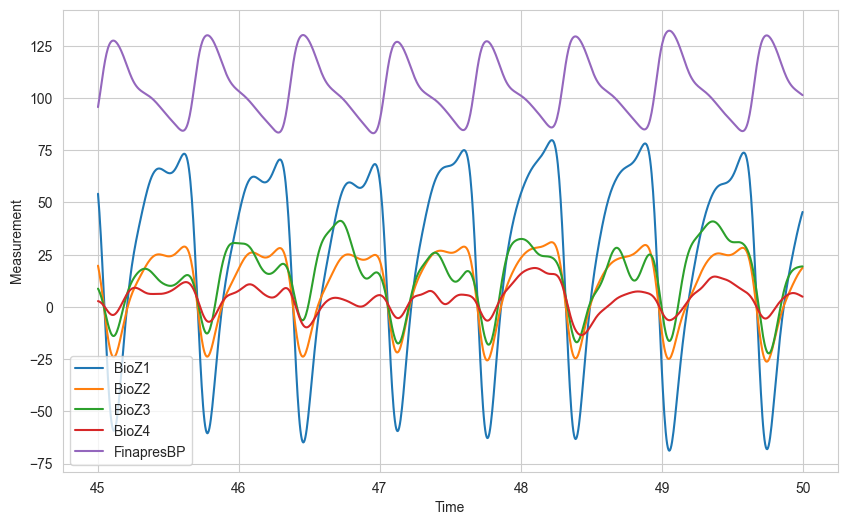

In [26]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(aligned_df, 45, 50)

The series now look visually aligned, lets see how the correlation has changed.

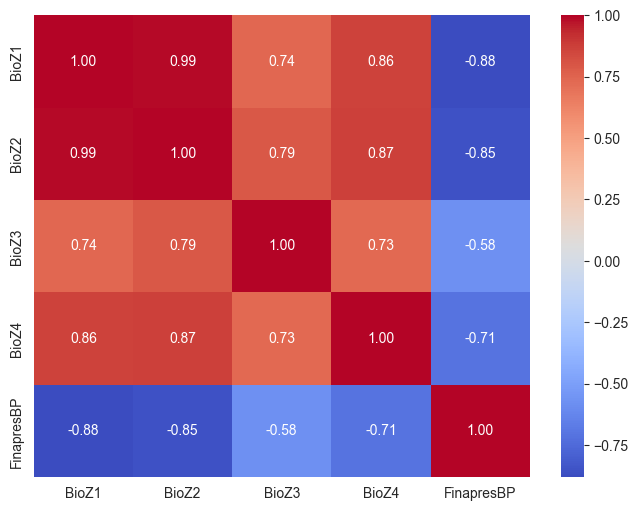

In [27]:
plot_correlation_matrix(aligned_df, columns_to_plot)

That seemed to work, the strength of the negative correlation between BioZ and BP has greatly increased.

Lets try the regression again.

In [28]:
features = aligned_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = aligned_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 3.566519977915927
Root Mean Squared Error: 4.834837954319594
R^2 Score: 0.8797910630945056


Aligning the series has greatly improved the regression performance.

> ##### **Test the assumption that *FinaPresBP* comes after *BioZ*.**

Before I perform the interpolation and cross-correlation on every trial, I want to make sure that the correct heartbeats have been aligned.

If ***FinapresBP*** does occur after ***BioZ*** the cross-correlation can be modified to only look at positive lags.

In [29]:
def cross_correlate_positive_only(series1, series2, plot=False):

    # Normalise the series, as they each have different scales
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    cross_correlation = correlate(series1, series2, mode='full')

    # Only look at the positive half of the cross correlation
    positive_cross_correlation = cross_correlation[len(cross_correlation)//2:]

    # Adjust the lags array to be the size of the positive half
    lags = np.arange(0, len(series1))

    # Find the positive lag with the maximum correlation
    lag_max = lags[positive_cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, positive_cross_correlation)
        plt.title('Positive Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

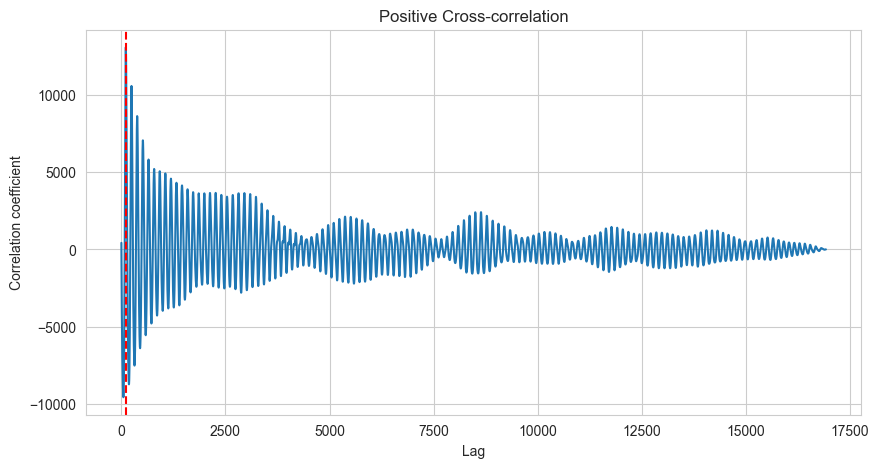

The maximum correlation is at lag 107, which equates to 0.5350 seconds.


107

In [30]:
cross_correlate_positive_only(bp_df['FinapresBP'], -1 * bp_df['BioZ1'], plot=True)

According to this approach, the ***FinapresBP*** measurements occur 0.5350 seconds after the ***BioZ*** measurements.

The BioZ measurements can be shifted back to account for this.

In [31]:
aligned_df = bp_df.copy()

# Shift the values based on their lag to FinapresBP
aligned_df['BioZ1'] = aligned_df['BioZ1'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ1']))
aligned_df['BioZ2'] = aligned_df['BioZ2'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ2']))
aligned_df['BioZ3'] = aligned_df['BioZ3'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ3']))
aligned_df['BioZ4'] = aligned_df['BioZ4'].shift(cross_correlate_positive_only(aligned_df['FinapresBP'], -1 * aligned_df['BioZ4']))

In [32]:
display(aligned_df)

# Drop the rows with NaNs at the end caused by the shift
aligned_df = aligned_df.dropna()
display(aligned_df)

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
0       2.000961   117.25990        1    1  baseline      1      1        NaN   
1       2.005961   116.50575        1    1  baseline      1      1        NaN   
2       2.010961   115.71514        1    1  baseline      1      1        NaN   
3       2.015961   114.89302        1    1  baseline      1      1        NaN   
4       2.020961   114.04378        1    1  baseline      1      1        NaN   
...          ...         ...      ...  ...       ...    ...    ...        ...   
16915  86.575961    88.07976        1    1  baseline      1      1  56.521973   
16916  86.580961    87.74439        1    1  baseline      1      1  58.185035   
16917  86.585961    87.43317        1    1  baseline      1      1  59.849865   
16918  86.590961    87.15423        1    1  baseline      1      1  61.516974   
16919  86.595961    86.91691        1    1  baseline      1      1  63.185431   

           BioZ2     BioZ3     BioZ4  
0            NaN       NaN       NaN  
1            NaN       NaN       NaN  
2            NaN       NaN       NaN  
3            NaN       NaN       NaN  
4            NaN       NaN       NaN  
...          ...       ...       ...  
16915  21.938780  6.793856  4.570112  
16916  22.680968  7.547988  4.617755  
16917  23.416500  8.308917  4.667222  
16918  24.144429  9.071360  4.724163  
16919  24.863309  9.830272  4.793784  

[16920 rows x 11 columns]

time  FinapresBP  Subject  Day SetupType  Setup  Trial      BioZ1  \
111     2.555961   112.20797        1    1  baseline      1      1  25.896649   
112     2.560961   114.09118        1    1  baseline      1      1  19.354285   
113     2.565961   115.75133        1    1  baseline      1      1  12.571705   
114     2.570961   117.19370        1    1  baseline      1      1   5.633771   
115     2.575961   118.49058        1    1  baseline      1      1  -1.366571   
...          ...         ...      ...  ...       ...    ...    ...        ...   
16915  86.575961    88.07976        1    1  baseline      1      1  56.521973   
16916  86.580961    87.74439        1    1  baseline      1      1  58.185035   
16917  86.585961    87.43317        1    1  baseline      1      1  59.849865   
16918  86.590961    87.15423        1    1  baseline      1      1  61.516974   
16919  86.595961    86.91691        1    1  baseline      1      1  63.185431   

           BioZ2     BioZ3     BioZ4  
111     8.532647  4.337878  1.496772  
112     6.085352  2.756093  0.460766  
113     3.552295  1.085794 -0.586344  
114     0.966089 -0.655107 -1.630163  
115    -1.637821 -2.445484 -2.655336  
...          ...       ...       ...  
16915  21.938780  6.793856  4.570112  
16916  22.680968  7.547988  4.617755  
16917  23.416500  8.308917  4.667222  
16918  24.144429  9.071360  4.724163  
16919  24.863309  9.830272  4.793784  

[16809 rows x 11 columns]

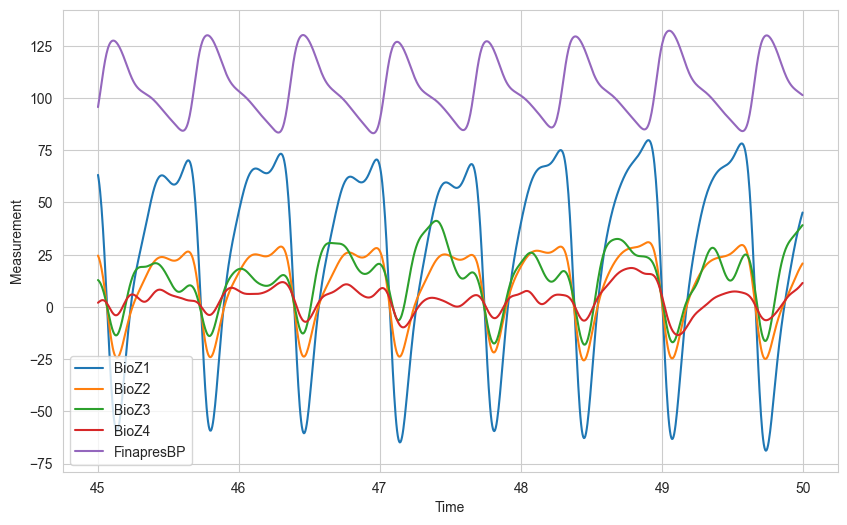

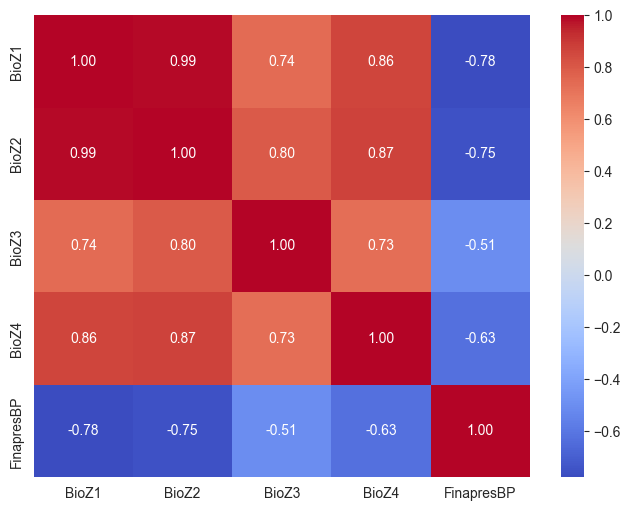

In [33]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

plot_measurements(aligned_df, 45, 50)

plot_correlation_matrix(aligned_df, columns_to_plot)

Once, again, the spectra are visually aligned and the correlations have increased.

However the correlations are less significant, lets look at how the regression model performs.

In [34]:
features = aligned_df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']].values
target = aligned_df['FinapresBP'].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1234)

model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 5.139353640124925
Root Mean Squared Error: 8.017656650317205
R^2 Score: 0.6725722187618131


This is quite a bit worse.

Based on the lower correlation and worse model performance, I am going to stick with the first approach for now and follow the assumption that blood pressure measurements occur first.

### **1.2 Now I'll repeat this with all of the CSVs**

> ##### **Load and Interpolate the ***BioZ*** and ***Finapres*** data from every trial.**

Trying to perform interpolation on the fully loaded dataset has too large of a memory footprint, as a result it is performed on each trial as it gets imported.

In [35]:
def interpolate_trial(bioz_df, bp_df):

    start_time = max(min(bioz_df['time']), min(bp_df['time']))
    end_time = min(max(bioz_df['time']), max(bp_df['time']))
    common_time = np.linspace(start_time, end_time, num=len(bp_df))  # Instead of 1000 I will match the sampling rate of the Finapres data

    #finapres_interpolator = interp1d(bp_df['time'], bp_df['FinapresBP'], bounds_error=False, fill_value="extrapolate")  # Not needed as this axis is left alone
    bioz1_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ1'], bounds_error=False, fill_value="extrapolate")
    bioz2_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ2'], bounds_error=False, fill_value="extrapolate")
    bioz3_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ3'], bounds_error=False, fill_value="extrapolate")
    bioz4_interpolator = interp1d(bioz_df['time'], bioz_df['BioZ4'], bounds_error=False, fill_value="extrapolate")

    # finapres_common = finapres_interpolator(common_time)
    bioz1_common = bioz1_interpolator(common_time)
    bioz2_common = bioz2_interpolator(common_time)
    bioz3_common = bioz3_interpolator(common_time)
    bioz4_common = bioz4_interpolator(common_time)

    bp_df['BioZ1'] = bioz1_common
    bp_df['BioZ2'] = bioz2_common
    bp_df['BioZ3'] = bioz3_common
    bp_df['BioZ4'] = bioz4_common

    return bp_df

In [36]:
dfs = []

# Set this to the to the root folder of the data
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0"

# Get all of the subject folders
subject_folders = glob.glob(os.path.join(path, "*" + os.sep))  # os.sep ensures that only directories are matched

# Iterate over each subject folder and examine each setup folder
for subject_folder in subject_folders:
    setup_folders = glob.glob(os.path.join(subject_folder, "*" + os.sep))

    # Iterate over each setup folder adding the CSVs within
    for setup_folder in setup_folders:
        trial_files = glob.glob(os.path.join(setup_folder, "*.csv"))

        # Create a dictionary mapping trials to their files
        trial_dict = {}
        for f in trial_files:
            f = f.replace("\\", "/")
            trial = f.split("/")[-1].split('_')[1] # Extract the trial name
            if trial in trial_dict:
                trial_dict[trial].append(f)
            else:
                trial_dict[trial] = [f]

        # Process each trial
        for trial, files in trial_dict.items():

            # Get the BioZ and BP measurements
            bioz_file = next((f for f in files if 'bioz.csv' in f), None)
            bp_file = next((f for f in files if 'finapresBP.csv' in f), None)

            # Extract the trial, setup and subject info from the file path
            bioz_file = bioz_file.replace("\\", "/")
            trial_string = bioz_file.split("/")[-1]
            setup_string = bioz_file.split("/")[-2]
            subject_string = bioz_file.split("/")[-3]

            # Process the strings into keys
            trial = int(trial_string.split('_')[1].replace('trial', ''))
            setup_type = setup_string.split('_')[1]  # Include the type of experiment done
            setup = int(setup_string.split('_')[0].replace('setup', ''))

            # Day and subject should also be split so that subject 1 is properly accounted for
            # This should prevent data leakage across folds later on
            day = int(subject_string.split('_')[1].replace("day", ""))
            subject = int(subject_string.split('_')[0].replace("subject", ""))
            
            # Read CSVs and add trial identifiers
            bioz_df = pd.read_csv(bioz_file)
            bp_df = pd.read_csv(bp_file)

            # Add identifiers to DataFrames
            for df in (bioz_df, bp_df):
                df['Subject'] = subject
                df['Day'] = day
                df['SetupType'] = setup_type
                df['Setup'] = setup
                df['Trial'] = trial

            # Subject 7 has no BioZ4 measurements so I'll create the column
            if 'BioZ4' not in bioz_df.columns:
                bioz_df['BioZ4'] = np.nan
            
            # Interpolate and merge bioz into bp dataframe for the trial
            merged_df = interpolate_trial(bioz_df, bp_df)
            dfs.append(merged_df)
                       
df = pd.concat(dfs, ignore_index=True)

Add a bit more structure to the dataset, ordering columns by granularity.

In [37]:
df = df[['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'time', 'BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']]
display(df)
df.info()
df.describe()
df.isna().sum()
# df.to_csv("../../data/interpolated_trials.csv", index=False)

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961  48.332439   
1              1    1  baseline      1      1    2.005961  43.384880   
2              1    1  baseline      1      1    2.010961  37.969078   
3              1    1  baseline      1      1    2.015961  32.123190   
4              1    1  baseline      1      1    2.020961  25.896649   
...          ...  ...       ...    ...    ...         ...        ...   
4460467        7    1   cycling      1      3  188.974952 -12.991598   
4460468        7    1   cycling      1      3  188.979952 -11.185842   
4460469        7    1   cycling      1      3  188.984952  -9.428160   
4460470        7    1   cycling      1      3  188.989952  -7.727173   
4460471        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3     BioZ4  FinapresBP  
0        16.943260   4.337878  4.415633   117.25990  
1        15.087782   2.756093  3.484722   116.50575  
2        13.056467   1.085794  2.508537   115.71514  
3        10.864834  -0.655107  1.496772   114.89302  
4         8.532647  -2.445484  0.460766   114.04378  
...            ...        ...       ...         ...  
4460467  -1.507162 -19.132283       NaN    67.67920  
4460468  -1.269116 -18.493100       NaN    67.50756  
4460469  -1.026987 -17.864842       NaN    67.33915  
4460470  -0.781154 -17.252701       NaN    67.17298  
4460471  -0.531917 -16.661449       NaN    67.00795  

[4460472 rows x 11 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460472 entries, 0 to 4460471
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Subject     int64  
 1   Day         int64  
 2   SetupType   object 
 3   Setup       int64  
 4   Trial       int64  
 5   time        float64
 6   BioZ1       float64
 7   BioZ2       float64
 8   BioZ3       float64
 9   BioZ4       float64
 10  FinapresBP  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 374.3+ MB


Subject            0
Day                0
SetupType          0
Setup              0
Trial              0
time               0
BioZ1              0
BioZ2              0
BioZ3              0
BioZ4         112197
FinapresBP         0
dtype: int64

The NaNs in BioZ4 are caused by subject 7. To avoid issues when aligning, for now I am going to set subject 7's BioZ4 to equal BioZ3 as these two metrics are related.

In [38]:
df.loc[df['Subject'] == 7, 'BioZ4'] = df['BioZ3']

Each unique trial is identified by the combination of the Subject, Day and Trial keys (This is because subject 1's trial ids reset to 1 on day 4).

We can see that 260 unique trials have taken place.

In [39]:
len(df[['Subject', 'Day', 'Trial']].drop_duplicates())

260

In [40]:
df.groupby(['Subject', 'Day'])['Trial'].nunique()

Subject  Day
1        1      46
         4      14
2        1      41
3        1      40
4        1      42
5        1      38
6        1      36
7        1       3
Name: Trial, dtype: int64

The number of trials of each type.

In [41]:
unique_trials = df.groupby(['SetupType', 'Subject', 'Day', 'Trial']).size().reset_index(name='Counts')

# Now, count the unique trials for each 'SetupType'
trial_counts = unique_trials.groupby('SetupType').size()
print(trial_counts)

SetupType
baseline     16
cycling       3
hgcp        214
rest          1
valsalva     26
dtype: int64


Lets inspect the full dataset by plotting unique trials and the correlation matrix.

All of the visualised trials can be seen in the [Plotting_All_Trials](./Plotting_All_Trials.ipynb) notebook.

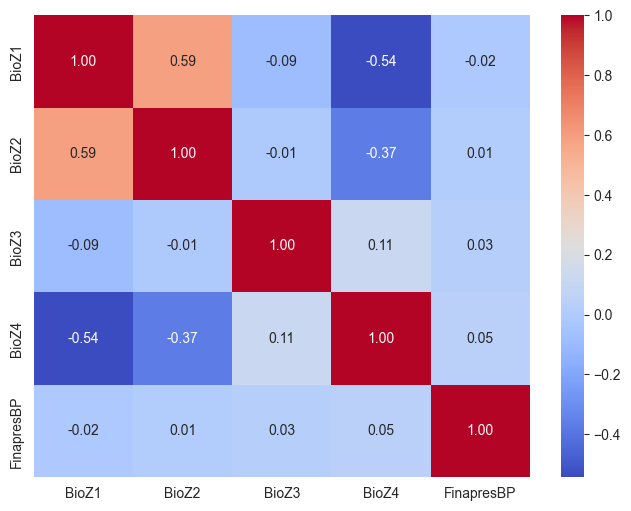

In [42]:
plot_correlation_matrix(df, columns_to_plot)

The low correlation and manual inspection indicates that the lack of alignment is common across the trials.

For comparison I'll perform a regression on a subset of the data.

At the currrent level of granularity there is too much data to train the model on without crashing.

To alleviate this I will downsample the data lowering the time resolution.

Currently the data is sampled at 200 Hz which is 1 sample every 5 milliseconds.

In [43]:
df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961  48.332439   
1              1    1  baseline      1      1    2.005961  43.384880   
2              1    1  baseline      1      1    2.010961  37.969078   
3              1    1  baseline      1      1    2.015961  32.123190   
4              1    1  baseline      1      1    2.020961  25.896649   
...          ...  ...       ...    ...    ...         ...        ...   
4460467        7    1   cycling      1      3  188.974952 -12.991598   
4460468        7    1   cycling      1      3  188.979952 -11.185842   
4460469        7    1   cycling      1      3  188.984952  -9.428160   
4460470        7    1   cycling      1      3  188.989952  -7.727173   
4460471        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  
0        16.943260   4.337878   4.415633   117.25990  
1        15.087782   2.756093   3.484722   116.50575  
2        13.056467   1.085794   2.508537   115.71514  
3        10.864834  -0.655107   1.496772   114.89302  
4         8.532647  -2.445484   0.460766   114.04378  
...            ...        ...        ...         ...  
4460467  -1.507162 -19.132283 -19.132283    67.67920  
4460468  -1.269116 -18.493100 -18.493100    67.50756  
4460469  -1.026987 -17.864842 -17.864842    67.33915  
4460470  -0.781154 -17.252701 -17.252701    67.17298  
4460471  -0.531917 -16.661449 -16.661449    67.00795  

[4460472 rows x 11 columns]

In [44]:
def resample_group(group, granularity='50ms'):

    resampled_group = group.copy()
    
    # Convert the time column to timedelta and set as index
    resampled_group['time'] = pd.to_timedelta(resampled_group['time'], 's')
    resampled_group = resampled_group.set_index('time')

    # Resample
    resampled_group = resampled_group.resample(granularity).mean()
    resampled_group = resampled_group.reset_index()
    
    return resampled_group

grouped_trials = df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)  # I'm not sure why this gets added
resampled_df

Subject  Day SetupType  Setup  Trial                      time  \
0             1    1  baseline      1      1 0 days 00:00:02.000961333   
1             1    1  baseline      1      1 0 days 00:00:02.050961333   
2             1    1  baseline      1      1 0 days 00:00:02.100961333   
3             1    1  baseline      1      1 0 days 00:00:02.150961333   
4             1    1  baseline      1      1 0 days 00:00:02.200961333   
...         ...  ...       ...    ...    ...                       ...   
446059        7    1   cycling      1      3    0 days 00:03:08.754952   
446060        7    1   cycling      1      3    0 days 00:03:08.804952   
446061        7    1   cycling      1      3    0 days 00:03:08.854952   
446062        7    1   cycling      1      3    0 days 00:03:08.904952   
446063        7    1   cycling      1      3    0 days 00:03:08.954952   

            BioZ1      BioZ2      BioZ3      BioZ4  FinapresBP  
0       21.556915   6.922896  -3.386628  -0.073681  113.520806  
1      -39.157956 -15.519125 -16.243995  -7.756720  104.610824  
2      -52.898600 -20.144582 -10.678291  -6.272398   98.157442  
3      -20.598913  -7.873248   5.571342   0.042631   95.127747  
4       13.507497   4.512397  16.603168   6.070578   92.523687  
...           ...        ...        ...        ...         ...  
446059 -32.902071  -4.780745 -18.104029 -18.104029   79.232191  
446060 -37.933496  -5.078346 -23.184047 -23.184047   75.247921  
446061 -39.708873  -4.805144 -25.869283 -25.869283   72.009278  
446062 -29.890967  -3.448730 -24.425531 -24.425531   69.537803  
446063 -13.114719  -1.492005 -19.149537 -19.149537   67.690388  

[446064 rows x 11 columns]

In [45]:
resampled_df

Subject  Day SetupType  Setup  Trial                      time  \
0             1    1  baseline      1      1 0 days 00:00:02.000961333   
1             1    1  baseline      1      1 0 days 00:00:02.050961333   
2             1    1  baseline      1      1 0 days 00:00:02.100961333   
3             1    1  baseline      1      1 0 days 00:00:02.150961333   
4             1    1  baseline      1      1 0 days 00:00:02.200961333   
...         ...  ...       ...    ...    ...                       ...   
446059        7    1   cycling      1      3    0 days 00:03:08.754952   
446060        7    1   cycling      1      3    0 days 00:03:08.804952   
446061        7    1   cycling      1      3    0 days 00:03:08.854952   
446062        7    1   cycling      1      3    0 days 00:03:08.904952   
446063        7    1   cycling      1      3    0 days 00:03:08.954952   

            BioZ1      BioZ2      BioZ3      BioZ4  FinapresBP  
0       21.556915   6.922896  -3.386628  -0.073681  113.520806  
1      -39.157956 -15.519125 -16.243995  -7.756720  104.610824  
2      -52.898600 -20.144582 -10.678291  -6.272398   98.157442  
3      -20.598913  -7.873248   5.571342   0.042631   95.127747  
4       13.507497   4.512397  16.603168   6.070578   92.523687  
...           ...        ...        ...        ...         ...  
446059 -32.902071  -4.780745 -18.104029 -18.104029   79.232191  
446060 -37.933496  -5.078346 -23.184047 -23.184047   75.247921  
446061 -39.708873  -4.805144 -25.869283 -25.869283   72.009278  
446062 -29.890967  -3.448730 -24.425531 -24.425531   69.537803  
446063 -13.114719  -1.492005 -19.149537 -19.149537   67.690388  

[446064 rows x 11 columns]

This plots a resampled trial.

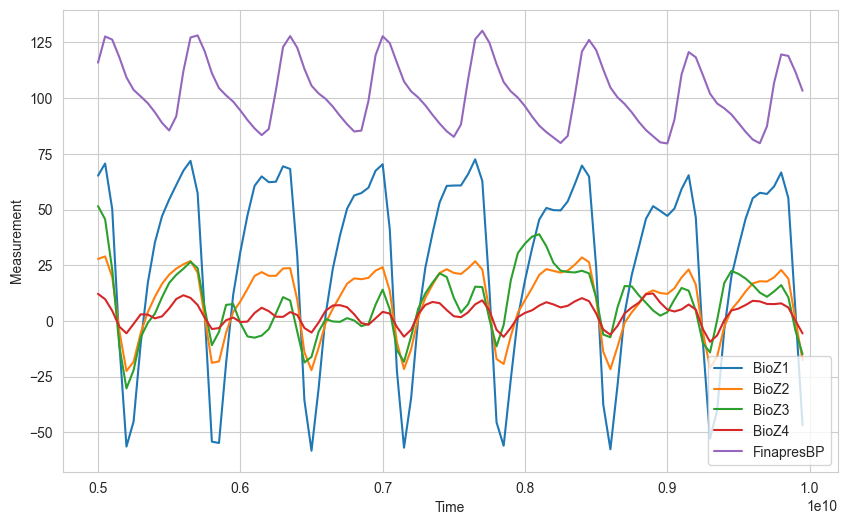

In [46]:
trial_index = (1, 1, 1)
start_time = pd.to_timedelta('5 seconds')
end_time = pd.to_timedelta('10 seconds')

grouped_trials = resampled_df.groupby(['Subject', 'Day', 'Trial'])
trial = grouped_trials.get_group(trial_index)
plot_measurements(trial, start_time, end_time)

In [47]:
def train_and_evaluate_rf_regressor(df, features=['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4'], test_size=0.2, n_estimators=100):

    # Extract features and target from the DataFrame
    features = resampled_df[features].values
    target = resampled_df['FinapresBP'].values

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=1234)

    # Initialise and train the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=1234)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    # Print the performance metrics
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2 Score: {r2}')

    return model

In [48]:
grouped_trials = df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 16.53214808942957

Root Mean Squared Error: 21.11685186559017

R^2 Score: 0.09361162058121586


Obviously this is quite poor, lets see how alignment changes it.

### **1.3 Outlier Removal**

Some of the trials have very strange values.

Here is one hgcp trial that looks especially suspicious

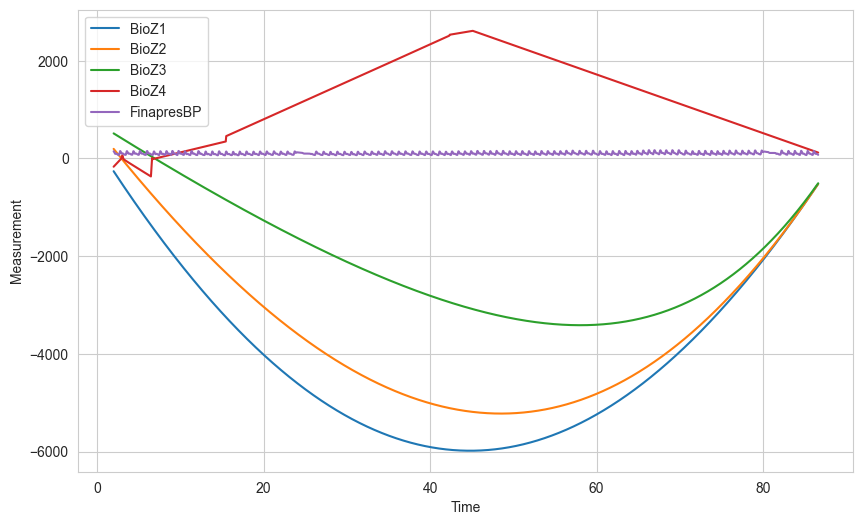

In [49]:
trial_index = (3, 1, 24)  # The selected trial
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
plot_measurements(grouped_trials.get_group(trial_index), 0, 10000)  # Just to show the full trial

This is what they said in the paper:

"Occasionally, the extensive pressure applied by the finapres NOVA's finger cuff, and possible misplacement of the reader, have resulted in
conditionally wrong collection of "training/true" data. When at rest conditions we saw the DBP values above 140 and SBP values above 160,
those trials were excluded from the evaluation"

**Rest condtions can be derrived from the Readme:**


- (a)	**HGCP (Hand Grip Cold Pressor)**: the subject performs a handgrip (HG) exercise for 3 minutes, slowly raising their DBP and SBP, then placing their hand into an ice cold water bucket (cold pressor, CP) for 1 minute to ensure that BP first goes even higher, then very slowly decreases over the 4 minute resting period.

- (b)	**Cycling**: the subject is stationed to perform a set of bike cycling treadmill exercises for 4 minutes, with 4 minutes of break for resting in between. 

- (c)	**Valsalva**: session with multiple Valsalva maneuvers. Each Valsalva maneuver consists of a subject pinching their nose while trying to breathe out intensely for 20-30 seconds, creating an extensive buildup of inner pressure, both raising BR, then decreasing, and rapidly increasing it once again very rapidly. 

- (d)	**baseline**: At the beginning of data collection with no BP change protocol, participants are at rest.

- (e)	**rest**: no BP change protocol, participants are at rest.

Unfortunately the resting phase of each experiment has not been clearly laid out.

After visualising several trials, I was able to understand how the data is structured.

According to the readme **"The data in data_trial CSV files were collected successively after each other based on the sequence of the index"**.

Each setup folder defines an individual experiment with the trials within depicting one continuous time series, despite the fact each trial csv restarts at 1 second.

 e.g. The first event in trial 2 occurs just after the last event in trial 1. This can be seen in the plots below, where trends and series features cross the trial boundary.

Every non-cycling trial is **86.6** seconds long.

In [50]:
setup_index = (3, 1, 7)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
setup

display(setup)

Subject  Day SetupType  Setup  Trial       time       BioZ1  \
2165673        3    1      hgcp      7     28   2.004449 -135.554932   
2165674        3    1      hgcp      7     28   2.009449 -133.732469   
2165675        3    1      hgcp      7     28   2.014449 -131.853078   
2165676        3    1      hgcp      7     28   2.019449 -129.901177   
2165677        3    1      hgcp      7     28   2.024449 -127.859813   
...          ...  ...       ...    ...    ...        ...         ...   
2250266        3    1      hgcp      7     32  86.574980  -16.608689   
2250267        3    1      hgcp      7     32  86.579980  -34.898814   
2250268        3    1      hgcp      7     32  86.584980  -52.605350   
2250269        3    1      hgcp      7     32  86.589980  -69.506914   
2250270        3    1      hgcp      7     32  86.594980  -85.402730   

             BioZ2        BioZ3        BioZ4  FinapresBP  
2165673 -29.218398   -12.376716   -14.089448    76.20590  
2165674 -29.432797   -12.032383   -13.799662    76.94126  
2165675 -29.631815   -11.695706   -13.507667    77.71337  
2165676 -29.806812   -11.369451   -13.212985    78.50984  
2165677 -29.949778   -11.055483   -12.914793    79.31771  
...            ...          ...          ...         ...  
2250266  -5.549519 -4291.656383 -1418.437952    98.92886  
2250267  -9.825669 -4282.668454 -1417.122784    96.86327  
2250268 -13.961108 -4273.638398 -1415.739374    94.85943  
2250269 -17.914464 -4264.548525 -1414.273728    92.92543  
2250270 -21.649459 -4255.382892 -1412.713136    91.06832  

[84598 rows x 11 columns]

Plot the setup, showing each trial.

In [51]:
def plot_setup(setup):
    
    # Show the setup type
    print(setup['SetupType'].iloc[0])
    
    # Create the plot
    plt.figure(figsize=(18, 6))
    sns.lineplot(data=setup, x=setup.index, y='FinapresBP')
    
    # Find indices where the trial changes
    change_points = setup['Trial'].diff()[setup['Trial'].diff() != 0].index
    
    # Draw vertical lines at these change points
    for cp in change_points:
        plt.axvline(x=cp, color='k', linestyle='--')

    plt.xlabel('Index')
    plt.show()


hgcp


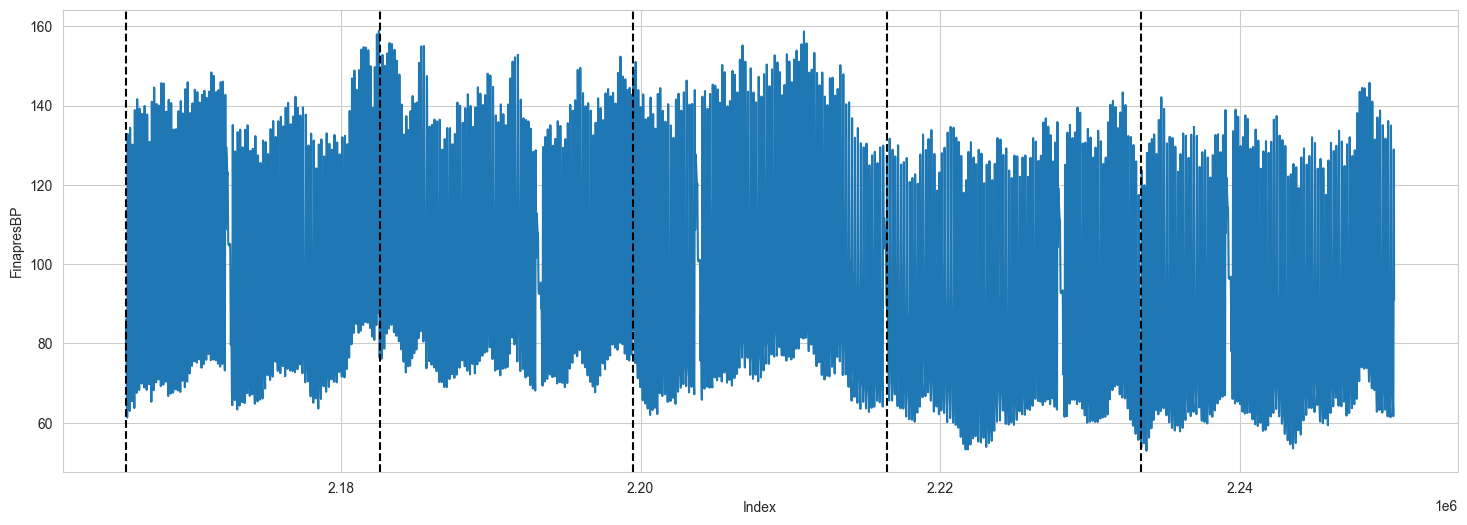

In [52]:
plot_setup(setup)

hgcp


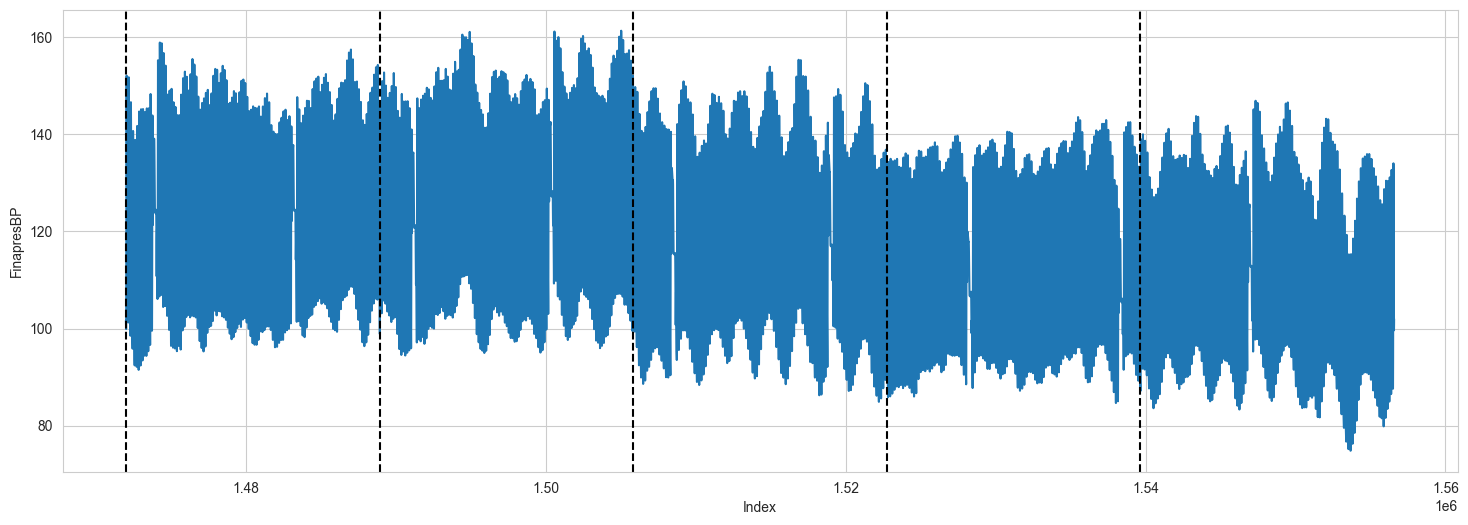

In [53]:
setup_index = (2, 1, 7)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
plot_setup(setup)

valsalva


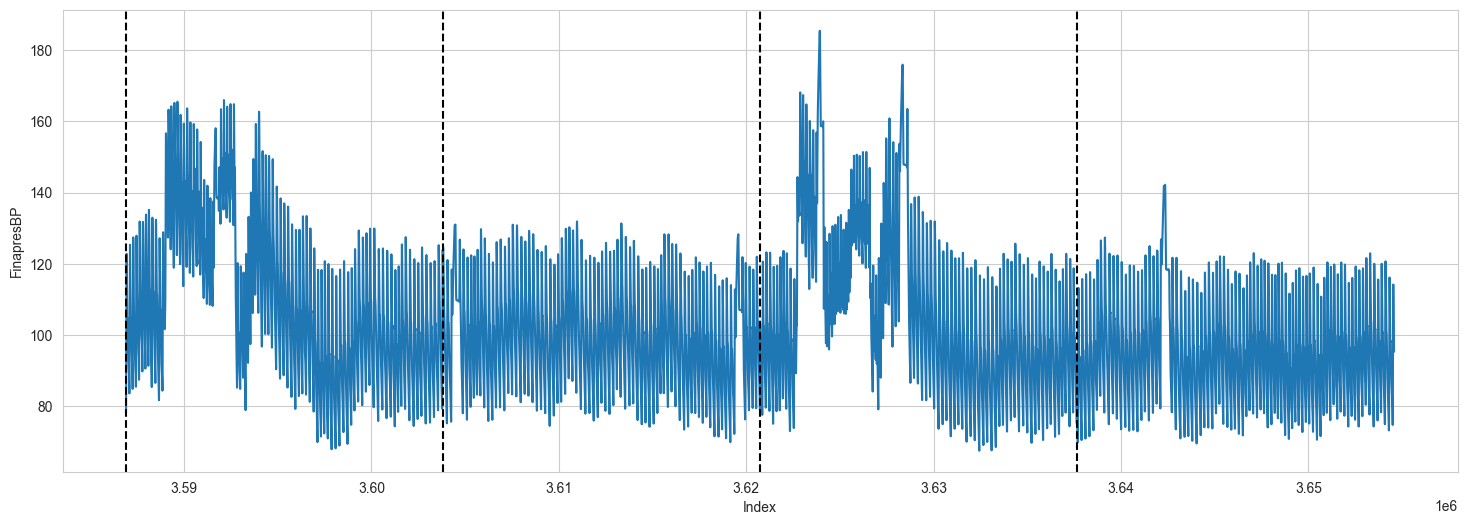

In [54]:
setup_index = (5, 1, 8)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
plot_setup(setup)

valsalva


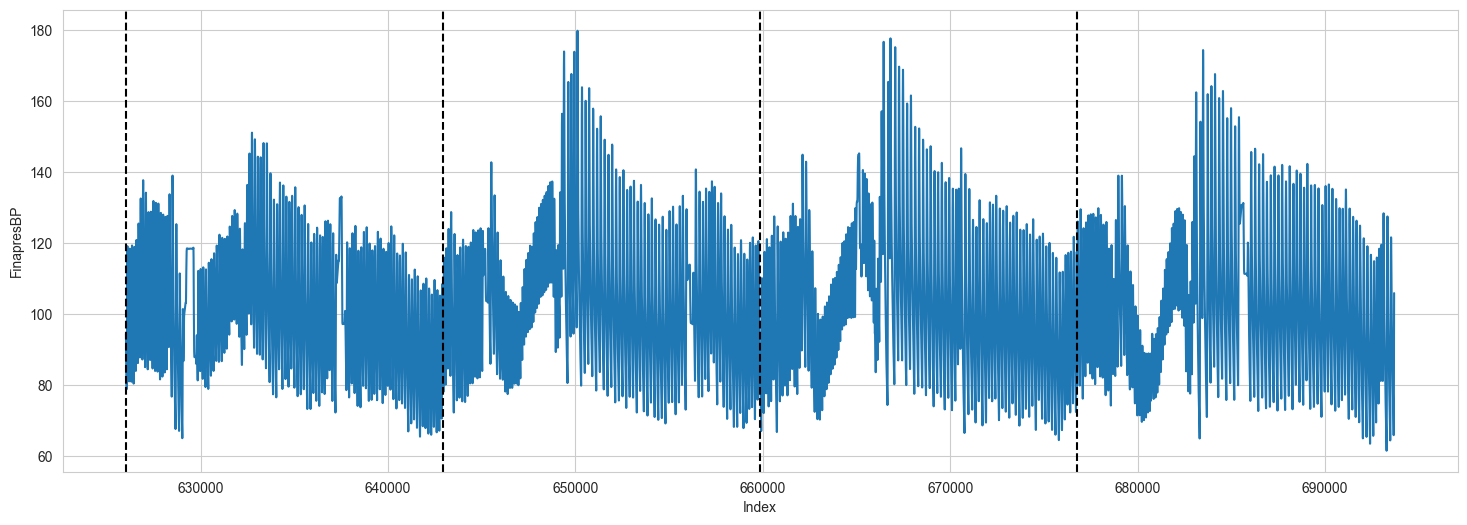

In [55]:
setup_index = (1, 1, 9)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
plot_setup(setup)

baseline


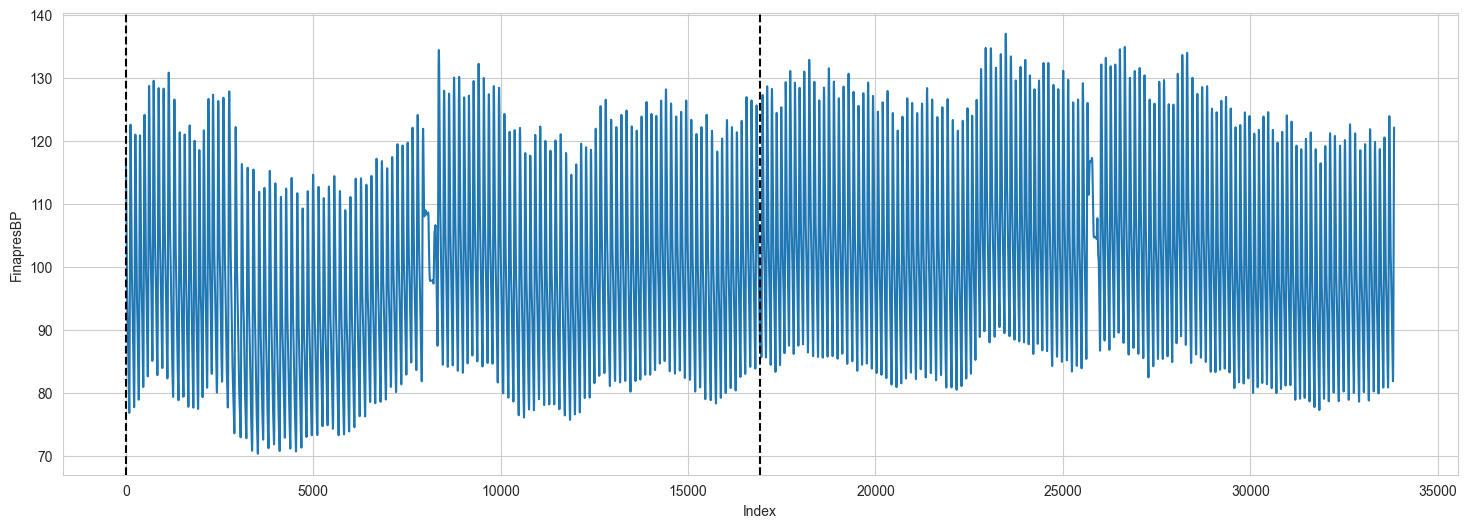

In [56]:
setup_index = (1, 1, 1)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
plot_setup(setup)

I can zoom in and look at the exact crossover point

There does seem to be a mismatch between the FinapresBP values in the trials. Most likely because FinapresBP values are recorded after 2 seconds, unlike BioZ which starts at 1 second.

However, I don't think this will cause any major issues, as the gaps should be no more than a few seconds.

baseline


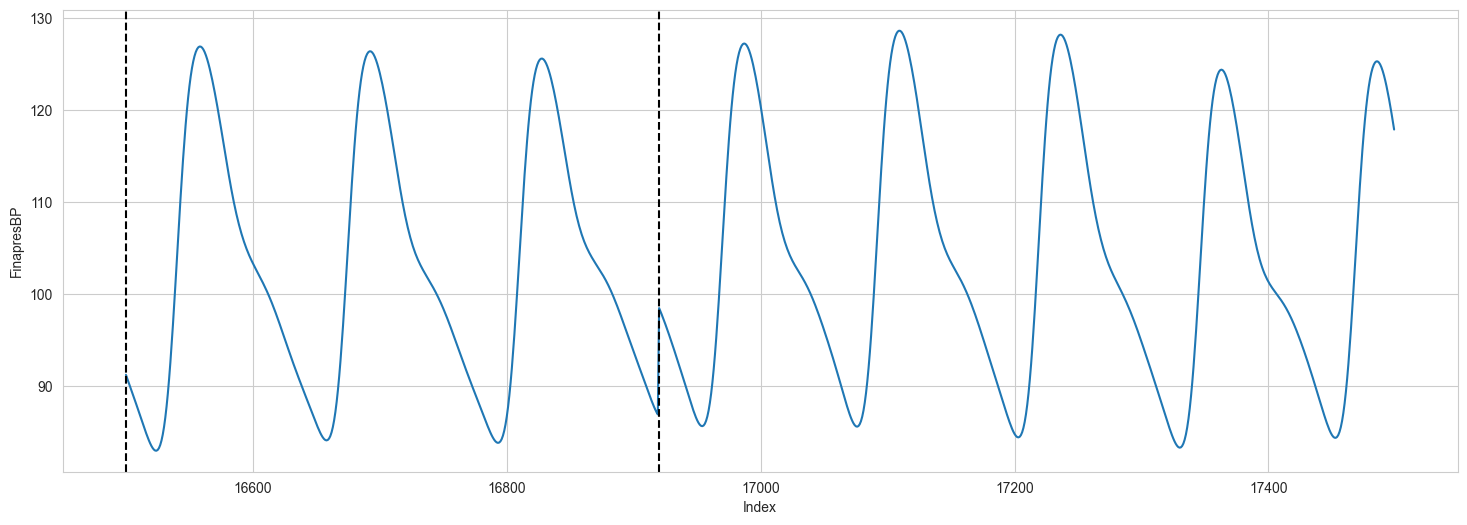

In [57]:
setup_crossover = setup.iloc[16500:17500]
plot_setup(setup_crossover)

The exception is the cycling setup, where the trials do not seem to depict one continous event.

Based on the code on their [github](https://github.com/TAMU-ESP/Graphene_BP/blob/main/config.hjson) the cycling subject is not even used for model training and evaluation, so maybe the whole cyling setup should be dropped.

cycling


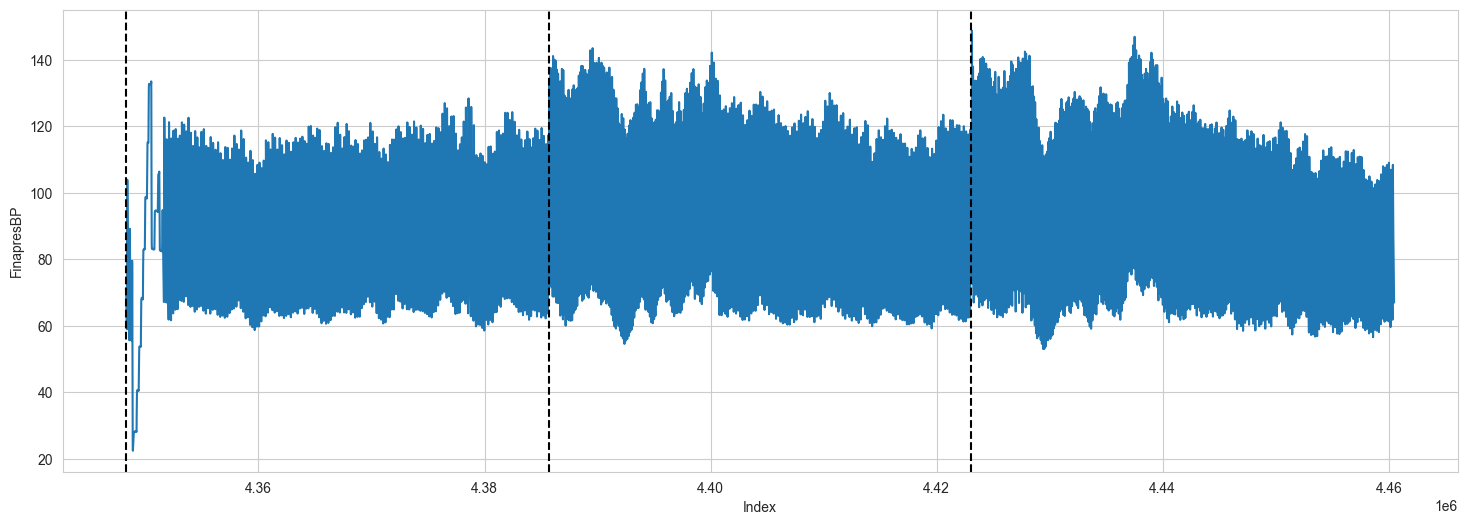

In [58]:
setup_index = (7, 1, 1)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
plot_setup(setup)

> ##### **Rest Periods**

Based on this structure and the descriptions in the readme I will create these outlier conditions for each setup.

Any setup containing a trial with an SBP > 160 and a DBP > 140 during the resting phase will be dropped.

For `rest` and `baseline` all trials will be checked, as the subjects are resting throughout.

For `hgcp` I will consider the 4th trial and above as the resting period, and drop the setup.

Technically the resting period begins just before the end of the 3rd trial (240 seconds / 86.6 = 2.77), but I'll allow for the delay to accound for high BP at the start of the rest.

`valsalva` will be the hardest one to define, as the documentation does not outline a resting period, and the visualisations don't show a consistent pattern. In some, every second trial looks like a rest period, while other setups seem to perform the valsalva blood pressure raising technique in every trial. 

For outlier detection I am going to consider the final 40% of each valsalve trial as the resting period, as this seems to be the case in every valsalva plot.

I will leave `cycling` in the dataset, but I will probably exclude if from general training and evalutation like the they did.

Checking for **SBP** over 160 can just be calculated from the maximum ***FinapresBP*** in the trial.

**DBP** on the other hand requires the analysis of troughs in the BP signal. If any of the troughs in the resting phase are above 140 then the trial should be dropped.

> ##### **Calculating Systolic and Diastolic outliers**

Checking for **SBP** over 160 can just be calculated from the maximum ***FinapresBP*** in the trial.

**DBP** on the other hand requires the analysis of troughs in the BP signal. If any of the troughs in the resting phase are above 140 then the trial should be dropped.

In [59]:
from scipy.signal import find_peaks

**I'll show an example on one trial.**

In [60]:
trial_index = (1, 1, 1)

grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
trial = grouped_trials.get_group(trial_index)

To see if systolic pressure ever exceeds 160 I'll just get the max of the trial.

In [61]:
print(f"Highest Systolic Pressure: {trial['FinapresBP'].max()}")

Highest Systolic Pressure: 134.39171


In this case it does not go above 160.

Now I will look at each diastolic trough, and find the highest one.

In [62]:
trough_indices, _ = find_peaks(-1 * trial['FinapresBP']) # Use the inverse of the blood pressure
diastolic_troughs = trial.iloc[trough_indices]
diastolic_troughs

Subject  Day SetupType  Setup  Trial       time      BioZ1      BioZ2  \
88           1    1  baseline      1      1   2.440961  59.193185  20.743063   
218          1    1  baseline      1      1   3.090961  55.551286  26.529409   
342          1    1  baseline      1      1   3.710961  56.865060  20.775088   
462          1    1  baseline      1      1   4.310961  48.784731  19.822489   
583          1    1  baseline      1      1   4.915961  53.935726  23.746282   
...        ...  ...       ...    ...    ...        ...        ...        ...   
16268        1    1  baseline      1      1  83.340961  57.419920  21.962378   
16395        1    1  baseline      1      1  83.975961  43.983223  16.980014   
16524        1    1  baseline      1      1  84.620961  42.849473  18.658557   
16658        1    1  baseline      1      1  85.290961  28.893818  14.030784   
16793        1    1  baseline      1      1  85.965961  31.294656  10.593416   

           BioZ3      BioZ4  FinapresBP  
88     17.326721  11.420255    76.80046  
218    48.879113   9.817010    77.69298  
342    16.436217  11.404378    78.88342  
462    36.713788  10.377359    80.89861  
583    23.026680  11.614106    82.58906  
...          ...        ...         ...  
16268  14.696487   5.413314    80.35269  
16395  12.955766   5.057784    82.48624  
16524  13.509583   3.990934    82.96873  
16658  22.178007   0.170275    84.09248  
16793   0.449065   1.885231    83.82470  

[127 rows x 11 columns]

Here's a visualisation of the troughs

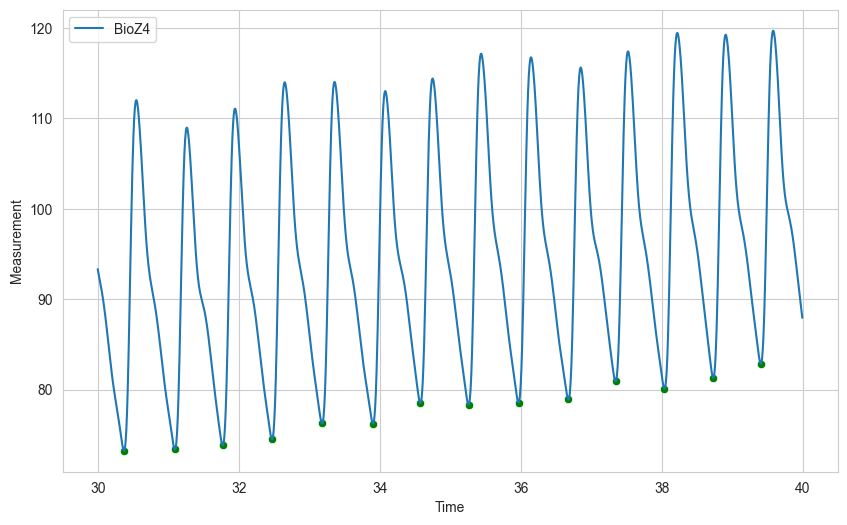

In [63]:
start_time = 30
end_time = 40
plot_df = trial[(trial['time'] >= start_time) & (trial['time'] <= end_time)]

plot_troughs, _ = find_peaks(-1 * plot_df['FinapresBP']) # Use the inverse of the blood pressure

# Create the plot
plt.figure(figsize=(10, 6))

sns.lineplot(data=plot_df, x='time', y='FinapresBP', label=column)
sns.scatterplot(data=plot_df.iloc[plot_troughs], x="time", y="FinapresBP", color="green")

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Now I'll find the highest of these local minima to see if it exceeds 140.

In [64]:
print(f"Highest Diastolic Pressure: {diastolic_troughs['FinapresBP'].max()}")

Highest Diastolic Pressure: 108.2298


This is also fine, so this trial is not an outlier.

> ##### **Repeat for the full dataset.**

I'll filter the dataset based on resting periods.

In [65]:
df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961  48.332439   
1              1    1  baseline      1      1    2.005961  43.384880   
2              1    1  baseline      1      1    2.010961  37.969078   
3              1    1  baseline      1      1    2.015961  32.123190   
4              1    1  baseline      1      1    2.020961  25.896649   
...          ...  ...       ...    ...    ...         ...        ...   
4460467        7    1   cycling      1      3  188.974952 -12.991598   
4460468        7    1   cycling      1      3  188.979952 -11.185842   
4460469        7    1   cycling      1      3  188.984952  -9.428160   
4460470        7    1   cycling      1      3  188.989952  -7.727173   
4460471        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  
0        16.943260   4.337878   4.415633   117.25990  
1        15.087782   2.756093   3.484722   116.50575  
2        13.056467   1.085794   2.508537   115.71514  
3        10.864834  -0.655107   1.496772   114.89302  
4         8.532647  -2.445484   0.460766   114.04378  
...            ...        ...        ...         ...  
4460467  -1.507162 -19.132283 -19.132283    67.67920  
4460468  -1.269116 -18.493100 -18.493100    67.50756  
4460469  -1.026987 -17.864842 -17.864842    67.33915  
4460470  -0.781154 -17.252701 -17.252701    67.17298  
4460471  -0.531917 -16.661449 -16.661449    67.00795  

[4460472 rows x 11 columns]

In [66]:
def filter_rest_periods(group):

    setup_type = group['SetupType'].iloc[0]
    trials = group['Trial'].unique()

    # If the setup type is rest or baseline return all of the trials
    if setup_type in ['rest', 'baseline']:
        return group
    
    # If the setup type is hgcp return the trials after the first 3
    elif setup_type == 'hgcp':
        rest_trials = group[group['Trial'].isin(trials[3:])]
        return rest_trials
    
    # If the setup type is valsalve return the last 40% of the trial/measurements after 52 seconds
    elif setup_type == 'valsalva':
        rest_trials = group[group['time'] > 52]
        return rest_trials

# Group each setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])

# Apply the function to each group and combine the results
rest_df = grouped_setups.apply(filter_rest_periods).reset_index(drop=True)
rest_df

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\180549142.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rest_df = grouped_setups.apply(filter_rest_periods).reset_index(drop=True)


Subject  Day SetupType  Setup  Trial       time      BioZ1  \
0              1    1  baseline      1      1   2.000961  48.332439   
1              1    1  baseline      1      1   2.005961  43.384880   
2              1    1  baseline      1      1   2.010961  37.969078   
3              1    1  baseline      1      1   2.015961  32.123190   
4              1    1  baseline      1      1   2.020961  25.896649   
...          ...  ...       ...    ...    ...        ...        ...   
1905666        6    1  baseline      9     40  86.574109 -56.258637   
1905667        6    1  baseline      9     40  86.579109 -55.675885   
1905668        6    1  baseline      9     40  86.584109 -54.977286   
1905669        6    1  baseline      9     40  86.589109 -54.184974   
1905670        6    1  baseline      9     40  86.594109 -53.319686   

             BioZ2      BioZ3     BioZ4  FinapresBP  
0        16.943260   4.337878  4.415633   117.25990  
1        15.087782   2.756093  3.484722   116.50575  
2        13.056467   1.085794  2.508537   115.71514  
3        10.864834  -0.655107  1.496772   114.89302  
4         8.532647  -2.445484  0.460766   114.04378  
...            ...        ...       ...         ...  
1905666  -1.977988 -18.517618 -7.937796   100.72683  
1905667  -1.520139 -18.753110 -8.141400   100.84379  
1905668  -1.022313 -18.847017 -8.277126   100.97854  
1905669  -0.490565 -18.800625 -8.345440   101.12264  
1905670   0.068603 -18.617791 -8.348114   101.26845  

[1905671 rows x 11 columns]

In [67]:
rest_df[rest_df['SetupType'] == 'hgcp']

Subject  Day SetupType  Setup  Trial       time      BioZ1  \
33839          1    1      hgcp      2      6   2.002267  39.138973   
33840          1    1      hgcp      2      6   2.007267  39.920272   
33841          1    1      hgcp      2      6   2.012267  40.716621   
33842          1    1      hgcp      2      6   2.017267  41.531416   
33843          1    1      hgcp      2      6   2.022267  42.368406   
...          ...  ...       ...    ...    ...        ...        ...   
1871827        6    1      hgcp      8     38  86.574650  31.867872   
1871828        6    1      hgcp      8     38  86.579650  32.422929   
1871829        6    1      hgcp      8     38  86.584650  33.029351   
1871830        6    1      hgcp      8     38  86.589650  33.679064   
1871831        6    1      hgcp      8     38  86.594650  34.361425   

             BioZ2      BioZ3     BioZ4  FinapresBP  
33839    15.318482   8.891996  4.373334    89.66492  
33840    15.662775   9.410356  4.790002    90.52957  
33841    16.012758   9.907332  5.201918    91.57142  
33842    16.370157  10.383470  5.606598    92.79294  
33843    16.736764  10.839932  6.001297    94.19132  
...            ...        ...       ...         ...  
1871827  13.128221   6.133593  0.968266   116.40797  
1871828  13.434990   6.607847  1.533836   119.03249  
1871829  13.793842   7.107212  2.126163   121.39559  
1871830  14.200131   7.628836  2.730921   123.47287  
1871831  14.647382   8.168809  3.332047   125.25035  

[1438138 rows x 11 columns]

In [68]:
rest_df[rest_df['SetupType'] == 'valsalva']

Subject  Day SetupType  Setup  Trial       time      BioZ1  \
270707         1    1  valsalva      9     38  52.001358  40.051106   
270708         1    1  valsalva      9     38  52.006358  40.202189   
270709         1    1  valsalva      9     38  52.011358  40.360301   
270710         1    1  valsalva      9     38  52.016358  40.530548   
270711         1    1  valsalva      9     38  52.021358  40.717744   
...          ...  ...       ...    ...    ...        ...        ...   
1837988        6    1  valsalva      7     33  86.573492 -37.627448   
1837989        6    1  valsalva      7     33  86.578492 -40.165002   
1837990        6    1  valsalva      7     33  86.583492 -42.210551   
1837991        6    1  valsalva      7     33  86.588492 -43.759379   
1837992        6    1  valsalva      7     33  86.593492 -44.815117   

             BioZ2        BioZ3     BioZ4  FinapresBP  
270707   10.232306 -2087.604340  6.058382    77.78051  
270708   10.345916 -2455.881882  5.884984    77.74751  
270709   10.451050 -3102.002589  5.717978    77.81333  
270710   10.552067 -3989.694918  5.559014    77.99569  
270711   10.653602 -5077.070436  5.409877    78.31261  
...            ...          ...       ...         ...  
1837988 -13.094443    -5.717871 -1.000974   105.25870  
1837989 -13.710956    -6.168483 -0.951998   104.97948  
1837990 -14.169027    -6.493617 -0.910162   104.76994  
1837991 -14.471783    -6.692473 -0.873678   104.62785  
1837992 -14.624954    -6.766956 -0.840791   104.54405  

[179903 rows x 11 columns]

Now I will check for outliers in each of the rest periods

In [69]:
def find_outlier_trials(group):

    # Find maximum systolic blood pressure
    systolic_max = group['FinapresBP'].max()

    # Find maximum diastolic blood pressure
    trough_indices, _ = find_peaks(-1 * group['FinapresBP'], distance = 100) # The distance parameter was found later on in the beat creation process
    diastolic_troughs = group.iloc[trough_indices]
    diastolic_max = diastolic_troughs['FinapresBP'].max()

    # Mark the trial as an outlier or not
    #if systolic_max > 160 or diastolic_max > 140:
    if systolic_max > 160 and diastolic_max > 140:
            group['Outlier'] = True
    else:
        group['Outlier'] = False

    return group

# Group by 'Subject', 'Day', and 'Trial'
grouped_setups = rest_df.groupby(['Subject', 'Day', 'Trial'], as_index=False)

# Apply the function to each group and combine the results
rest_df = grouped_setups.apply(find_outlier_trials).reset_index(drop=True)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\1522125615.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rest_df = grouped_setups.apply(find_outlier_trials).reset_index(drop=True)


In [70]:
outlier_trials = rest_df[rest_df['Outlier'] == True]
display(outlier_trials)
display(outlier_trials.groupby(['Subject', 'Day', 'Trial'])['SetupType'].first().value_counts()) # Outlier Trials by setup type

Subject  Day SetupType  Setup  Trial       time      BioZ1  \
1654962        6    1      hgcp      2      6   2.003667  48.012506   
1654963        6    1      hgcp      2      6   2.008667  43.697562   
1654964        6    1      hgcp      2      6   2.013667  38.971913   
1654965        6    1      hgcp      2      6   2.018667  33.855513   
1654966        6    1      hgcp      2      6   2.023667  28.382483   
...          ...  ...       ...    ...    ...        ...        ...   
1756473        6    1      hgcp      4     17  86.573559  55.540037   
1756474        6    1      hgcp      4     17  86.578559  55.896734   
1756475        6    1      hgcp      4     17  86.583559  56.121552   
1756476        6    1      hgcp      4     17  86.588559  56.217606   
1756477        6    1      hgcp      4     17  86.593559  56.190643   

             BioZ2      BioZ3     BioZ4  FinapresBP  Outlier  
1654962  13.267564   9.867200  4.862986   162.55308     True  
1654963  11.813842   8.163728  4.330699   162.09158     True  
1654964  10.255780   6.368504  3.765613   161.55257     True  
1654965   8.600933   4.499916  3.167115   160.94278     True  
1654966   6.860196   2.578923  2.536068   160.26898     True  
...            ...        ...       ...         ...      ...  
1756473  22.810545  27.113035  7.398250   105.79473     True  
1756474  22.972558  27.660790  6.976068   105.63278     True  
1756475  23.082715  28.185751  6.593762   105.46411     True  
1756476  23.145357  28.685974  6.255173   105.28793     True  
1756477  23.165989  29.160113  5.962866   105.10364     True  

[84597 rows x 12 columns]

SetupType
hgcp    5
Name: count, dtype: int64

The value counts above show the number of outlier trials of each SetupType found in the data.

I'll plot some of them, showing the individual trial, and the overall setup.

In [71]:
outlier_trials[['Subject', 'Day', 'SetupType', 'Setup', 'Trial']].drop_duplicates()

Subject  Day SetupType  Setup  Trial
1654962        6    1      hgcp      2      6
1671881        6    1      hgcp      2      7
1688801        6    1      hgcp      3     11
1705721        6    1      hgcp      3     12
1739559        6    1      hgcp      4     17

hgcp


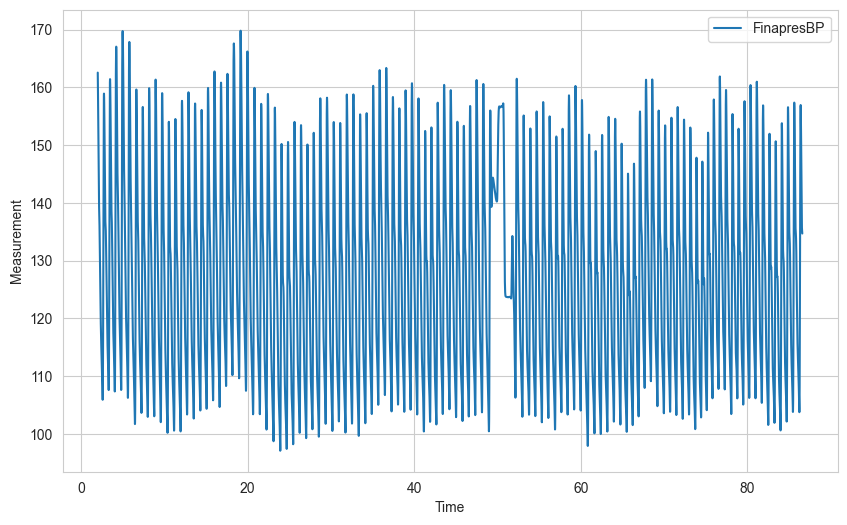

In [72]:
columns_to_plot = ['FinapresBP']

trial_index = (6, 1, 6)

grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
trial = grouped_trials.get_group(trial_index)
print(trial['SetupType'].iloc[0])
plot_measurements(trial, 0, 10000)

hgcp


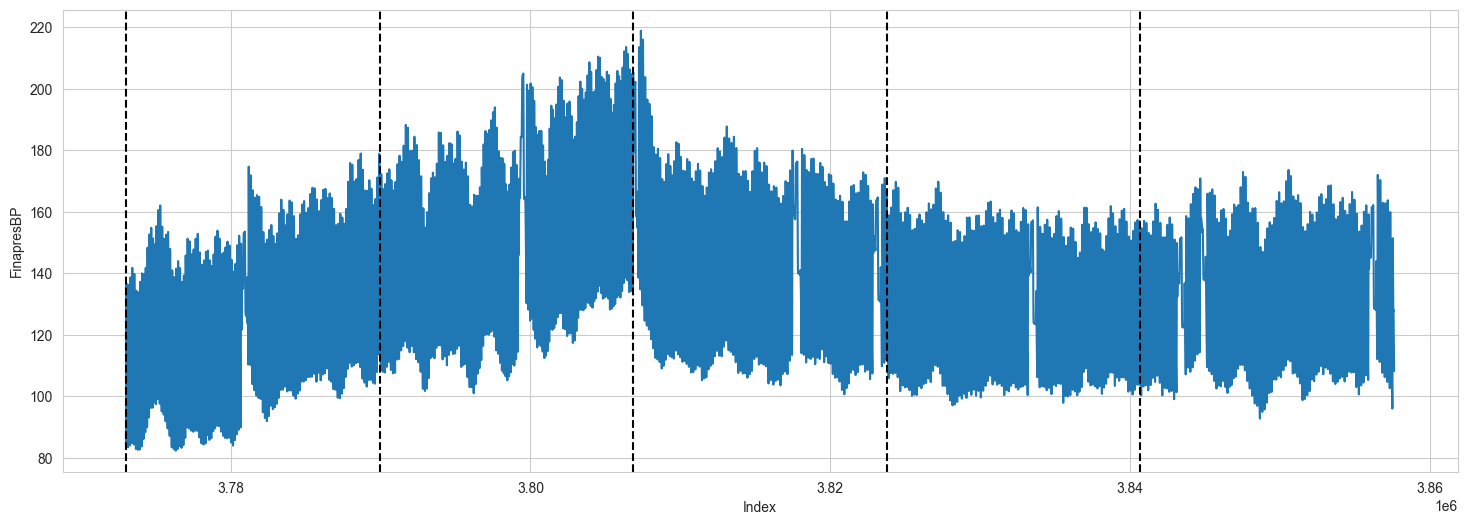

In [73]:
setup_index = (6, 1, 2)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
plot_setup(setup)

hgcp


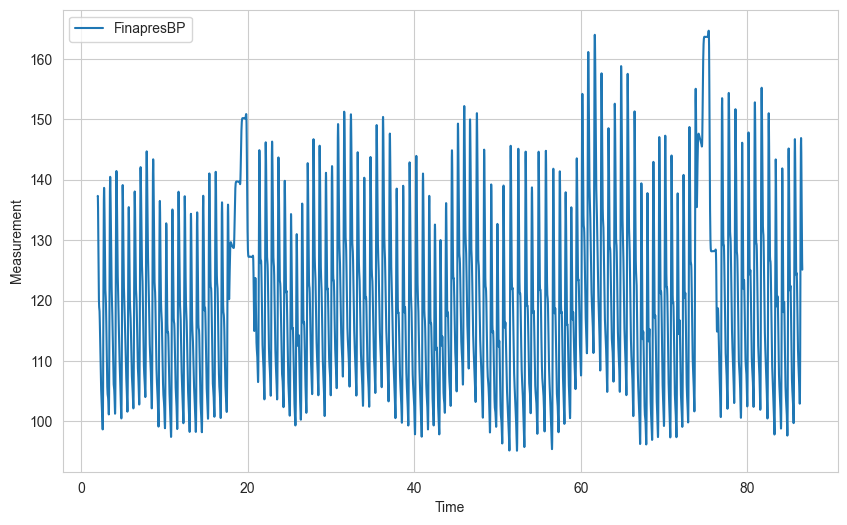

In [74]:
trial_index = (6, 1, 11)

grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
trial = grouped_trials.get_group(trial_index)
print(trial['SetupType'].iloc[0])
plot_measurements(trial, 0, 10000)

hgcp


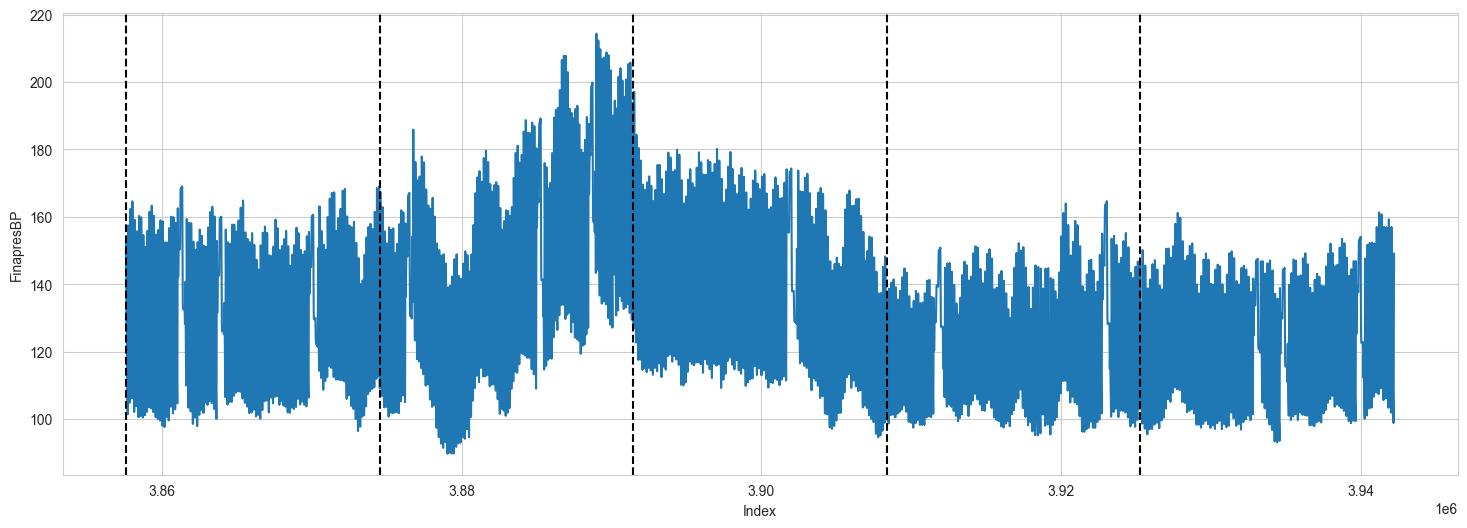

In [75]:
setup_index = (6, 1, 3)  # The selected Setup
grouped_setups = df.groupby(['Subject', 'Day', 'Setup'])
setup = grouped_setups.get_group(setup_index)
plot_setup(setup)

Then I can find the number of setups that contain outlier trials.

In [76]:
outlier_setups = outlier_trials[['Subject', 'Day', 'SetupType', 'Setup']].drop_duplicates()
# outlier_setups = outlier_trials[['Subject', 'Day', 'SetupType', 'Setup', 'Trial']].drop_duplicates()
display(outlier_setups)
display(outlier_setups['SetupType'].value_counts())

Subject  Day SetupType  Setup
1654962        6    1      hgcp      2
1688801        6    1      hgcp      3
1739559        6    1      hgcp      4

SetupType
hgcp    3
Name: count, dtype: int64

**Finally I will drop any setup that contains an outlier trial**

In [77]:
# Merge the original df with the outlier setups
merged_df = df.merge(outlier_setups, on=['Subject', 'Day', 'SetupType', 'Setup'], how='left', indicator=True)
# merged_df = df.merge(outlier_setups, on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial'], how='left', indicator=True)
display(merged_df)

# Filter rows where the merge indicator is '_merge' == 'left_only', meaning they were not in the combinations to remove
filtered_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
display(filtered_df)

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961  48.332439   
1              1    1  baseline      1      1    2.005961  43.384880   
2              1    1  baseline      1      1    2.010961  37.969078   
3              1    1  baseline      1      1    2.015961  32.123190   
4              1    1  baseline      1      1    2.020961  25.896649   
...          ...  ...       ...    ...    ...         ...        ...   
4460467        7    1   cycling      1      3  188.974952 -12.991598   
4460468        7    1   cycling      1      3  188.979952 -11.185842   
4460469        7    1   cycling      1      3  188.984952  -9.428160   
4460470        7    1   cycling      1      3  188.989952  -7.727173   
4460471        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP     _merge  
0        16.943260   4.337878   4.415633   117.25990  left_only  
1        15.087782   2.756093   3.484722   116.50575  left_only  
2        13.056467   1.085794   2.508537   115.71514  left_only  
3        10.864834  -0.655107   1.496772   114.89302  left_only  
4         8.532647  -2.445484   0.460766   114.04378  left_only  
...            ...        ...        ...         ...        ...  
4460467  -1.507162 -19.132283 -19.132283    67.67920  left_only  
4460468  -1.269116 -18.493100 -18.493100    67.50756  left_only  
4460469  -1.026987 -17.864842 -17.864842    67.33915  left_only  
4460470  -0.781154 -17.252701 -17.252701    67.17298  left_only  
4460471  -0.531917 -16.661449 -16.661449    67.00795  left_only  

[4460472 rows x 12 columns]

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961  48.332439   
1              1    1  baseline      1      1    2.005961  43.384880   
2              1    1  baseline      1      1    2.010961  37.969078   
3              1    1  baseline      1      1    2.015961  32.123190   
4              1    1  baseline      1      1    2.020961  25.896649   
...          ...  ...       ...    ...    ...         ...        ...   
4460467        7    1   cycling      1      3  188.974952 -12.991598   
4460468        7    1   cycling      1      3  188.979952 -11.185842   
4460469        7    1   cycling      1      3  188.984952  -9.428160   
4460470        7    1   cycling      1      3  188.989952  -7.727173   
4460471        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  
0        16.943260   4.337878   4.415633   117.25990  
1        15.087782   2.756093   3.484722   116.50575  
2        13.056467   1.085794   2.508537   115.71514  
3        10.864834  -0.655107   1.496772   114.89302  
4         8.532647  -2.445484   0.460766   114.04378  
...            ...        ...        ...         ...  
4460467  -1.507162 -19.132283 -19.132283    67.67920  
4460468  -1.269116 -18.493100 -18.493100    67.50756  
4460469  -1.026987 -17.864842 -17.864842    67.33915  
4460470  -0.781154 -17.252701 -17.252701    67.17298  
4460471  -0.531917 -16.661449 -16.661449    67.00795  

[4206683 rows x 11 columns]

Show the number of dropped rows.

In [78]:
print(f'Number of dropped rows: {len(df) - len(filtered_df)}')
print(f'Number of dropped trials: {260 - len(filtered_df.groupby(["Subject", "Day", "Trial"]))}')
print(f'Number of trials remaining: {len(filtered_df.groupby(["Subject", "Day", "Trial"]))}')

Number of dropped rows: 253789
Number of dropped trials: 15
Number of trials remaining: 245


In [79]:
df = filtered_df

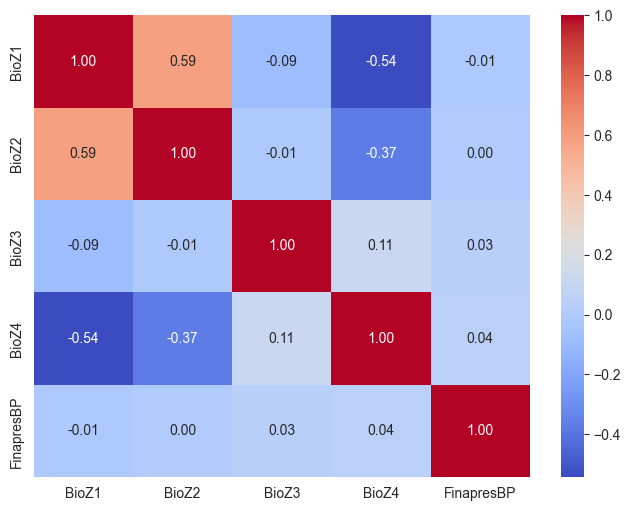

In [80]:
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']
plot_correlation_matrix(df, columns_to_plot)

In [81]:
df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961  48.332439   
1              1    1  baseline      1      1    2.005961  43.384880   
2              1    1  baseline      1      1    2.010961  37.969078   
3              1    1  baseline      1      1    2.015961  32.123190   
4              1    1  baseline      1      1    2.020961  25.896649   
...          ...  ...       ...    ...    ...         ...        ...   
4460467        7    1   cycling      1      3  188.974952 -12.991598   
4460468        7    1   cycling      1      3  188.979952 -11.185842   
4460469        7    1   cycling      1      3  188.984952  -9.428160   
4460470        7    1   cycling      1      3  188.989952  -7.727173   
4460471        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  
0        16.943260   4.337878   4.415633   117.25990  
1        15.087782   2.756093   3.484722   116.50575  
2        13.056467   1.085794   2.508537   115.71514  
3        10.864834  -0.655107   1.496772   114.89302  
4         8.532647  -2.445484   0.460766   114.04378  
...            ...        ...        ...         ...  
4460467  -1.507162 -19.132283 -19.132283    67.67920  
4460468  -1.269116 -18.493100 -18.493100    67.50756  
4460469  -1.026987 -17.864842 -17.864842    67.33915  
4460470  -0.781154 -17.252701 -17.252701    67.17298  
4460471  -0.531917 -16.661449 -16.661449    67.00795  

[4206683 rows x 11 columns]

In [82]:
grouped_trials = df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 15.903182279173889

Root Mean Squared Error: 20.359440611527276

R^2 Score: 0.09212405494505838

This performs slightly better.

### **1.4 Align the Full Dataset with Cross-Correlation.**

First I'll print the alignment of BP to BioZ across each trial.

In [83]:
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

for trial_name, trial in grouped_trials:

    # Show the alignment of FinapresBP and BioZ
    print(f'Trial: {trial_name}')

    for bioz in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        cross_correlation = cross_correlate(trial['FinapresBP'], -1*trial[bioz])
        print(f'{bioz}: {cross_correlation}')
    print()

Trial: (1, 1, 1)
BioZ1: -30
BioZ2: -30
BioZ3: -25
BioZ4: -29

Trial: (1, 1, 2)
BioZ1: -30
BioZ2: -30
BioZ3: -24
BioZ4: -28

Trial: (1, 1, 3)
BioZ1: -31
BioZ2: -31
BioZ3: -26
BioZ4: -30

Trial: (1, 1, 4)
BioZ1: -32
BioZ2: -32
BioZ3: -26
BioZ4: -31

Trial: (1, 1, 5)
BioZ1: -29
BioZ2: -30
BioZ3: -23
BioZ4: -30

Trial: (1, 1, 6)
BioZ1: -31
BioZ2: -32
BioZ3: -28
BioZ4: -30

Trial: (1, 1, 7)
BioZ1: -30
BioZ2: -30
BioZ3: -26
BioZ4: -29

Trial: (1, 1, 8)
BioZ1: -28
BioZ2: -27
BioZ3: 5816
BioZ4: -23

Trial: (1, 1, 9)
BioZ1: -29
BioZ2: -28
BioZ3: 6958
BioZ4: -23

Trial: (1, 1, 10)
BioZ1: -28
BioZ2: -27
BioZ3: -4055
BioZ4: -26

Trial: (1, 1, 11)
BioZ1: -29
BioZ2: -29
BioZ3: -5677
BioZ4: -25

Trial: (1, 1, 12)
BioZ1: -28
BioZ2: -27
BioZ3: -558
BioZ4: -23

Trial: (1, 1, 13)
BioZ1: -29
BioZ2: -29
BioZ3: 2317
BioZ4: -33

Trial: (1, 1, 14)
BioZ1: -30
BioZ2: -30
BioZ3: 6768
BioZ4: -34

Trial: (1, 1, 15)
BioZ1: -29
BioZ2: -29
BioZ3: -13717
BioZ4: -28

Trial: (1, 1, 16)
BioZ1: -29
BioZ2: -29
BioZ3: 9014


There appear to be some quite severe outliers, where the most correlated shift is very distant.

Shift each trial, aligning the series.

In [84]:
def align_group(group):
    aligned_group = group.copy() # Copy to avoid modifying the original dataframe
    
    for bioz_column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        shift_value = cross_correlate(aligned_group['FinapresBP'], -1 * aligned_group[bioz_column])
        aligned_group[bioz_column] = aligned_group[bioz_column].shift(shift_value)
    
    return aligned_group

# Group each trial
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

# Apply the function to each group and combine the results
aligned_df = grouped_trials.apply(align_group, include_groups=True).reset_index(drop=True)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\41769967.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = grouped_trials.apply(align_group, include_groups=True).reset_index(drop=True)


In [85]:
aligned_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961 -38.533330   
1              1    1  baseline      1      1    2.005961 -34.658723   
2              1    1  baseline      1      1    2.010961 -30.661121   
3              1    1  baseline      1      1    2.015961 -26.593230   
4              1    1  baseline      1      1    2.020961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4206678        7    1   cycling      1      3  188.974952        NaN   
4206679        7    1   cycling      1      3  188.979952        NaN   
4206680        7    1   cycling      1      3  188.984952        NaN   
4206681        7    1   cycling      1      3  188.989952        NaN   
4206682        7    1   cycling      1      3  188.994952        NaN   

             BioZ2      BioZ3     BioZ4  FinapresBP  
0       -14.585256 -10.377965 -3.523223   117.25990  
1       -13.120392  -8.771153 -2.842555   116.50575  
2       -11.614628  -7.086624 -2.168193   115.71514  
3       -10.087884  -5.347416 -1.504652   114.89302  
4        -8.558192  -3.576163 -0.854642   114.04378  
...            ...        ...       ...         ...  
4206678        NaN        NaN       NaN    67.67920  
4206679        NaN        NaN       NaN    67.50756  
4206680        NaN        NaN       NaN    67.33915  
4206681        NaN        NaN       NaN    67.17298  
4206682        NaN        NaN       NaN    67.00795  

[4206683 rows x 11 columns]

In [86]:
def show_bioz_shift(df=aligned_df):
    bioz_columns = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']
    print('Shift')
    display(aligned_df[bioz_columns].isna().sum())
    print('Average Shift Per Trial')
    display(aligned_df[bioz_columns].isna().sum() / len(df.groupby(['Subject', 'Day', 'Trial'])))  # Average shift per trial

show_bioz_shift()

Shift


BioZ1     96430
BioZ2    145916
BioZ3    205878
BioZ4    127524
dtype: int64

Average Shift Per Trial


BioZ1    393.591837
BioZ2    595.575510
BioZ3    840.318367
BioZ4    520.506122
dtype: float64

Drop the NaNs created by each shift

In [87]:
aligned_df = aligned_df.dropna()
display(aligned_df)

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961 -38.533330   
1              1    1  baseline      1      1    2.005961 -34.658723   
2              1    1  baseline      1      1    2.010961 -30.661121   
3              1    1  baseline      1      1    2.015961 -26.593230   
4              1    1  baseline      1      1    2.020961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4206640        7    1   cycling      1      3  188.784952 -14.835259   
4206641        7    1   cycling      1      3  188.789952 -12.991598   
4206642        7    1   cycling      1      3  188.794952 -11.185842   
4206643        7    1   cycling      1      3  188.799952  -9.428160   
4206644        7    1   cycling      1      3  188.804952  -7.727173   

             BioZ2      BioZ3      BioZ4  FinapresBP  
0       -14.585256 -10.377965  -3.523223   117.25990  
1       -13.120392  -8.771153  -2.842555   116.50575  
2       -11.614628  -7.086624  -2.168193   115.71514  
3       -10.087884  -5.347416  -1.504652   114.89302  
4        -8.558192  -3.576163  -0.854642   114.04378  
...            ...        ...        ...         ...  
4206640  -1.507162 -20.421111 -20.421111    78.58829  
4206641  -1.269116 -19.776869 -19.776869    78.16795  
4206642  -1.026987 -19.132283 -19.132283    77.75340  
4206643  -0.781154 -18.493100 -18.493100    77.34540  
4206644  -0.531917 -17.864842 -17.864842    76.94324  

[3857402 rows x 11 columns]

Unfortunately due to noisy data, not every trial finds a local alignment, instead a large proportion of the data gets shifted and dropped. One trial gets removed completely,

In [88]:
print(f"Rows Dropped: {len(df) - len(aligned_df)}")
print(f"Trial Count: {len(aligned_df[['Subject', 'Day', 'Trial']].drop_duplicates())}")

Rows Dropped: 349281
Trial Count: 244


I'll visualise a trial before and after alignment.

In [89]:
def plot_alignment(df, aligned_df, trial_index, start_time=50, end_time=55):
    print('Before Alignment')
    grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
    trial = grouped_trials.get_group(trial_index)
    plot_measurements(trial, start_time, end_time)

    print('After Alignment')
    grouped_trials = aligned_df.groupby(['Subject', 'Day', 'Trial'])
    trial = grouped_trials.get_group(trial_index)
    plot_measurements(trial, start_time, end_time)

Before Alignment


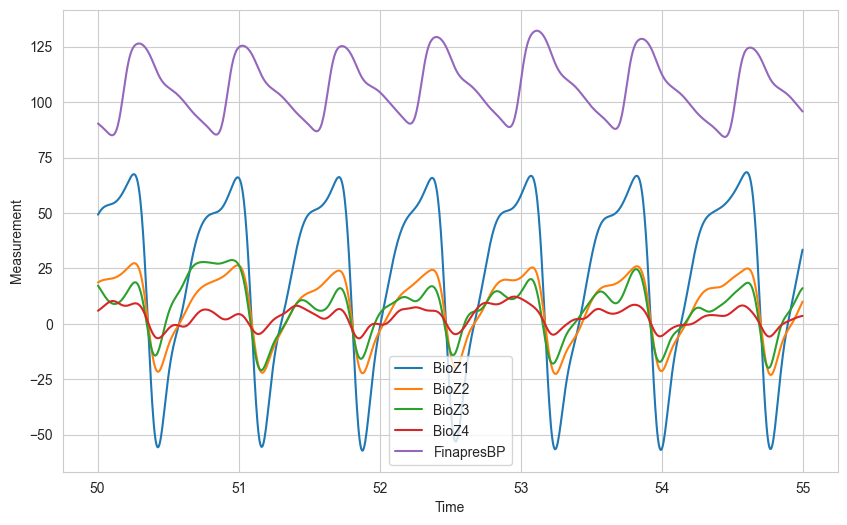

After Alignment


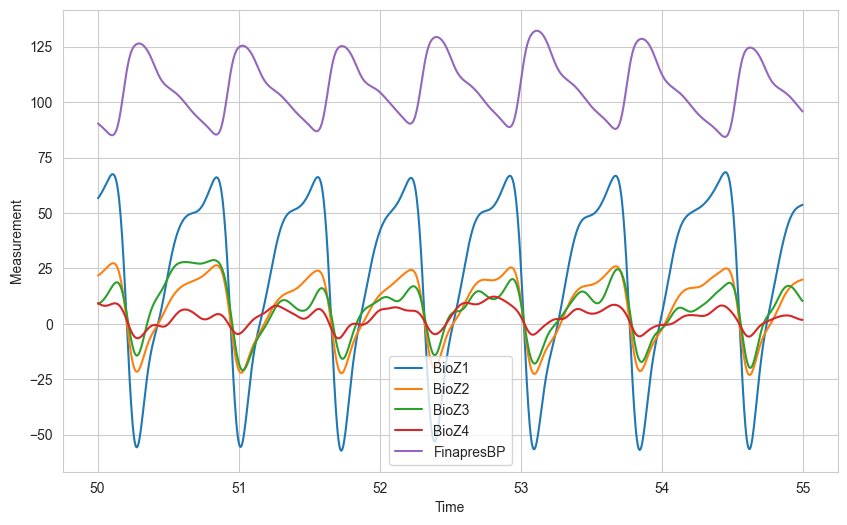

In [90]:
trial_index = (1, 1, 7)  # The selected trial
plot_alignment(df, aligned_df, trial_index, 50, 55)

This one works quite well, most of the metrics are lined up.

Before Alignment


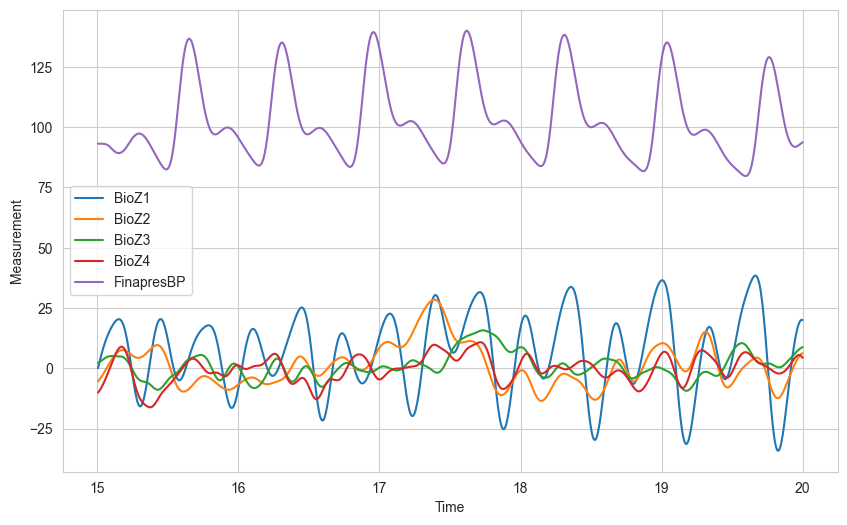

After Alignment


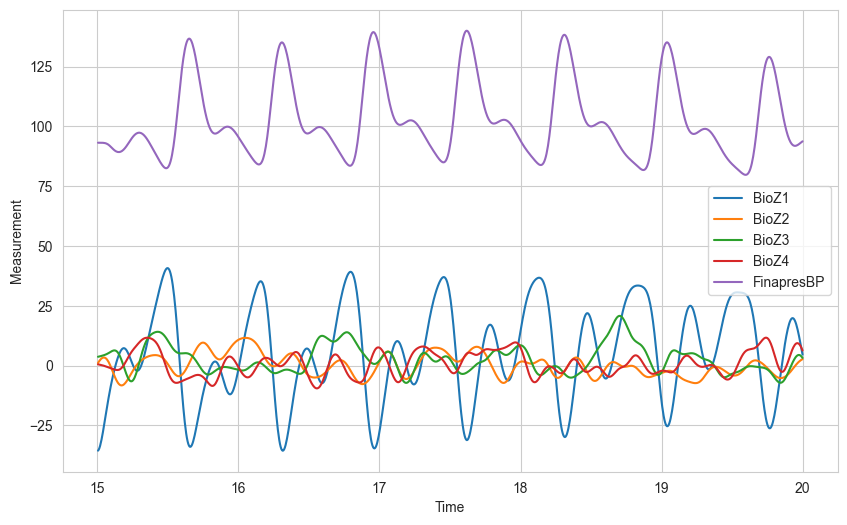

In [91]:
trial_index = (2, 1, 40)
plot_alignment(df, aligned_df, trial_index, 15, 20)

Over half of this series gets deleted in the shifting process.

Before Alignment


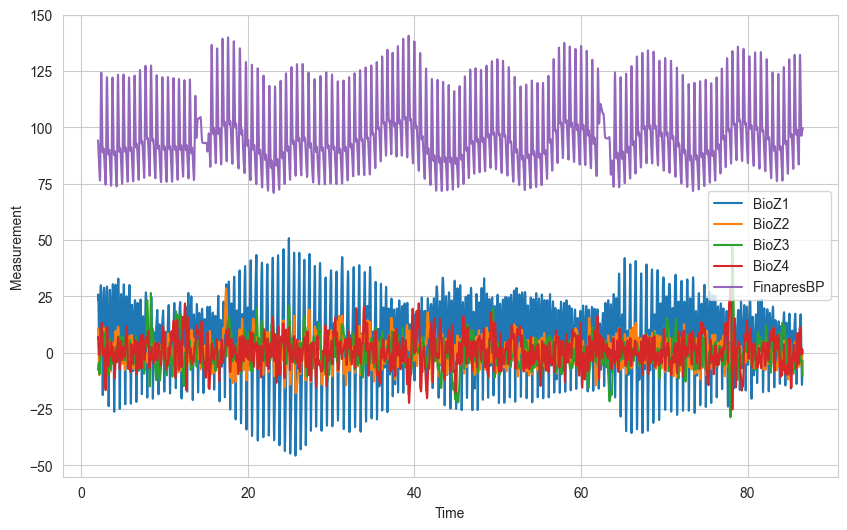

After Alignment


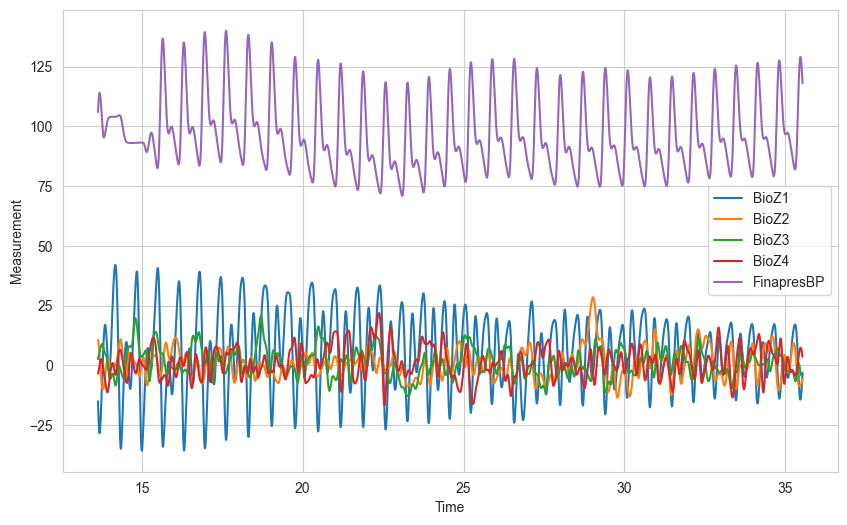

In [92]:
plot_alignment(df, aligned_df ,trial_index, 0, 100000) 

Whereas in this trial, some of the metrics are heavily shifted, and corresponding metrics are not properly aligned.

The correlation plot below also indicates that the shifting approach has not been fully successful.

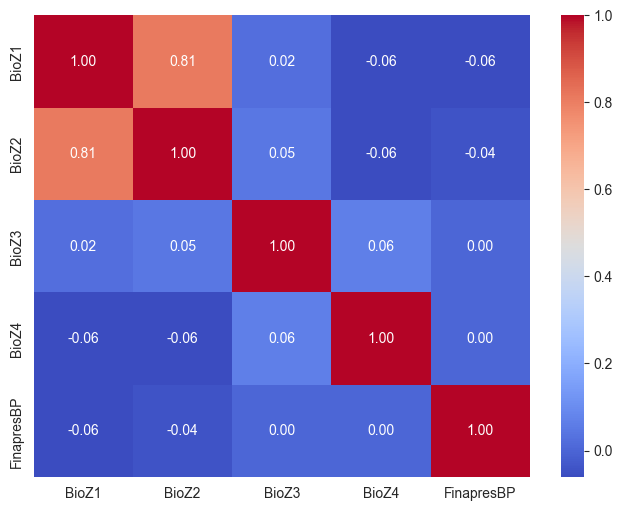

In [93]:
plot_correlation_matrix(aligned_df, columns_to_plot)

I'll see how alignment impacted the regression.

In [94]:
grouped_trials = aligned_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 12.19480215977049

Root Mean Squared Error: 15.851705740760831

R^2 Score: 0.4570902616301643


Despite the data loss the performance has improved.

> ##### **Evaluate the model on each SetupType.**

In [95]:
# for setup_type in df['SetupType'].unique():

#     setup_df = aligned_df[aligned_df['SetupType'] == setup_type]

#     grouped_trials = setup_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
#     resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
#     resampled_df.drop(columns=['level_5'], inplace=True)

#     print(setup_type)
#     train_and_evaluate_rf_regressor(resampled_df)
#     print()

`baseline`

Mean Absolute Error: 9.48368187365012

Root Mean Squared Error: 12.882895791063325

R^2 Score: 0.5987192927326632

`hgcp`

Mean Absolute Error: 11.81032384502895

Root Mean Squared Error: 15.332833186480693

R^2 Score: 0.4760535087541965

`valsalva`

Mean Absolute Error: 12.187674345679232

Root Mean Squared Error: 16.85634321043401

R^2 Score: 0.4500227669801601

`rest`

Mean Absolute Error: 10.609870631523817

Root Mean Squared Error: 13.187385496428853

R^2 Score: 0.5687826386841396

`cycling`

Mean Absolute Error: 7.657682461044513

Root Mean Squared Error: 10.884143482684596

R^2 Score: 0.6493206806103595



In their approach they did not even use subject 7.

In [96]:
align_without_7 = aligned_df[aligned_df['Subject'] != 7]
align_without_7

Subject  Day SetupType  Setup  Trial       time      BioZ1  \
0              1    1  baseline      1      1   2.000961 -38.533330   
1              1    1  baseline      1      1   2.005961 -34.658723   
2              1    1  baseline      1      1   2.010961 -30.661121   
3              1    1  baseline      1      1   2.015961 -26.593230   
4              1    1  baseline      1      1   2.020961 -22.502636   
...          ...  ...       ...    ...    ...        ...        ...   
4094154        6    1  baseline      9     40  84.939109 -56.258637   
4094155        6    1  baseline      9     40  84.944109 -55.675885   
4094156        6    1  baseline      9     40  84.949109 -54.977286   
4094157        6    1  baseline      9     40  84.954109 -54.184974   
4094158        6    1  baseline      9     40  84.959109 -53.319686   

             BioZ2      BioZ3     BioZ4  FinapresBP  
0       -14.585256 -10.377965 -3.523223   117.25990  
1       -13.120392  -8.771153 -2.842555   116.50575  
2       -11.614628  -7.086624 -2.168193   115.71514  
3       -10.087884  -5.347416 -1.504652   114.89302  
4        -8.558192  -3.576163 -0.854642   114.04378  
...            ...        ...       ...         ...  
4094154  -3.230958 -17.175198 -3.579260   133.72176  
4094155  -3.939332 -17.143401 -3.769025   135.02407  
4094156  -4.596425 -16.982308 -3.884060   136.08600  
4094157  -5.195264 -16.698044 -3.924156   136.91098  
4094158  -5.729993 -16.298069 -3.890138   137.50523  

[3745310 rows x 11 columns]

In [97]:
grouped_trials = align_without_7.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 12.097742898133276

Root Mean Squared Error: 15.761084238872646

R^2 Score: 0.4552836579299263

> ##### **Local Cross-Correlation Only**

Some of the alignment process looks to be incorrect, and measurements are getting drastically shifted.

In reality a BioZ metric should not be misaligned by more than a second or so.

I am going to alter the cross correlation function to only examine the local alignment so that less data is lost.

In [98]:
def local_cross_correlate(series1, series2, plot=False):

    # Normalise the series, as they each have different scales
    series1 = (series1 - np.mean(series1)) / (np.std(series1))
    series2 = (series2 - np.mean(series2)) / (np.std(series2))
    lags = np.arange(-200, 201)  # Only shift by a second
    cross_correlation = correlate(series1, series2, mode='full')

    # This only examines shifts of +- a second
    local_cross_correlation = cross_correlation[len(cross_correlation)//2-200:len(cross_correlation)//2+201]

    # Find the lag with the maximum correlation
    lag_max = lags[local_cross_correlation.argmax()]

    # Calculate the length of the misalignment in time
    time_difference = np.diff(bp_df['time'])
    average_delta_time = np.mean(time_difference)
    lag_time = lag_max * average_delta_time

    if plot:
        # Plot cross-correlation
        plt.figure(figsize=(10, 5))
        plt.plot(lags, cross_correlation)
        plt.title('Cross-correlation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation coefficient')
        plt.axvline(x=lag_max, color='r', linestyle='--')
        # plt.xlim(-100, 100)
        plt.show()

        print(f"The maximum correlation is at lag {lag_max}, which equates to {lag_time:.4f} seconds.")

    return lag_max

In [99]:
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

for trial_name, trial in grouped_trials:

    # Show the alignment of FinapresBP and BioZ
    print(f'Trial: {trial_name}')
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ1']))
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ2']))
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ3']))
    print(local_cross_correlate(trial['FinapresBP'], -1*trial['BioZ4']))
    print()

Trial: (1, 1, 1)
-30
-30
-25
-29

Trial: (1, 1, 2)
-30
-30
-24
-28

Trial: (1, 1, 3)
-31
-31
-26
-30

Trial: (1, 1, 4)
-32
-32
-26
-31

Trial: (1, 1, 5)
-29
-30
-23
-30

Trial: (1, 1, 6)
-31
-32
-28
-30

Trial: (1, 1, 7)
-30
-30
-26
-29

Trial: (1, 1, 8)
-28
-27
133
-23

Trial: (1, 1, 9)
-29
-28
122
-23

Trial: (1, 1, 10)
-28
-27
-198
-26

Trial: (1, 1, 11)
-29
-29
71
-25

Trial: (1, 1, 12)
-28
-27
-110
-23

Trial: (1, 1, 13)
-29
-29
18
-33

Trial: (1, 1, 14)
-30
-30
-45
-34

Trial: (1, 1, 15)
-29
-29
174
-28

Trial: (1, 1, 16)
-29
-29
121
-30

Trial: (1, 1, 17)
-28
-28
106
-29

Trial: (1, 1, 18)
-32
-31
-29
-33

Trial: (1, 1, 19)
-32
-32
-28
-32

Trial: (1, 1, 20)
-31
-31
-28
-31

Trial: (1, 1, 21)
-31
-31
-29
-31

Trial: (1, 1, 22)
-31
-31
-29
-32

Trial: (1, 1, 23)
-32
-30
-27
-31

Trial: (1, 1, 24)
-32
-31
-26
-34

Trial: (1, 1, 25)
-31
-29
-25
-30

Trial: (1, 1, 26)
-30
-28
-23
-30

Trial: (1, 1, 27)
-31
-29
-24
-30

Trial: (1, 1, 28)
-32
-31
-27
-36

Trial: (1, 1, 29)
-32
-33
-28

In [100]:
def local_align_group(group):
    aligned_group = group.copy() # Copy to avoid modifying the original dataframe
    
    for bioz_column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        shift_value = local_cross_correlate(aligned_group['FinapresBP'], -1 * aligned_group[bioz_column])
        aligned_group[bioz_column] = aligned_group[bioz_column].shift(shift_value)
    
    return aligned_group

# Group each trial
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

# Apply the function to each group and combine the results
aligned_df = grouped_trials.apply(local_align_group).reset_index(drop=True)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\38334970.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = grouped_trials.apply(local_align_group).reset_index(drop=True)


In [101]:
show_bioz_shift()
aligned_df = aligned_df.dropna()

Shift


BioZ1    10452
BioZ2    11488
BioZ3    12538
BioZ4    11571
dtype: int64

Average Shift Per Trial


BioZ1    42.661224
BioZ2    46.889796
BioZ3    51.175510
BioZ4    47.228571
dtype: float64

In [102]:
print(f"Rows Dropped: {len(df) - len(aligned_df)}")
print(f"Trial Count: {len(aligned_df[['Subject', 'Day', 'Trial']].drop_duplicates())}")

Rows Dropped: 19340
Trial Count: 245


Before Alignment


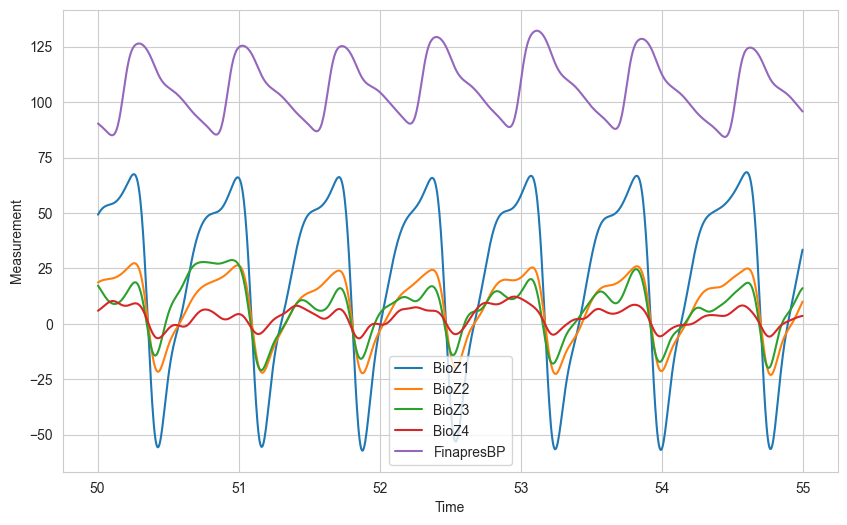

After Alignment


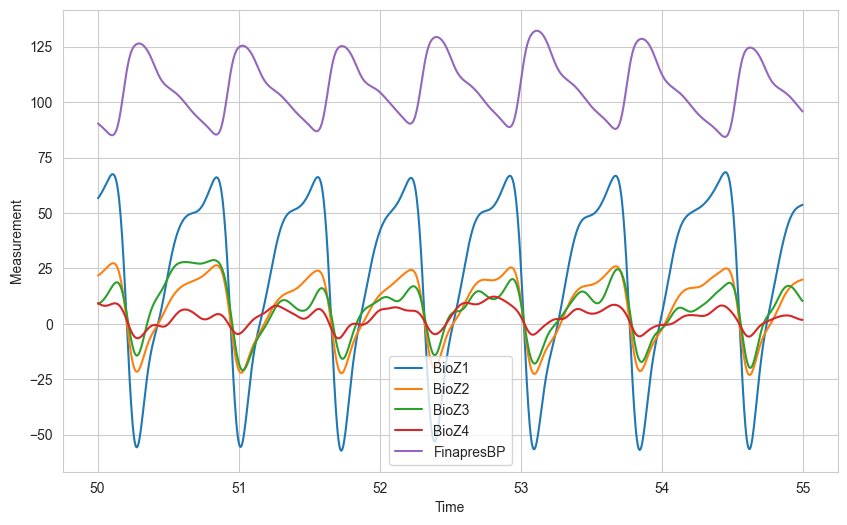

In [103]:
trial_index = (1, 1, 7)  # The selected trial

plot_alignment(df, aligned_df, trial_index, 50, 55)

The alignment remains good here.

Before Alignment


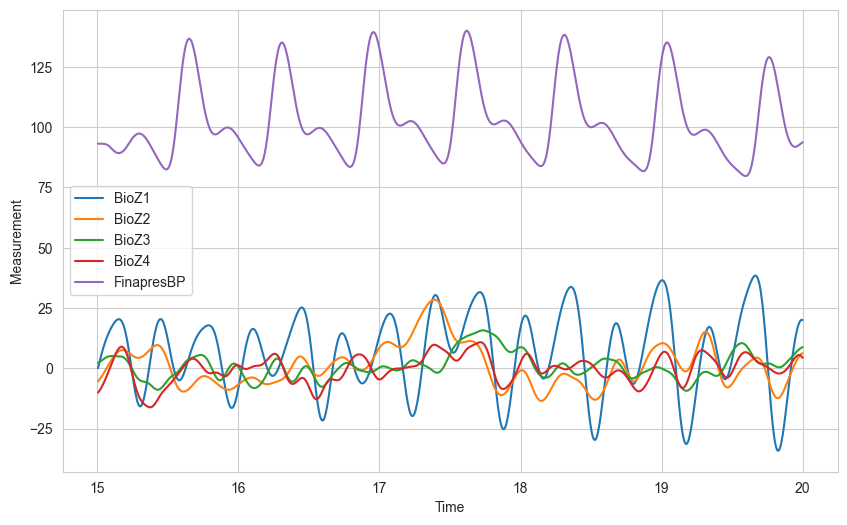

After Alignment


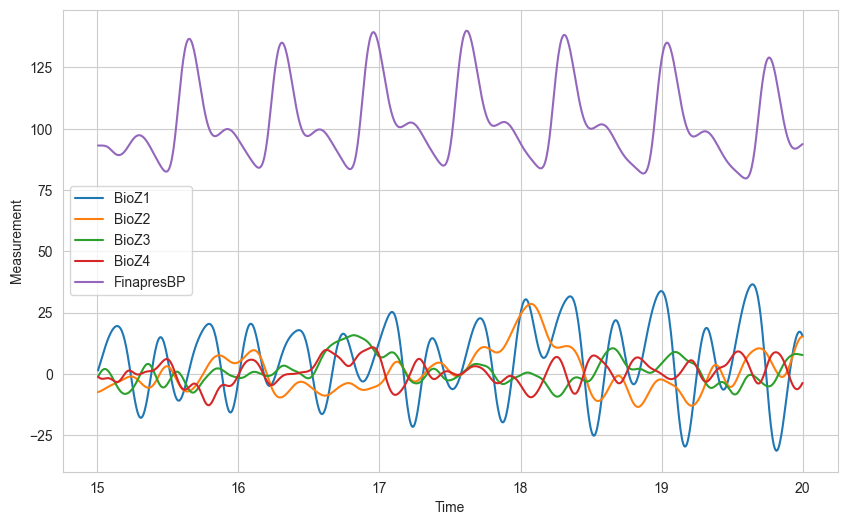

Before Alignment


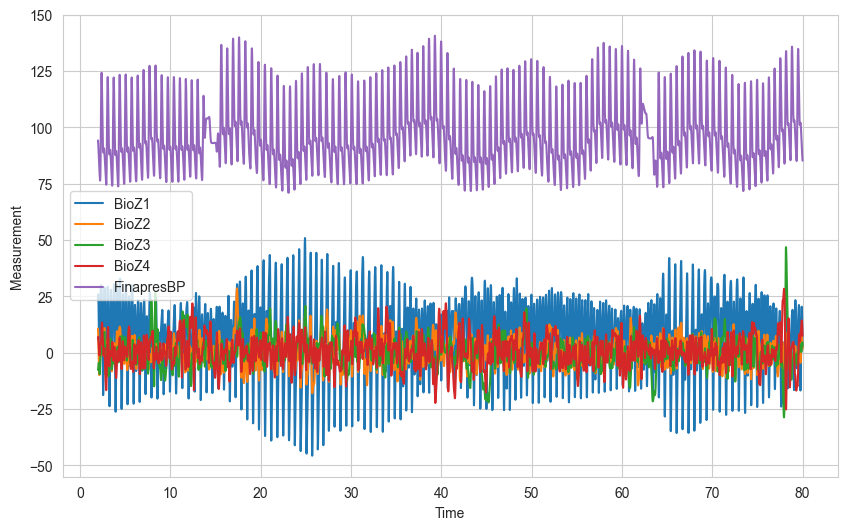

After Alignment


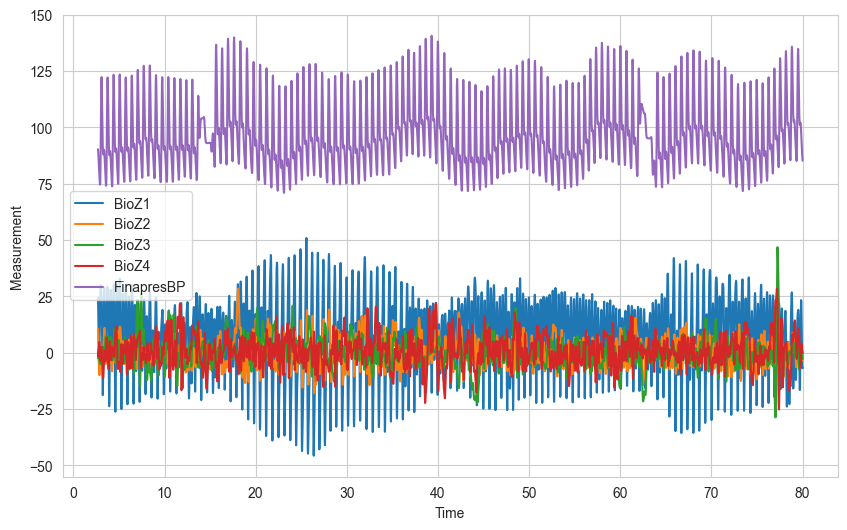

In [104]:
trial_index = (2, 1, 40)

plot_alignment(df, aligned_df, trial_index, 15, 20)

plot_alignment(df, aligned_df, trial_index, 0, 80)

While the series are less less obviously aligned, the majority of the data is kept.

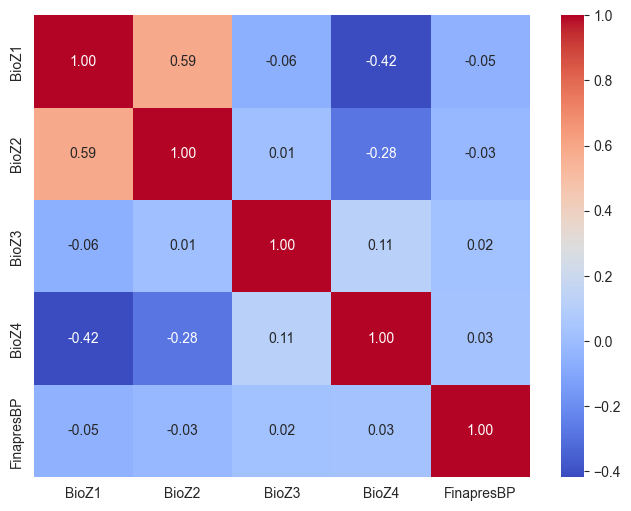

In [105]:
plot_correlation_matrix(aligned_df, columns_to_plot)

In [106]:
grouped_trials = aligned_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 12.13854340045295

Root Mean Squared Error: 15.848744939726487

R^2 Score: 0.45056437670248484

The metrics are very similar.

> #####  **Move FinapresBP to BioZ1**

One problem with this approach is that in deployement scenarios where BP is unknown, there will be no known position to shift the BioZ metrics to.

Additionally I want to create features that rely on the relationship between the BioZ, these cannot be created if they are fully aligned.

So for now I will shift FinapresBP to BioZ1 as it has the smallest average shift.

In [107]:
def shift_bp_to_bioz1(group):
    aligned_group = group.copy() # Copy to avoid modifying the original dataframe
    
    shift_value = -1 * local_cross_correlate(aligned_group['FinapresBP'], -1 * aligned_group['BioZ1'])
    aligned_group['FinapresBP'] = aligned_group['FinapresBP'].shift(shift_value)
    
    return aligned_group

# Group each trial
grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])

# Apply the function to each group and combine the results
aligned_df = grouped_trials.apply(shift_bp_to_bioz1).reset_index(drop=True)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\1668625305.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = grouped_trials.apply(shift_bp_to_bioz1).reset_index(drop=True)


In [108]:
aligned_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.000961  48.332439   
1              1    1  baseline      1      1    2.005961  43.384880   
2              1    1  baseline      1      1    2.010961  37.969078   
3              1    1  baseline      1      1    2.015961  32.123190   
4              1    1  baseline      1      1    2.020961  25.896649   
...          ...  ...       ...    ...    ...         ...        ...   
4206678        7    1   cycling      1      3  188.974952 -12.991598   
4206679        7    1   cycling      1      3  188.979952 -11.185842   
4206680        7    1   cycling      1      3  188.984952  -9.428160   
4206681        7    1   cycling      1      3  188.989952  -7.727173   
4206682        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  
0        16.943260   4.337878   4.415633         NaN  
1        15.087782   2.756093   3.484722         NaN  
2        13.056467   1.085794   2.508537         NaN  
3        10.864834  -0.655107   1.496772         NaN  
4         8.532647  -2.445484   0.460766         NaN  
...            ...        ...        ...         ...  
4206678  -1.507162 -19.132283 -19.132283    78.16795  
4206679  -1.269116 -18.493100 -18.493100    77.75340  
4206680  -1.026987 -17.864842 -17.864842    77.34540  
4206681  -0.781154 -17.252701 -17.252701    76.94324  
4206682  -0.531917 -16.661449 -16.661449    76.54224  

[4206683 rows x 11 columns]

In [109]:
print('Shift')
display(aligned_df['FinapresBP'].isna().sum())
print('Average Shift Per Trial')
display(aligned_df['FinapresBP'].isna().sum() / len(df.groupby(['Subject', 'Day', 'Trial'])))  # Average shift per trial
aligned_df = aligned_df.dropna()

Shift


10452

Average Shift Per Trial


42.66122448979592

Before Alignment


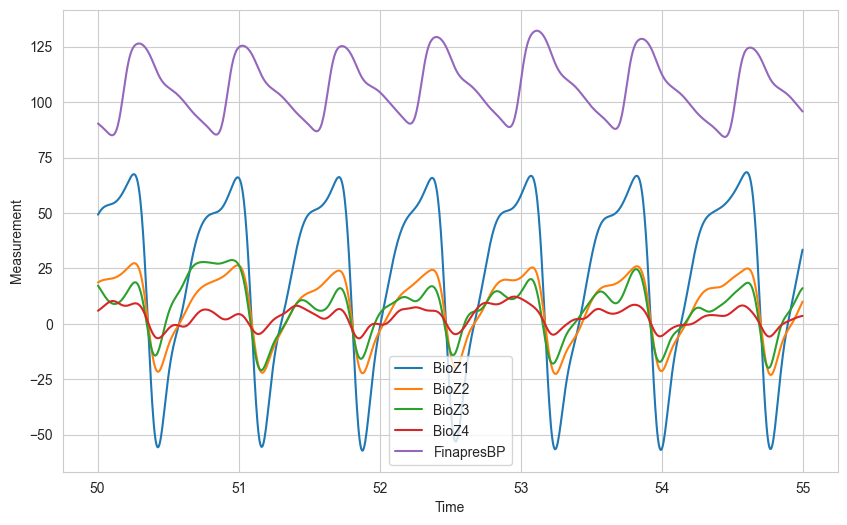

After Alignment


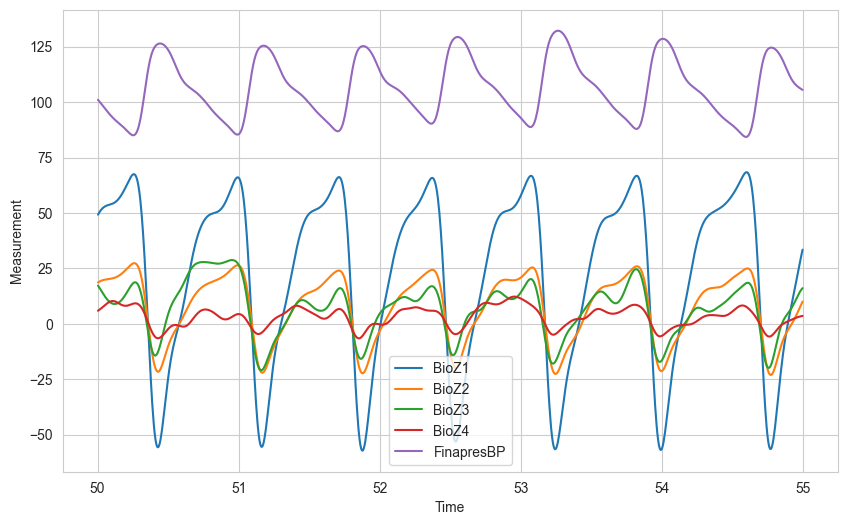

In [110]:
trial_index = (1, 1, 7)  # The selected trial

plot_alignment(df, aligned_df, trial_index, 50, 55)

In [111]:
grouped_trials = aligned_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 12.107742101104279

Root Mean Squared Error: 15.767083424728185

R^2 Score: 0.45926273486740354


This is slighly better.

>##### **Scaling the BioZ**

The cross correlation showed that scaling the BioZ can yield more information, it might be useful to normalise the BioZ within each trial.

In [112]:
from sklearn.preprocessing import StandardScaler

def scale_group(group):
    scaler = StandardScaler()  # Create a new scaler for each group to avoid data leakage
    
    bioz_columns = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']
    group[bioz_columns] = scaler.fit_transform(group[bioz_columns])  # Scale the BioZ columns
    
    return group


grouped_trials = df.groupby(['Subject', 'Day', 'Trial'])
# Apply the scaling function to each trial independently
scaled_df = grouped_trials.apply(scale_group).reset_index(drop=True)
scaled_df

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\3092188875.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scaled_df = grouped_trials.apply(scale_group).reset_index(drop=True)


Subject  Day SetupType  Setup  Trial        time     BioZ1     BioZ2  \
0              1    1  baseline      1      1    2.000961  0.571303  0.523882   
1              1    1  baseline      1      1    2.005961  0.457664  0.410335   
2              1    1  baseline      1      1    2.010961  0.333269  0.286026   
3              1    1  baseline      1      1    2.015961  0.198996  0.151907   
4              1    1  baseline      1      1    2.020961  0.055980  0.009187   
...          ...  ...       ...    ...    ...         ...       ...       ...   
4206678        7    1   cycling      1      3  188.974952 -0.359721 -0.028496   
4206679        7    1   cycling      1      3  188.979952 -0.326422 -0.021748   
4206680        7    1   cycling      1      3  188.984952 -0.294010 -0.014883   
4206681        7    1   cycling      1      3  188.989952 -0.262642 -0.007914   
4206682        7    1   cycling      1      3  188.994952 -0.232453 -0.000849   

            BioZ3     BioZ4  FinapresBP  
0       -0.310035  0.218459   117.25990  
1       -0.411463  0.065432   116.50575  
2       -0.518567 -0.095038   115.71514  
3       -0.630198 -0.261357   114.89302  
4       -0.745002 -0.431661   114.04378  
...           ...       ...         ...  
4206678 -0.226807 -0.226807    67.67920  
4206679 -0.219458 -0.219458    67.50756  
4206680 -0.212235 -0.212235    67.33915  
4206681 -0.205197 -0.205197    67.17298  
4206682 -0.198399 -0.198399    67.00795  

[4206683 rows x 11 columns]

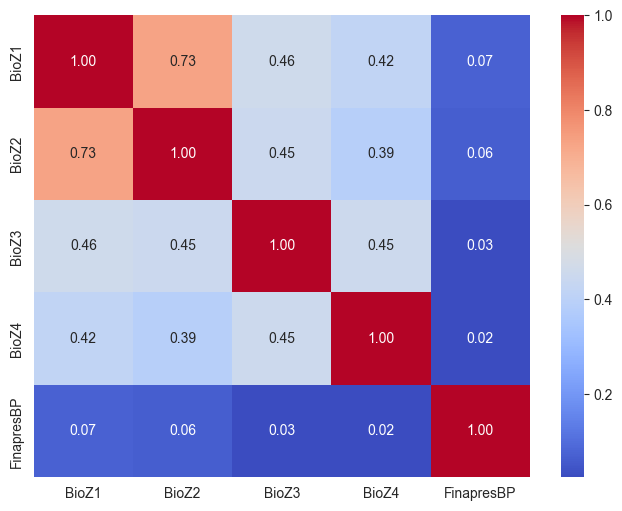

In [113]:
plot_correlation_matrix(scaled_df, columns_to_plot)

In [114]:
grouped_trials = scaled_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 16.11444779470958

Root Mean Squared Error: 20.506950604123556

R^2 Score: 0.07892075297557721


This is slightly worse than the raw unaligned series.

In [115]:
grouped_trials = aligned_df.groupby(['Subject', 'Day', 'Trial'])

# Apply the scaling function to each trial independently
scaled_aligned_df = grouped_trials.apply(scale_group).reset_index(drop=True)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\2372416990.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scaled_aligned_df = grouped_trials.apply(scale_group).reset_index(drop=True)


In [116]:
scaled_aligned_df

Subject  Day SetupType  Setup  Trial        time     BioZ1     BioZ2  \
0              1    1  baseline      1      1    2.150961 -1.426844 -1.408522   
1              1    1  baseline      1      1    2.155961 -1.337785 -1.318813   
2              1    1  baseline      1      1    2.160961 -1.245898 -1.226598   
3              1    1  baseline      1      1    2.165961 -1.152396 -1.133099   
4              1    1  baseline      1      1    2.170961 -1.058373 -1.039419   
...          ...  ...       ...    ...    ...         ...       ...       ...   
4196226        7    1   cycling      1      3  188.974952 -0.358221 -0.029198   
4196227        7    1   cycling      1      3  188.979952 -0.324856 -0.022430   
4196228        7    1   cycling      1      3  188.984952 -0.292379 -0.015546   
4196229        7    1   cycling      1      3  188.989952 -0.260950 -0.008556   
4196230        7    1   cycling      1      3  188.994952 -0.230701 -0.001470   

            BioZ3     BioZ4  FinapresBP  
0       -0.705871 -0.977864   117.25990  
1       -0.592092 -0.866905   116.50575  
2       -0.480043 -0.757727   115.71514  
3       -0.370765 -0.650776   114.89302  
4       -0.265168 -0.546216   114.04378  
...           ...       ...         ...  
4196226 -0.227100 -0.227100    78.16795  
4196227 -0.219725 -0.219725    77.75340  
4196228 -0.212477 -0.212477    77.34540  
4196229 -0.205414 -0.205414    76.94324  
4196230 -0.198592 -0.198592    76.54224  

[4196231 rows x 11 columns]

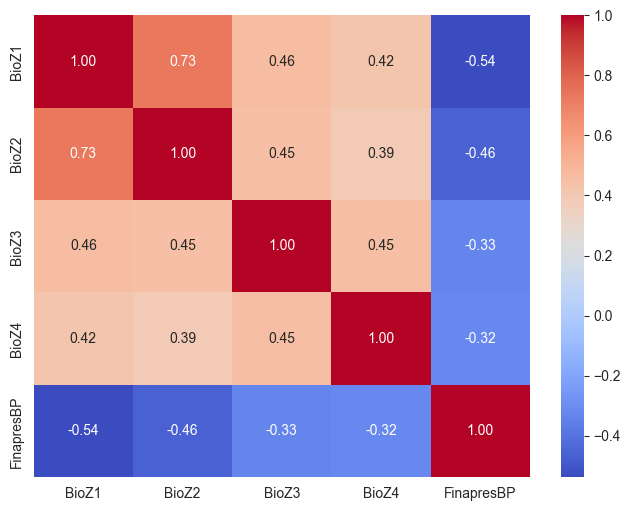

In [117]:
plot_correlation_matrix(scaled_aligned_df, columns_to_plot)

The blood pressure metrics now have quite a prominent correlation with FinapresBP.

In [118]:
grouped_trials = scaled_aligned_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)
# train_and_evaluate_rf_regressor(resampled_df)

Mean Absolute Error: 13.221893249264195

Root Mean Squared Error: 16.87519817171641

R^2 Score: 0.3805855502462474

Despite the increased correlation, the performance is worse, probably because scaling only informs the model of the relative BioZ fluctuations within a sample.

I'll try giving the model the raw and scaled BioZ.

In [119]:
scaled_and_raw_df = aligned_df.merge(scaled_aligned_df.drop(columns='FinapresBP'), on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'time'], how='left', suffixes=('', '_scaled'))
scaled_and_raw_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196226        7    1   cycling      1      3  188.974952 -12.991598   
4196227        7    1   cycling      1      3  188.979952 -11.185842   
4196228        7    1   cycling      1      3  188.984952  -9.428160   
4196229        7    1   cycling      1      3  188.989952  -7.727173   
4196230        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  BioZ1_scaled  \
0       -14.585256  -1.794075  -2.842555   117.25990     -1.426844   
1       -13.120392  -0.020793  -2.168193   116.50575     -1.337785   
2       -11.614628   1.725522  -1.504652   115.71514     -1.245898   
3       -10.087884   3.428648  -0.854642   114.89302     -1.152396   
4        -8.558192   5.074413  -0.219169   114.04378     -1.058373   
...            ...        ...        ...         ...           ...   
4196226  -1.507162 -19.132283 -19.132283    78.16795     -0.358221   
4196227  -1.269116 -18.493100 -18.493100    77.75340     -0.324856   
4196228  -1.026987 -17.864842 -17.864842    77.34540     -0.292379   
4196229  -0.781154 -17.252701 -17.252701    76.94324     -0.260950   
4196230  -0.531917 -16.661449 -16.661449    76.54224     -0.230701   

         BioZ2_scaled  BioZ3_scaled  BioZ4_scaled  
0           -1.408522     -0.705871     -0.977864  
1           -1.318813     -0.592092     -0.866905  
2           -1.226598     -0.480043     -0.757727  
3           -1.133099     -0.370765     -0.650776  
4           -1.039419     -0.265168     -0.546216  
...               ...           ...           ...  
4196226     -0.029198     -0.227100     -0.227100  
4196227     -0.022430     -0.219725     -0.219725  
4196228     -0.015546     -0.212477     -0.212477  
4196229     -0.008556     -0.205414     -0.205414  
4196230     -0.001470     -0.198592     -0.198592  

[4196231 rows x 15 columns]

In [120]:
grouped_trials = scaled_and_raw_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial'])
resampled_df = grouped_trials.apply(resample_group, '50ms').reset_index()
resampled_df.drop(columns=['level_5'], inplace=True)

features = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'BioZ1_scaled', 'BioZ2_scaled', 'BioZ3_scaled', 'BioZ4_scaled']
# train_and_evaluate_rf_regressor(resampled_df, features=features)

Mean Absolute Error: 9.89199432543567

Root Mean Squared Error: 13.264563681249546

R^2 Score: 0.617290266971255


This is much more promising.

---

### **2. Beat Extraction and Feature Engineering**

I am going to focus on regression models to predict beatwise Systolic, Diastolic and Mean Arterial Pressure.

I will also compare the use of **K-Fold** cross-validation against **LeavePGroupsOut** validation, to show how KFold can cause data leakage and overestimate model performance.

### **2.1 Extracting Beats.**

First beats will have to be extracted from each trial.

In [121]:
scaled_and_raw_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196226        7    1   cycling      1      3  188.974952 -12.991598   
4196227        7    1   cycling      1      3  188.979952 -11.185842   
4196228        7    1   cycling      1      3  188.984952  -9.428160   
4196229        7    1   cycling      1      3  188.989952  -7.727173   
4196230        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  BioZ1_scaled  \
0       -14.585256  -1.794075  -2.842555   117.25990     -1.426844   
1       -13.120392  -0.020793  -2.168193   116.50575     -1.337785   
2       -11.614628   1.725522  -1.504652   115.71514     -1.245898   
3       -10.087884   3.428648  -0.854642   114.89302     -1.152396   
4        -8.558192   5.074413  -0.219169   114.04378     -1.058373   
...            ...        ...        ...         ...           ...   
4196226  -1.507162 -19.132283 -19.132283    78.16795     -0.358221   
4196227  -1.269116 -18.493100 -18.493100    77.75340     -0.324856   
4196228  -1.026987 -17.864842 -17.864842    77.34540     -0.292379   
4196229  -0.781154 -17.252701 -17.252701    76.94324     -0.260950   
4196230  -0.531917 -16.661449 -16.661449    76.54224     -0.230701   

         BioZ2_scaled  BioZ3_scaled  BioZ4_scaled  
0           -1.408522     -0.705871     -0.977864  
1           -1.318813     -0.592092     -0.866905  
2           -1.226598     -0.480043     -0.757727  
3           -1.133099     -0.370765     -0.650776  
4           -1.039419     -0.265168     -0.546216  
...               ...           ...           ...  
4196226     -0.029198     -0.227100     -0.227100  
4196227     -0.022430     -0.219725     -0.219725  
4196228     -0.015546     -0.212477     -0.212477  
4196229     -0.008556     -0.205414     -0.205414  
4196230     -0.001470     -0.198592     -0.198592  

[4196231 rows x 15 columns]

I will use the find_peaks method to create a dataset of heartbeats and their reprsentative features, like in the paper.

I'll define a beat as the range between two diastolic troughs/bioZ peaks.

I used BioZ1 due to its relatively high correlation with FinapresBP, especially when scaled.

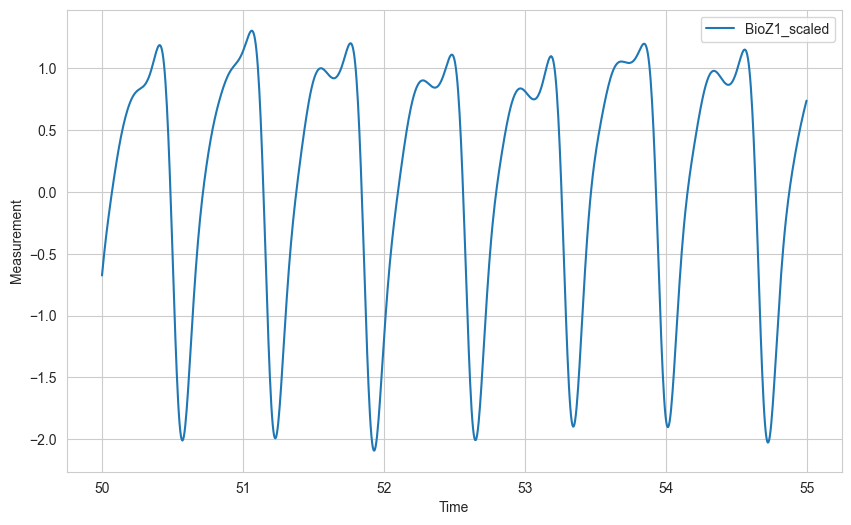

In [122]:
columns_to_plot = ['BioZ1_scaled']
trial_index = (1, 1, 1)

grouped_trials = scaled_and_raw_df.groupby(['Subject', 'Day', 'Trial'])
trial = grouped_trials.get_group(trial_index)
plot_measurements(trial, 50, 55)

Setting the distance parameters to 100 appeared to yield the most accurate heartbeats, when examined on several sample.

In [123]:
def find_peaks_and_assign_beat_id(group):

    # Find diastolic peaks and BioZ is inverted
    diastolic_peaks, _ = find_peaks(group['BioZ1_scaled'], distance=100)  # Peaks have to be half a second a part minimum.
    
    # Initialise a column for beat IDs
    group['beat_id'] = 0

    # Assign beat IDs
    for i, trough_idx in enumerate(diastolic_peaks):
        if i == 0:
            # Assign beat_id for records before the first trough
            group.iloc[:trough_idx+1, group.columns.get_loc('beat_id')] = i + 1
        else:
            # Assign beat_id for records between the current trough and the previous one
            prev_trough_idx = diastolic_peaks[i - 1]
            group.iloc[prev_trough_idx+1:trough_idx+1, group.columns.get_loc('beat_id')] = i + 1

    # Handle tail records after the last trough
    if len(diastolic_peaks) > 0:
        group.iloc[diastolic_peaks[-1]+1:, group.columns.get_loc('beat_id')] = len(diastolic_peaks) + 1

    return group
    
# Group each trial
grouped_trials = scaled_and_raw_df.groupby(['Subject', 'Day', 'Trial'])

# Apply the function to each group and combine the results
beat_df = grouped_trials.apply(find_peaks_and_assign_beat_id).reset_index(drop=True)

average_beats_per_trial = beat_df.groupby(['Subject', 'Day', 'Trial'])['beat_id'].nunique().mean()
print(f"Average Beats Per Trial: {average_beats_per_trial:.4f}")

average_beats_per_subject = len(beat_df[beat_df['Subject']!=7].groupby(['Subject', 'Day', 'Trial', 'beat_id'])) / 6
print(f"Average Beats Per Subject (Excluding 7): {average_beats_per_subject}")
beat_df

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\1401189398.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  beat_df = grouped_trials.apply(find_peaks_and_assign_beat_id).reset_index(drop=True)


Average Beats Per Trial: 114.5102
Average Beats Per Subject (Excluding 7): 4562.0


Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196226        7    1   cycling      1      3  188.974952 -12.991598   
4196227        7    1   cycling      1      3  188.979952 -11.185842   
4196228        7    1   cycling      1      3  188.984952  -9.428160   
4196229        7    1   cycling      1      3  188.989952  -7.727173   
4196230        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  BioZ1_scaled  \
0       -14.585256  -1.794075  -2.842555   117.25990     -1.426844   
1       -13.120392  -0.020793  -2.168193   116.50575     -1.337785   
2       -11.614628   1.725522  -1.504652   115.71514     -1.245898   
3       -10.087884   3.428648  -0.854642   114.89302     -1.152396   
4        -8.558192   5.074413  -0.219169   114.04378     -1.058373   
...            ...        ...        ...         ...           ...   
4196226  -1.507162 -19.132283 -19.132283    78.16795     -0.358221   
4196227  -1.269116 -18.493100 -18.493100    77.75340     -0.324856   
4196228  -1.026987 -17.864842 -17.864842    77.34540     -0.292379   
4196229  -0.781154 -17.252701 -17.252701    76.94324     -0.260950   
4196230  -0.531917 -16.661449 -16.661449    76.54224     -0.230701   

         BioZ2_scaled  BioZ3_scaled  BioZ4_scaled  beat_id  
0           -1.408522     -0.705871     -0.977864        1  
1           -1.318813     -0.592092     -0.866905        1  
2           -1.226598     -0.480043     -0.757727        1  
3           -1.133099     -0.370765     -0.650776        1  
4           -1.039419     -0.265168     -0.546216        1  
...               ...           ...           ...      ...  
4196226     -0.029198     -0.227100     -0.227100      255  
4196227     -0.022430     -0.219725     -0.219725      255  
4196228     -0.015546     -0.212477     -0.212477      255  
4196229     -0.008556     -0.205414     -0.205414      255  
4196230     -0.001470     -0.198592     -0.198592      255  

[4196231 rows x 16 columns]

The average beats per subject is a much larger than the 2500±600 beats they mention in the paper, but I could not find any other parameters that would reduce the beat count, without excluding obvious beats.

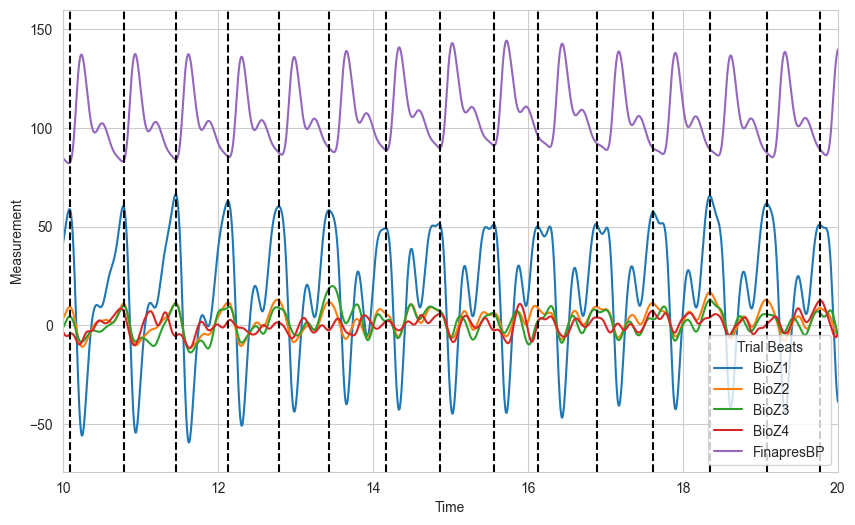

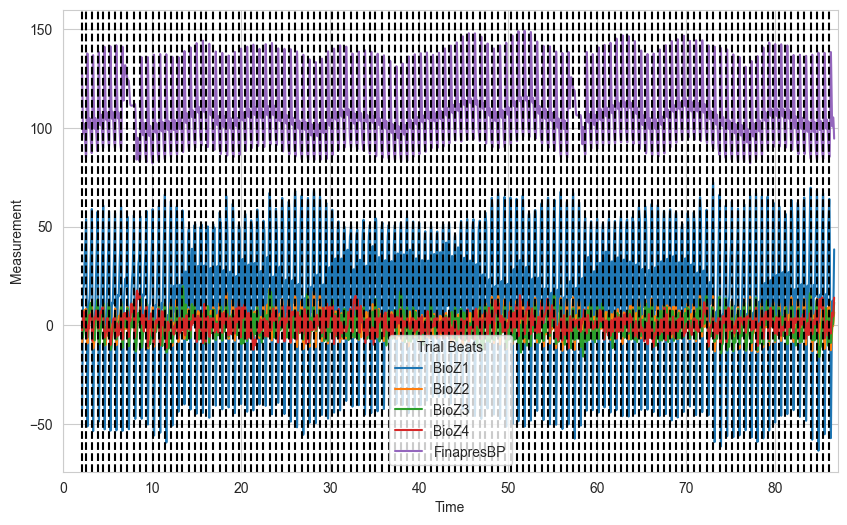

In [124]:
def plot_beats(trial, start_time, end_time):

    # Create the plot
    plt.figure(figsize=(10, 6))

    for column in columns_to_plot:
        sns.lineplot(data=trial, x='time', y=column, label=column)

    # Find change points in beat_id and get corresponding 'time' values
    change_points = trial['beat_id'].diff() != 0
    change_times = trial['time'][change_points]

    # Draw vertical lines at change points
    for cp_time in change_times:
        plt.axvline(x=cp_time, color='k', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Measurement')
    plt.legend(title='Trial Beats')

    plt.xlim(start_time, end_time)

    plt.show()

columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP']

trial_index = (2, 1, 27)
grouped_trials = beat_df.groupby(['Subject', 'Day', 'Trial'])
trial = grouped_trials.get_group(trial_index)

plot_beats(trial, 10, 20)
plot_beats(trial, 0, 87)

### **2.2 Feature Engineering.**

Now I will aggregate by heartbeat and create representative features.

For each BioZ signal I am to extract the 4 characteristic points mentioned in the study. There are other features in the [github](https://github.com/TAMU-ESP/Graphene_BP/tree/main/Data/features/2020-11-05) that have no description, so I cannot replicate them.

1. diastolic peak (DIA)

2. maximum slope (MS)

3. systolic foot (SYS)

4.  inflection point (IP)

I will also engineer some statistical features.

In [125]:
# backup = beat_df.copy()

In [126]:
# beat_df = backup

In [127]:
beat_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196226        7    1   cycling      1      3  188.974952 -12.991598   
4196227        7    1   cycling      1      3  188.979952 -11.185842   
4196228        7    1   cycling      1      3  188.984952  -9.428160   
4196229        7    1   cycling      1      3  188.989952  -7.727173   
4196230        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  BioZ1_scaled  \
0       -14.585256  -1.794075  -2.842555   117.25990     -1.426844   
1       -13.120392  -0.020793  -2.168193   116.50575     -1.337785   
2       -11.614628   1.725522  -1.504652   115.71514     -1.245898   
3       -10.087884   3.428648  -0.854642   114.89302     -1.152396   
4        -8.558192   5.074413  -0.219169   114.04378     -1.058373   
...            ...        ...        ...         ...           ...   
4196226  -1.507162 -19.132283 -19.132283    78.16795     -0.358221   
4196227  -1.269116 -18.493100 -18.493100    77.75340     -0.324856   
4196228  -1.026987 -17.864842 -17.864842    77.34540     -0.292379   
4196229  -0.781154 -17.252701 -17.252701    76.94324     -0.260950   
4196230  -0.531917 -16.661449 -16.661449    76.54224     -0.230701   

         BioZ2_scaled  BioZ3_scaled  BioZ4_scaled  beat_id  
0           -1.408522     -0.705871     -0.977864        1  
1           -1.318813     -0.592092     -0.866905        1  
2           -1.226598     -0.480043     -0.757727        1  
3           -1.133099     -0.370765     -0.650776        1  
4           -1.039419     -0.265168     -0.546216        1  
...               ...           ...           ...      ...  
4196226     -0.029198     -0.227100     -0.227100      255  
4196227     -0.022430     -0.219725     -0.219725      255  
4196228     -0.015546     -0.212477     -0.212477      255  
4196229     -0.008556     -0.205414     -0.205414      255  
4196230     -0.001470     -0.198592     -0.198592      255  

[4196231 rows x 16 columns]

In [128]:
print(f"Number of identified beats: {len(beat_df[['Subject', 'Day', 'Trial', 'beat_id']].drop_duplicates())}")

Number of identified beats: 28055


Their dataset has 29809 beats, however this is most likely due to the different outlier removal process that they used.

For now I will just use the max and min of each BioZ, representing the diastolic peak and systolic foot.

In [129]:
beats_featureset = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).agg(
    SBP=('FinapresBP', 'max'),
    DBP=('FinapresBP', 'min'),
    BioZ1_max=('BioZ1', 'max'),
    BioZ1_min=('BioZ1', 'min'),
    BioZ2_max=('BioZ2', 'max'),
    BioZ2_min=('BioZ2', 'min'),
    BioZ3_max=('BioZ3', 'max'),
    BioZ3_min=('BioZ3', 'min'),
    BioZ4_max=('BioZ4', 'max'),
    BioZ4_min=('BioZ4', 'min')
)
beats_featureset = beats_featureset.reset_index()
beats_featureset

Subject  Day SetupType  Setup  Trial  beat_id        SBP       DBP  \
0            1    1  baseline      1      1        1  117.25990  76.80046   
1            1    1  baseline      1      1        2  122.55184  77.18544   
2            1    1  baseline      1      1        3  120.97179  78.52657   
3            1    1  baseline      1      1        4  120.85991  79.28472   
4            1    1  baseline      1      1        5  124.12496  81.43557   
...        ...  ...       ...    ...    ...      ...        ...       ...   
28050        7    1   cycling      1      3      251  107.57491  61.24011   
28051        7    1   cycling      1      3      252  108.36449  61.35977   
28052        7    1   cycling      1      3      253  109.03478  59.62908   
28053        7    1   cycling      1      3      254  106.93446  59.63800   
28054        7    1   cycling      1      3      255  108.40677  61.85031   

       BioZ1_max  BioZ1_min  BioZ2_max  BioZ2_min  BioZ3_max  BioZ3_min  \
0      70.075224 -38.533330  25.297929 -14.585256  23.396787  -1.794075   
1      70.035225 -59.279974  27.301700 -19.190645  55.128948  -7.898597   
2      67.537739 -57.290931  26.284310 -23.096352  27.817436 -21.722032   
3      69.052129 -57.843830  26.104161 -21.131471  36.723364 -14.467875   
4      71.673083 -56.989298  29.473164 -23.833387  52.107189 -35.321958   
...          ...        ...        ...        ...        ...        ...   
28050  57.085762 -58.408243  13.567522 -12.774539  16.752971 -46.111237   
28051  66.381880 -50.563115  11.734917 -12.332475  57.527103 -14.831365   
28052  66.057551 -57.023235  11.917467 -12.836731  57.195693 -22.891389   
28053  56.879131 -63.349814  14.136994  -9.400042  20.639594 -31.973306   
28054  56.650698 -52.891189  13.485856 -12.140896  21.825693 -26.231340   

       BioZ4_max  BioZ4_min  
0      12.349296  -2.842555  
1      13.921791  -4.777848  
2      12.049014  -8.944008  
3      10.377359  -8.102217  
4      12.430341  -6.811643  
...          ...        ...  
28050  16.752971 -46.111237  
28051  57.527103 -14.831365  
28052  57.195693 -22.891389  
28053  20.639594 -31.973306  
28054  21.825693 -26.231340  

[28055 rows x 16 columns]

In [130]:
def beat_regression(df, model, target, return_model=False):
    X = df.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id', 'DBP', 'SBP'])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    print(f'Target: {target}')
    print(f'Model: {model}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2 Score: {r2}\n')

    if return_model:
        return model

In [131]:
# model = RandomForestRegressor(n_estimators=100, random_state=1234)
# beat_regression(beats_featureset, model, 'SBP')
# beat_regression(beats_featureset, model, 'DBP')

```Target: SBP```

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 9.93223926276956

Root Mean Squared Error: 13.238577584288194

R^2 Score: 0.37599612332007315

```Target: DBP```

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 8.594435035323473

Root Mean Squared Error: 11.568627819860389

R^2 Score: 0.4052479090654669



Not great.

I'll engineer some features and see how it affects things.

>##### **Interbeat Interval**

For these features I will use both the BioZ measurements and the relative timestamp.

This will require the interbeat interval, by taking the min time from the max time.

In [132]:
def calculate_interbeat_interval(group):
    interbeat_interval = (group['time'].max() - group['time'].min())
    return interbeat_interval

interbeat_interval_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(calculate_interbeat_interval).reset_index().rename(columns={0: 'InterbeatInterval'})
beat_df = pd.merge(beat_df, interbeat_interval_results, on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'], how='left')

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\1948132864.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interbeat_interval_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(calculate_interbeat_interval).reset_index().rename(columns={0: 'InterbeatInterval'})


I'll check for any beats of length 0 and drop them from the featureset.

Thankfully they come at the end of the series, so dropping them should not impact the indices.

In [133]:
display(beat_df[beat_df['InterbeatInterval'] == 0])
beat_df = beat_df[beat_df['InterbeatInterval'] != 0]

Subject  Day SetupType  Setup  Trial       time      BioZ1  \
287126         1    1      hgcp      4     17  86.592147  52.611427   
776881         1    1      hgcp     10     46  86.593387  59.351504   
1604208        2    1  valsalva      8     35  86.594872  55.877301   

             BioZ2        BioZ3     BioZ4  FinapresBP  BioZ1_scaled  \
287126   19.648406 -4292.433003  7.123673    85.36414      1.185432   
776881   16.540265    10.853795 -1.717895    95.06851      1.091163   
1604208   9.941771    -4.317404  3.235669   105.57476      1.576469   

         BioZ2_scaled  BioZ3_scaled  BioZ4_scaled  beat_id  InterbeatInterval  
287126       1.205590     -1.901640      1.254447      118                0.0  
776881       0.777638      0.046151     -0.473732      119                0.0  
1604208      1.148324     -0.109647      0.205847      119                0.0

> ##### **Calculate Mean Arterial Pressure.**

Like in the paper this is an additional target variable.

In [134]:
def calculate_map(group):
    auc = np.trapz(group['FinapresBP'], group['time'])

    mean_arterial_pressure = auc / group['InterbeatInterval'].mean()
    return mean_arterial_pressure

map_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(calculate_map).reset_index().rename(columns={0: 'MAP'})
beat_df = pd.merge(beat_df, map_results, on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'], how='left')

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\3317055361.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  map_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(calculate_map).reset_index().rename(columns={0: 'MAP'})


Redefine the function to drop MAP from the featureset.

In [135]:
def beat_regression(df, model, target, return_model=False):
    X = df.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id', 'DBP', 'SBP', 'MAP'])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    print(f'Target: {target}')
    print(f'Model: {model}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2 Score: {r2}\n')

    if return_model:
        return model

In [136]:
beat_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196223        7    1   cycling      1      3  188.974952 -12.991598   
4196224        7    1   cycling      1      3  188.979952 -11.185842   
4196225        7    1   cycling      1      3  188.984952  -9.428160   
4196226        7    1   cycling      1      3  188.989952  -7.727173   
4196227        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  FinapresBP  BioZ1_scaled  \
0       -14.585256  -1.794075  -2.842555   117.25990     -1.426844   
1       -13.120392  -0.020793  -2.168193   116.50575     -1.337785   
2       -11.614628   1.725522  -1.504652   115.71514     -1.245898   
3       -10.087884   3.428648  -0.854642   114.89302     -1.152396   
4        -8.558192   5.074413  -0.219169   114.04378     -1.058373   
...            ...        ...        ...         ...           ...   
4196223  -1.507162 -19.132283 -19.132283    78.16795     -0.358221   
4196224  -1.269116 -18.493100 -18.493100    77.75340     -0.324856   
4196225  -1.026987 -17.864842 -17.864842    77.34540     -0.292379   
4196226  -0.781154 -17.252701 -17.252701    76.94324     -0.260950   
4196227  -0.531917 -16.661449 -16.661449    76.54224     -0.230701   

         BioZ2_scaled  BioZ3_scaled  BioZ4_scaled  beat_id  InterbeatInterval  \
0           -1.408522     -0.705871     -0.977864        1              0.450   
1           -1.318813     -0.592092     -0.866905        1              0.450   
2           -1.226598     -0.480043     -0.757727        1              0.450   
3           -1.133099     -0.370765     -0.650776        1              0.450   
4           -1.039419     -0.265168     -0.546216        1              0.450   
...               ...           ...           ...      ...                ...   
4196223     -0.029198     -0.227100     -0.227100      255              0.535   
4196224     -0.022430     -0.219725     -0.219725      255              0.535   
4196225     -0.015546     -0.212477     -0.212477      255              0.535   
4196226     -0.008556     -0.205414     -0.205414      255              0.535   
4196227     -0.001470     -0.198592     -0.198592      255              0.535   

               MAP  
0        92.596765  
1        92.596765  
2        92.596765  
3        92.596765  
4        92.596765  
...            ...  
4196223  88.801251  
4196224  88.801251  
4196225  88.801251  
4196226  88.801251  
4196227  88.801251  

[4196228 rows x 18 columns]

>##### **Max and Min Positions**

Now that I have the length of each beat I can also get the horizontal position of the diastolic peak and systolic foot, relative to the length of the beat.

In [137]:
def max_and_min_position(group):
    results = {}
    for column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        max_position = (np.argmax(group[column]) / len(group)) * group['InterbeatInterval'].mean()
        min_position = (np.argmin(group[column]) / len(group)) * group['InterbeatInterval'].mean()
        results[f'position_{column}_max'] = max_position
        results[f'position_{column}_min'] = min_position
    return pd.Series(results)

min_max_pos = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(max_and_min_position).reset_index()
beat_df = pd.merge(beat_df, min_max_pos, on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'], how='left')

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\2360280913.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_max_pos = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(max_and_min_position).reset_index()


In [138]:
beat_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196223        7    1   cycling      1      3  188.974952 -12.991598   
4196224        7    1   cycling      1      3  188.979952 -11.185842   
4196225        7    1   cycling      1      3  188.984952  -9.428160   
4196226        7    1   cycling      1      3  188.989952  -7.727173   
4196227        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  ...  InterbeatInterval        MAP  \
0       -14.585256  -1.794075  -2.842555  ...              0.450  92.596765   
1       -13.120392  -0.020793  -2.168193  ...              0.450  92.596765   
2       -11.614628   1.725522  -1.504652  ...              0.450  92.596765   
3       -10.087884   3.428648  -0.854642  ...              0.450  92.596765   
4        -8.558192   5.074413  -0.219169  ...              0.450  92.596765   
...            ...        ...        ...  ...                ...        ...   
4196223  -1.507162 -19.132283 -19.132283  ...              0.535  88.801251   
4196224  -1.269116 -18.493100 -18.493100  ...              0.535  88.801251   
4196225  -1.026987 -17.864842 -17.864842  ...              0.535  88.801251   
4196226  -0.781154 -17.252701 -17.252701  ...              0.535  88.801251   
4196227  -0.531917 -16.661449 -16.661449  ...              0.535  88.801251   

         position_BioZ1_max  position_BioZ1_min  position_BioZ2_max  \
0                  0.445055            0.000000            0.445055   
1                  0.445055            0.000000            0.445055   
2                  0.445055            0.000000            0.445055   
3                  0.445055            0.000000            0.445055   
4                  0.445055            0.000000            0.445055   
...                     ...                 ...                 ...   
4196223            0.000000            0.158519            0.000000   
4196224            0.000000            0.158519            0.000000   
4196225            0.000000            0.158519            0.000000   
4196226            0.000000            0.158519            0.000000   
4196227            0.000000            0.158519            0.000000   

         position_BioZ2_min  position_BioZ3_max  position_BioZ3_min  \
0                  0.000000            0.207692            0.000000   
1                  0.000000            0.207692            0.000000   
2                  0.000000            0.207692            0.000000   
3                  0.000000            0.207692            0.000000   
4                  0.000000            0.207692            0.000000   
...                     ...                 ...                 ...   
4196223            0.168426            0.019815            0.426019   
4196224            0.168426            0.019815            0.426019   
4196225            0.168426            0.019815            0.426019   
4196226            0.168426            0.019815            0.426019   
4196227            0.168426            0.019815            0.426019   

         position_BioZ4_max  position_BioZ4_min  
0                  0.148352            0.000000  
1                  0.148352            0.000000  
2                  0.148352            0.000000  
3                  0.148352            0.000000  
4                  0.148352            0.000000  
...                     ...                 ...  
4196223            0.019815            0.426019  
4196224            0.019815            0.426019  
4196225            0.019815            

In [139]:
beats_featureset = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).agg(
    SBP=('FinapresBP', 'max'),
    DBP=('FinapresBP', 'min'),
    BioZ1_max=('BioZ1', 'max'),
    BioZ1_min=('BioZ1', 'min'),
    BioZ2_max=('BioZ2', 'max'),
    BioZ2_min=('BioZ2', 'min'),
    BioZ3_max=('BioZ3', 'max'),
    BioZ3_min=('BioZ3', 'min'),
    BioZ4_max=('BioZ4', 'max'),
    BioZ4_min=('BioZ4', 'min'),
    InterbeatInterval=('InterbeatInterval', 'first'),
    MAP=('MAP', 'first'),
    position_BioZ1_max=('position_BioZ1_max', 'first'),
    position_BioZ1_min=('position_BioZ1_min', 'first'),
    position_BioZ2_max=('position_BioZ2_max', 'first'),
    position_BioZ2_min=('position_BioZ2_min', 'first'),
    position_BioZ3_max=('position_BioZ3_max', 'first'),
    position_BioZ3_min=('position_BioZ3_min', 'first'),
    position_BioZ4_max=('position_BioZ4_max', 'first'),
    position_BioZ4_min=('position_BioZ4_min', 'first'),
)
beats_featureset = beats_featureset.reset_index()
beats_featureset

Subject  Day SetupType  Setup  Trial  beat_id        SBP       DBP  \
0            1    1  baseline      1      1        1  117.25990  76.80046   
1            1    1  baseline      1      1        2  122.55184  77.18544   
2            1    1  baseline      1      1        3  120.97179  78.52657   
3            1    1  baseline      1      1        4  120.85991  79.28472   
4            1    1  baseline      1      1        5  124.12496  81.43557   
...        ...  ...       ...    ...    ...      ...        ...       ...   
28047        7    1   cycling      1      3      251  107.57491  61.24011   
28048        7    1   cycling      1      3      252  108.36449  61.35977   
28049        7    1   cycling      1      3      253  109.03478  59.62908   
28050        7    1   cycling      1      3      254  106.93446  59.63800   
28051        7    1   cycling      1      3      255  108.40677  61.85031   

       BioZ1_max  BioZ1_min  ...  InterbeatInterval         MAP  \
0      70.075224 -38.533330  ...              0.450   92.596765   
1      70.035225 -59.279974  ...              0.650   97.824016   
2      67.537739 -57.290931  ...              0.610   97.805233   
3      69.052129 -57.843830  ...              0.595   98.770990   
4      71.673083 -56.989298  ...              0.595  101.586861   
...          ...        ...  ...                ...         ...   
28047  57.085762 -58.408243  ...              0.875   80.822720   
28048  66.381880 -50.563115  ...              0.870   80.907033   
28049  66.057551 -57.023235  ...              0.890   80.701350   
28050  56.879131 -63.349814  ...              0.845   80.545038   
28051  56.650698 -52.891189  ...              0.535   88.801251   

       position_BioZ1_max  position_BioZ1_min  position_BioZ2_max  \
0                0.445055            0.000000            0.445055   
1                0.000000            0.158779            0.446565   
2                0.605041            0.153740            0.000000   
3                0.590042            0.158667            0.585083   
4                0.590042            0.153708            0.585083   
...                   ...                 ...                 ...   
28047            0.000000            0.169034            0.000000   
28048            0.865029            0.149143            0.000000   
28049            0.000000            0.164078            0.880056   
28050            0.840029            0.159059            0.815176   
28051            0.000000            0.158519            0.000000   

       position_BioZ2_min  position_BioZ3_max  position_BioZ3_min  \
0                0.000000            0.207692            0.000000   
1                0.153817            0.426718            0.129008   
2                0.153740            0.000000            0.138862   
3                0.153708            0.436333            0.128917   
4                0.153708            0.545417            0.143792   
...                   ...                 ...                 ...   
28047            0.178977            0.000000            0.462358   
28048            0.169029            0.860057            0.124286   
28049            0.159106            0.000000            0.760726   
28050            0.154088            0.840029            0.323088   
28051            0.168426            0.019815            0.426019   

       position_BioZ4_max  position_BioZ4_min  
0                0.148352            0.000000  
1                0.580534            0.153817  
2                0.421545            0.148780  
3                0.431375            0.188417  
4                0.525583            0.153708  
...                   ...                 ...  
28047            0.000000            0.462358  
28048            0.860057            0.124286  
28049            0.000000            0.760726  
28050            0.840029            0.323088  
28051            0.019815            0.426019  

[28052 rows x 26 columns]

In [140]:
# model = RandomForestRegressor(n_estimators=100, random_state=1234)
# beat_regression(beats_featureset, model, 'SBP')
# beat_regression(beats_featureset, model, 'DBP')
# beat_regression(beats_featureset, model, 'MAP')

`Target: SBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 9.100216091142398

Root Mean Squared Error: 12.29627996606759

R^2 Score: 0.4567916190774194

`Target: DBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.745859036374977

Root Mean Squared Error: 10.66144834587686

R^2 Score: 0.48929751102061314

`Target: MAP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.838132359661772

Root Mean Squared Error: 10.645171363091789

R^2 Score: 0.46038268407278404



>##### **Cross-Correlation**

This has already caused a nice increase.

Next I'll include the cross correlation between each BioZ, to show the lags between them, which should represent pulse transit time, particularly for the paired signals (1 and 2) (3 and 4).

In [141]:
def cross_correlate_beat(group):
    results = {
        'BioZ1_BioZ2_cc': cross_correlate(group['BioZ1'], group['BioZ2']),
        'BioZ1_BioZ3_cc': cross_correlate(group['BioZ1'], group['BioZ3']),
        'BioZ1_BioZ4_cc': cross_correlate(group['BioZ1'], group['BioZ4']),
        'BioZ2_BioZ3_cc': cross_correlate(group['BioZ2'], group['BioZ3']),
        'BioZ2_BioZ4_cc': cross_correlate(group['BioZ2'], group['BioZ4']),
        'BioZ3_BioZ4_cc': cross_correlate(group['BioZ3'], group['BioZ4'])
    }
    return pd.Series(results)

cross_correlation_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(cross_correlate_beat).reset_index()
beat_df = pd.merge(beat_df, cross_correlation_results, on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'], how='left')

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\3980796087.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cross_correlation_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(cross_correlate_beat).reset_index()


In [142]:
beat_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196223        7    1   cycling      1      3  188.974952 -12.991598   
4196224        7    1   cycling      1      3  188.979952 -11.185842   
4196225        7    1   cycling      1      3  188.984952  -9.428160   
4196226        7    1   cycling      1      3  188.989952  -7.727173   
4196227        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  ...  position_BioZ3_max  \
0       -14.585256  -1.794075  -2.842555  ...            0.207692   
1       -13.120392  -0.020793  -2.168193  ...            0.207692   
2       -11.614628   1.725522  -1.504652  ...            0.207692   
3       -10.087884   3.428648  -0.854642  ...            0.207692   
4        -8.558192   5.074413  -0.219169  ...            0.207692   
...            ...        ...        ...  ...                 ...   
4196223  -1.507162 -19.132283 -19.132283  ...            0.019815   
4196224  -1.269116 -18.493100 -18.493100  ...            0.019815   
4196225  -1.026987 -17.864842 -17.864842  ...            0.019815   
4196226  -0.781154 -17.252701 -17.252701  ...            0.019815   
4196227  -0.531917 -16.661449 -16.661449  ...            0.019815   

         position_BioZ3_min  position_BioZ4_max  position_BioZ4_min  \
0                  0.000000            0.148352            0.000000   
1                  0.000000            0.148352            0.000000   
2                  0.000000            0.148352            0.000000   
3                  0.000000            0.148352            0.000000   
4                  0.000000            0.148352            0.000000   
...                     ...                 ...                 ...   
4196223            0.426019            0.019815            0.426019   
4196224            0.426019            0.019815            0.426019   
4196225            0.426019            0.019815            0.426019   
4196226            0.426019            0.019815            0.426019   
4196227            0.426019            0.019815            0.426019   

         BioZ1_BioZ2_cc  BioZ1_BioZ3_cc  BioZ1_BioZ4_cc  BioZ2_BioZ3_cc  \
0                     0               0               0               0   
1                     0               0               0               0   
2                     0               0               0               0   
3                     0               0               0               0   
4                     0               0               0               0   
...                 ...             ...             ...             ...   
4196223               0              -7              -7             -29   
4196224               0              -7              -7             -29   
4196225               0              -7              -7             -29   
4196226               0              -7              -7             -29   
4196227               0              -7              -7             -29   

         BioZ2_BioZ4_cc  BioZ3_BioZ4_cc  
0                     0               0  
1                     0               0  
2                     0               0  
3                     0               0  
4                     0               0  
...                 ...             ...  
4196223             -29               0  
4196224             -29               0  
4196225             -29               0  
4196226             -29               0  
4196227             -29               0  

[4196228 rows x 32 columns]

In [143]:
beats_featureset = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).agg(
    SBP=('FinapresBP', 'max'),
    DBP=('FinapresBP', 'min'),
    BioZ1_max=('BioZ1', 'max'),
    BioZ1_min=('BioZ1', 'min'),
    BioZ2_max=('BioZ2', 'max'),
    BioZ2_min=('BioZ2', 'min'),
    BioZ3_max=('BioZ3', 'max'),
    BioZ3_min=('BioZ3', 'min'),
    BioZ4_max=('BioZ4', 'max'),
    BioZ4_min=('BioZ4', 'min'),
    InterbeatInterval=('InterbeatInterval', 'first'),
    MAP=('MAP', 'first'),
    position_BioZ1_max=('position_BioZ1_max', 'first'),
    position_BioZ1_min=('position_BioZ1_min', 'first'),
    position_BioZ2_max=('position_BioZ2_max', 'first'),
    position_BioZ2_min=('position_BioZ2_min', 'first'),
    position_BioZ3_max=('position_BioZ3_max', 'first'),
    position_BioZ3_min=('position_BioZ3_min', 'first'),
    position_BioZ4_max=('position_BioZ4_max', 'first'),
    position_BioZ4_min=('position_BioZ4_min', 'first'),
    BioZ1_BioZ2_cc=('BioZ1_BioZ2_cc', 'first'),
    BioZ1_BioZ3_cc=('BioZ1_BioZ3_cc', 'first'),
    BioZ1_BioZ4_cc=('BioZ1_BioZ4_cc', 'first'),
    BioZ2_BioZ3_cc=('BioZ2_BioZ3_cc', 'first'),
    BioZ2_BioZ4_cc=('BioZ2_BioZ4_cc', 'first'),
    BioZ3_BioZ4_cc=('BioZ3_BioZ4_cc', 'first')
)
beats_featureset = beats_featureset.reset_index()
beats_featureset

Subject  Day SetupType  Setup  Trial  beat_id        SBP       DBP  \
0            1    1  baseline      1      1        1  117.25990  76.80046   
1            1    1  baseline      1      1        2  122.55184  77.18544   
2            1    1  baseline      1      1        3  120.97179  78.52657   
3            1    1  baseline      1      1        4  120.85991  79.28472   
4            1    1  baseline      1      1        5  124.12496  81.43557   
...        ...  ...       ...    ...    ...      ...        ...       ...   
28047        7    1   cycling      1      3      251  107.57491  61.24011   
28048        7    1   cycling      1      3      252  108.36449  61.35977   
28049        7    1   cycling      1      3      253  109.03478  59.62908   
28050        7    1   cycling      1      3      254  106.93446  59.63800   
28051        7    1   cycling      1      3      255  108.40677  61.85031   

       BioZ1_max  BioZ1_min  ...  position_BioZ3_max  position_BioZ3_min  \
0      70.075224 -38.533330  ...            0.207692            0.000000   
1      70.035225 -59.279974  ...            0.426718            0.129008   
2      67.537739 -57.290931  ...            0.000000            0.138862   
3      69.052129 -57.843830  ...            0.436333            0.128917   
4      71.673083 -56.989298  ...            0.545417            0.143792   
...          ...        ...  ...                 ...                 ...   
28047  57.085762 -58.408243  ...            0.000000            0.462358   
28048  66.381880 -50.563115  ...            0.860057            0.124286   
28049  66.057551 -57.023235  ...            0.000000            0.760726   
28050  56.879131 -63.349814  ...            0.840029            0.323088   
28051  56.650698 -52.891189  ...            0.019815            0.426019   

       position_BioZ4_max  position_BioZ4_min  BioZ1_BioZ2_cc  BioZ1_BioZ3_cc  \
0                0.148352            0.000000               0               0   
1                0.580534            0.153817               1              13   
2                0.421545            0.148780               0               0   
3                0.431375            0.188417               0               8   
4                0.525583            0.153708               0               0   
...                   ...                 ...             ...             ...   
28047            0.000000            0.462358               0               0   
28048            0.860057            0.124286               0               3   
28049            0.000000            0.760726               0             -42   
28050            0.840029            0.323088               0               0   
28051            0.019815            0.426019               0              -7   

       BioZ1_BioZ4_cc  BioZ2_BioZ3_cc  BioZ2_BioZ4_cc  BioZ3_BioZ4_cc  
0                   0               0               0               0  
1                   2              10               0             -12  
2                   0               0               0               0  
3                  -2               8              -2             -11  
4                   0               0               0               2  
...               ...             ...             ...             ...  
28047               0              -1              -1               0  
28048               3              10              10               0  
28049             -42             130             130               0  
28050               0              -2              -2               0  
28051              -7             -29             -29               0  

[28052 rows x 32 columns]

In [144]:
# model = RandomForestRegressor(n_estimators=100, random_state=1234)
# beat_regression(beats_featureset, model, 'SBP')
# beat_regression(beats_featureset, model, 'DBP')
# beat_regression(beats_featureset, model, 'MAP')

`Target: SBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 9.051373132240242

Root Mean Squared Error: 12.212012682162946

R^2 Score: 0.4642113991012343

`Target: DBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.703788081732314

Root Mean Squared Error: 10.572455839698582

R^2 Score: 0.4977877292037507

`Target: MAP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.791086753748232

Root Mean Squared Error: 10.524002264517197

R^2 Score: 0.4725972023985072





These have helped.

>##### **Max Slope and Inflection**

Now I will get the maximum slope and inflection point for each BioZ, using the derivatives of the signals.

In [145]:
def calculate_maximum_slope_and_inflection_point(group):
    # Calculate the first derivative (slope) for each BioZ signal
    for column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        group[f'{column}_slope'] = np.gradient(group[column], group['time'])

    # Calculate the second derivative for each BioZ signal
    for column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        group[f'{column}_second_derivative'] = np.gradient(group[f'{column}_slope'], group['time'])

    # Create a dictionary to hold the results
    results = {}
    
    # Find maximum slope, its time position, and inflection points for each BioZ signal
    for column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']:
        # max_slope = group[f'{column}_slope'].max()
        max_slope_index = np.argmax(group[f'{column}_slope'])
        max_slope_position = (max_slope_index / len(group)) * group['InterbeatInterval'].mean()
        slope_value = group.iloc[max_slope_index][column]
        scaled_slope_value = group.iloc[max_slope_index][column + '_scaled']

        inflection_index = np.argmin(np.abs(group[f'{column}_second_derivative']))
        inflection_point = group.iloc[inflection_index][column]
        inflection_position = (inflection_index / len(group)) * group['InterbeatInterval'].mean()
        scaled_inflexion_point = group.iloc[inflection_index][column + '_scaled']

        results.update({
            # f'max_slope_{column}': max_slope,
            f'max_slope_{column}': slope_value,  # I accidentally returned the differentiated value
            f'max_slope_position_{column}': max_slope_position,
            f'inflection_point_{column}': inflection_point,
            f'inflection_position_{column}': inflection_position,
            f'scaled_max_slope_{column}': scaled_slope_value,
            f'scaled_inflection_point_{column}': scaled_inflexion_point
        })
    
    return pd.Series(results)

derivative_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(calculate_maximum_slope_and_inflection_point)
beat_df = beat_df.merge(derivative_results, left_on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'], right_index=True)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\3396256489.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  derivative_results = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(calculate_maximum_slope_and_inflection_point)


In [146]:
beat_df.head()

Subject  Day SetupType  Setup  Trial      time      BioZ1      BioZ2  \
0        1    1  baseline      1      1  2.150961 -38.533330 -14.585256   
1        1    1  baseline      1      1  2.155961 -34.658723 -13.120392   
2        1    1  baseline      1      1  2.160961 -30.661121 -11.614628   
3        1    1  baseline      1      1  2.165961 -26.593230 -10.087884   
4        1    1  baseline      1      1  2.170961 -22.502636  -8.558192   

      BioZ3     BioZ4  ...  inflection_point_BioZ3  inflection_position_BioZ3  \
0 -1.794075 -2.842555  ...               20.227398                   0.123626   
1 -0.020793 -2.168193  ...               20.227398                   0.123626   
2  1.725522 -1.504652  ...               20.227398                   0.123626   
3  3.428648 -0.854642  ...               20.227398                   0.123626   
4  5.074413 -0.219169  ...               20.227398                   0.123626   

   scaled_max_slope_BioZ3  scaled_inflection_point_BioZ3  max_slope_BioZ4  \
0               -0.705871                       0.707092        -2.842555   
1               -0.705871                       0.707092        -2.842555   
2               -0.705871                       0.707092        -2.842555   
3               -0.705871                       0.707092        -2.842555   
4               -0.705871                       0.707092        -2.842555   

   max_slope_position_BioZ4  inflection_point_BioZ4  \
0                       0.0                 6.37278   
1                       0.0                 6.37278   
2                       0.0                 6.37278   
3                       0.0                 6.37278   
4                       0.0                 6.37278   

   inflection_position_BioZ4  scaled_max_slope_BioZ4  \
0                   0.074176               -0.977864   
1                   0.074176               -0.977864   
2                   0.074176               -0.977864   
3                   0.074176               -0.977864   
4                   0.074176               -0.977864   

   scaled_inflection_point_BioZ4  
0                       0.538414  
1                       0.538414  
2                       0.538414  
3                       0.538414  
4                       0.538414  

[5 rows x 56 columns]

In [147]:
beats_featureset = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).agg(
    SBP=('FinapresBP', 'max'),
    DBP=('FinapresBP', 'min'),
    BioZ1_max=('BioZ1', 'max'),
    BioZ1_min=('BioZ1', 'min'),
    BioZ2_max=('BioZ2', 'max'),
    BioZ2_min=('BioZ2', 'min'),
    BioZ3_max=('BioZ3', 'max'),
    BioZ3_min=('BioZ3', 'min'),
    BioZ4_max=('BioZ4', 'max'),
    BioZ4_min=('BioZ4', 'min'),
    InterbeatInterval=('InterbeatInterval', 'first'),
    MAP=('MAP', 'first'),
    position_BioZ1_max=('position_BioZ1_max', 'first'),
    position_BioZ1_min=('position_BioZ1_min', 'first'),
    position_BioZ2_max=('position_BioZ2_max', 'first'),
    position_BioZ2_min=('position_BioZ2_min', 'first'),
    position_BioZ3_max=('position_BioZ3_max', 'first'),
    position_BioZ3_min=('position_BioZ3_min', 'first'),
    position_BioZ4_max=('position_BioZ4_max', 'first'),
    position_BioZ4_min=('position_BioZ4_min', 'first'),
    BioZ1_BioZ2_cc=('BioZ1_BioZ2_cc', 'first'),
    BioZ1_BioZ3_cc=('BioZ1_BioZ3_cc', 'first'),
    BioZ1_BioZ4_cc=('BioZ1_BioZ4_cc', 'first'),
    BioZ2_BioZ3_cc=('BioZ2_BioZ3_cc', 'first'),
    BioZ2_BioZ4_cc=('BioZ2_BioZ4_cc', 'first'),
    BioZ3_BioZ4_cc=('BioZ3_BioZ4_cc', 'first'),
    max_slope_BioZ1=('max_slope_BioZ1', 'first'),
    inflection_point_BioZ1=('inflection_point_BioZ1', 'first'),
    max_slope_position_BioZ1=('max_slope_position_BioZ1', 'first'),
    inflection_position_BioZ1=('inflection_position_BioZ1', 'first'),
    max_slope_BioZ2=('max_slope_BioZ2', 'first'),
    inflection_point_BioZ2=('inflection_point_BioZ2', 'first'),
    max_slope_position_BioZ2=('max_slope_position_BioZ2', 'first'),
    inflection_position_BioZ2=('inflection_position_BioZ2', 'first'),
    max_slope_BioZ3=('max_slope_BioZ3', 'first'),
    inflection_point_BioZ3=('inflection_point_BioZ3', 'first'),
    max_slope_position_BioZ3=('max_slope_position_BioZ3', 'first'),
    inflection_position_BioZ3=('inflection_position_BioZ3', 'first'),
    max_slope_BioZ4=('max_slope_BioZ4', 'first'),
    inflection_point_BioZ4=('inflection_point_BioZ4', 'first'),
    max_slope_position_BioZ4=('max_slope_position_BioZ4', 'first'),
    inflection_position_BioZ4=('inflection_position_BioZ4', 'first'),
)
beats_featureset = beats_featureset.reset_index()
beats_featureset

Subject  Day SetupType  Setup  Trial  beat_id        SBP       DBP  \
0            1    1  baseline      1      1        1  117.25990  76.80046   
1            1    1  baseline      1      1        2  122.55184  77.18544   
2            1    1  baseline      1      1        3  120.97179  78.52657   
3            1    1  baseline      1      1        4  120.85991  79.28472   
4            1    1  baseline      1      1        5  124.12496  81.43557   
...        ...  ...       ...    ...    ...      ...        ...       ...   
28047        7    1   cycling      1      3      251  107.57491  61.24011   
28048        7    1   cycling      1      3      252  108.36449  61.35977   
28049        7    1   cycling      1      3      253  109.03478  59.62908   
28050        7    1   cycling      1      3      254  106.93446  59.63800   
28051        7    1   cycling      1      3      255  108.40677  61.85031   

       BioZ1_max  BioZ1_min  ...  max_slope_position_BioZ2  \
0      70.075224 -38.533330  ...                  0.014835   
1      70.035225 -59.279974  ...                  0.218321   
2      67.537739 -57.290931  ...                  0.213252   
3      69.052129 -57.843830  ...                  0.218167   
4      71.673083 -56.989298  ...                  0.218167   
...          ...        ...  ...                       ...   
28047  57.085762 -58.408243  ...                  0.512074   
28048  66.381880 -50.563115  ...                  0.810343   
28049  66.057551 -57.023235  ...                  0.223743   
28050  56.879131 -63.349814  ...                  0.616353   
28051  56.650698 -52.891189  ...                  0.217963   

       inflection_position_BioZ2  max_slope_BioZ3  inflection_point_BioZ3  \
0                       0.296703        -1.794075               20.227398   
1                       0.600382        15.003833               43.158499   
2                       0.486016       -10.777634                7.003439   
3                       0.436333         0.605946               30.565220   
4                       0.218167        18.405723              -26.080711   
...                          ...              ...                     ...   
28047                   0.397727        -1.861597               -1.861597   
28048                   0.810343        47.483703               35.921168   
28049                   0.079553        -8.912718              -21.488161   
28050                   0.347941        -1.244039              -29.602952   
28051                   0.346759       -19.776869              -19.776869   

       max_slope_position_BioZ3  inflection_position_BioZ3  max_slope_BioZ4  \
0                      0.000000                   0.123626        -2.842555   
1                      0.198473                   0.506107         0.605065   
2                      0.193415                   0.297561         0.399275   
3                      0.188417                   0.332208        -3.047703   
4                      0.426417                   0.188417        -4.101492   
...                         ...                        ...              ...   
28047                  0.815341                   0.815341        -1.861597   
28048                  0.795429                   0.666171        47.483703   
28049                  0.860168                   0.711006        -8.912718   
28050                  0.000000                   0.417529        -1.244039   
28051                  0.505278                   0.505278       -19.776869   

       inflection_point_BioZ4  max_slope_position_BioZ4  \
0                    6.372780                  0.000000   
1                    0.605065                  0.233206   
2                    0.399275                  0.267805   
3                   10.291586                  0.247917   
4                   12.217503                  0.198333   
...                       ...                       ...   
28047               -1.861597                  0.8

In [148]:
beats_featureset.columns

Index(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id', 'SBP',
       'DBP', 'BioZ1_max', 'BioZ1_min', 'BioZ2_max', 'BioZ2_min', 'BioZ3_max',
       'BioZ3_min', 'BioZ4_max', 'BioZ4_min', 'InterbeatInterval', 'MAP',
       'position_BioZ1_max', 'position_BioZ1_min', 'position_BioZ2_max',
       'position_BioZ2_min', 'position_BioZ3_max', 'position_BioZ3_min',
       'position_BioZ4_max', 'position_BioZ4_min', 'BioZ1_BioZ2_cc',
       'BioZ1_BioZ3_cc', 'BioZ1_BioZ4_cc', 'BioZ2_BioZ3_cc', 'BioZ2_BioZ4_cc',
       'BioZ3_BioZ4_cc', 'max_slope_BioZ1', 'inflection_point_BioZ1',
       'max_slope_position_BioZ1', 'inflection_position_BioZ1',
       'max_slope_BioZ2', 'inflection_point_BioZ2', 'max_slope_position_BioZ2',
       'inflection_position_BioZ2', 'max_slope_BioZ3',
       'inflection_point_BioZ3', 'max_slope_position_BioZ3',
       'inflection_position_BioZ3', 'max_slope_BioZ4',
       'inflection_point_BioZ4', 'max_slope_position_BioZ4',
       'inflection_position_BioZ4

In [149]:
# model = RandomForestRegressor(n_estimators=100, random_state=1234)
# beat_regression(beats_featureset, model, 'SBP')
# beat_regression(beats_featureset, model, 'DBP')
# beat_regression(beats_featureset, model, 'MAP')

`Target: SBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 8.913977273177688

Root Mean Squared Error: 12.083545513687378

R^2 Score: 0.47542481705734185

`Target: DBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.562520510639814

Root Mean Squared Error: 10.331699908263422

R^2 Score: 0.5204000526101727

`Target: MAP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.674917340578482

Root Mean Squared Error: 10.40577902182818

R^2 Score: 0.48437999194339



The increases are plateauing, this may be due to the featurespace growing too large.

> ##### **Scaling, Mean and Standard Deviation**

Next I will add will be the scaled versions of the 4 points, as well as statistical descriptions of the raw BioZ.

In [150]:
beats_featureset = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).agg(

    # Target Variables
    SBP=('FinapresBP', 'max'),
    DBP=('FinapresBP', 'min'),
    MAP=('MAP', 'first'),

    # Systolic and Diastolic Values
    BioZ1_max=('BioZ1', 'max'),
    BioZ1_min=('BioZ1', 'min'),
    BioZ2_max=('BioZ2', 'max'),
    BioZ2_min=('BioZ2', 'min'),
    BioZ3_max=('BioZ3', 'max'),
    BioZ3_min=('BioZ3', 'min'),
    BioZ4_max=('BioZ4', 'max'),
    BioZ4_min=('BioZ4', 'min'),

    # Beat Length
    InterbeatInterval=('InterbeatInterval', 'first'),

    # Systolic and Diastolic time position
    position_BioZ1_max=('position_BioZ1_max', 'first'),
    position_BioZ1_min=('position_BioZ1_min', 'first'),
    position_BioZ2_max=('position_BioZ2_max', 'first'),
    position_BioZ2_min=('position_BioZ2_min', 'first'),
    position_BioZ3_max=('position_BioZ3_max', 'first'),
    position_BioZ3_min=('position_BioZ3_min', 'first'),
    position_BioZ4_max=('position_BioZ4_max', 'first'),
    position_BioZ4_min=('position_BioZ4_min', 'first'),

    # Cross Correlation
    BioZ1_BioZ2_cc=('BioZ1_BioZ2_cc', 'first'),
    BioZ1_BioZ3_cc=('BioZ1_BioZ3_cc', 'first'),
    BioZ1_BioZ4_cc=('BioZ1_BioZ4_cc', 'first'),
    BioZ2_BioZ3_cc=('BioZ2_BioZ3_cc', 'first'),
    BioZ2_BioZ4_cc=('BioZ2_BioZ4_cc', 'first'),
    BioZ3_BioZ4_cc=('BioZ3_BioZ4_cc', 'first'),

    # Max Slope and Inflection Point
    max_slope_BioZ1=('max_slope_BioZ1', 'first'),
    inflection_point_BioZ1=('inflection_point_BioZ1', 'first'),
    max_slope_position_BioZ1=('max_slope_position_BioZ1', 'first'),
    inflection_position_BioZ1=('inflection_position_BioZ1', 'first'),
    max_slope_BioZ2=('max_slope_BioZ2', 'first'),
    inflection_point_BioZ2=('inflection_point_BioZ2', 'first'),
    max_slope_position_BioZ2=('max_slope_position_BioZ2', 'first'),
    inflection_position_BioZ2=('inflection_position_BioZ2', 'first'),
    max_slope_BioZ3=('max_slope_BioZ3', 'first'),
    inflection_point_BioZ3=('inflection_point_BioZ3', 'first'),
    max_slope_position_BioZ3=('max_slope_position_BioZ3', 'first'),
    inflection_position_BioZ3=('inflection_position_BioZ3', 'first'),
    max_slope_BioZ4=('max_slope_BioZ4', 'first'),
    inflection_point_BioZ4=('inflection_point_BioZ4', 'first'),
    max_slope_position_BioZ4=('max_slope_position_BioZ4', 'first'),

    # Scaled Diastolic, Systolic, Max Slope and Inflection Values
    inflection_position_BioZ4=('inflection_position_BioZ4', 'first'),
    scaled_max_slope_BioZ1=('scaled_max_slope_BioZ1', 'first'),
    scaled_inflection_point_BioZ1=('scaled_inflection_point_BioZ1', 'first'),
    scaled_max_slope_BioZ2=('scaled_max_slope_BioZ2', 'first'),
    scaled_inflection_point_BioZ2=('scaled_inflection_point_BioZ2', 'first'),
    scaled_max_slope_BioZ3=('scaled_max_slope_BioZ3', 'first'),
    scaled_inflection_point_BioZ3=('scaled_inflection_point_BioZ3', 'first'),
    scaled_max_slope_BioZ4=('scaled_max_slope_BioZ4', 'first'),
    scaled_inflection_point_BioZ4=('scaled_inflection_point_BioZ4', 'first'),

    # Beat BioZ mean and standard deviation
    BioZ1_mean=('BioZ1', 'mean'),
    BioZ1_std=('BioZ1', 'std'),
    BioZ2_mean=('BioZ2', 'mean'),
    BioZ2_std=('BioZ2', 'std'),
    BioZ3_mean=('BioZ3', 'mean'),
    BioZ3_std=('BioZ3', 'std'),
    BioZ4_mean=('BioZ4', 'mean'),
    BioZ4_std=('BioZ4', 'std'),
)

beats_featureset = beats_featureset.reset_index()
beats_featureset

Subject  Day SetupType  Setup  Trial  beat_id        SBP       DBP  \
0            1    1  baseline      1      1        1  117.25990  76.80046   
1            1    1  baseline      1      1        2  122.55184  77.18544   
2            1    1  baseline      1      1        3  120.97179  78.52657   
3            1    1  baseline      1      1        4  120.85991  79.28472   
4            1    1  baseline      1      1        5  124.12496  81.43557   
...        ...  ...       ...    ...    ...      ...        ...       ...   
28047        7    1   cycling      1      3      251  107.57491  61.24011   
28048        7    1   cycling      1      3      252  108.36449  61.35977   
28049        7    1   cycling      1      3      253  109.03478  59.62908   
28050        7    1   cycling      1      3      254  106.93446  59.63800   
28051        7    1   cycling      1      3      255  108.40677  61.85031   

              MAP  BioZ1_max  ...  scaled_max_slope_BioZ4  \
0       92.596765  70.075224  ...               -0.977864   
1       97.824016  70.035225  ...               -0.410598   
2       97.805233  67.537739  ...               -0.444458   
3       98.770990  69.052129  ...               -1.011619   
4      101.586861  71.673083  ...               -1.185008   
...           ...        ...  ...                     ...   
28047   80.822720  57.085762  ...               -0.027830   
28048   80.907033  66.381880  ...                0.541521   
28049   80.701350  66.057551  ...               -0.109186   
28050   80.545038  56.879131  ...               -0.020704   
28051   88.801251  56.650698  ...               -0.234538   

       scaled_inflection_point_BioZ4  BioZ1_mean  BioZ1_std  BioZ2_mean  \
0                           0.538414   41.731539  27.586122   14.579267   
1                          -0.410598   25.638592  39.767606   14.074191   
2                          -0.444458   24.423343  40.329378    8.054076   
3                           1.183208   23.640479  40.152533    9.333633   
4                           1.500096   25.992147  41.105522    9.555914   
...                              ...         ...        ...         ...   
28047                      -0.027830  -18.093443  35.054078   -0.219194   
28048                       0.408111    0.519629  31.096935   -2.547207   
28049                      -0.254283  -10.687374  37.191042    1.206431   
28050                      -0.347912   -9.712831  37.703578    2.307691   
28051                      -0.234538  -23.357802  28.552705   -3.505534   

       BioZ2_std  BioZ3_mean  BioZ3_std  BioZ4_mean  BioZ4_std  
0       9.939186   16.769949   5.446189    9.333411   3.780942  
1      15.314444   30.341988  19.784450    6.627977   5.965179  
2      15.674193    6.241821  12.828211    3.373140   6.700553  
3      15.158490   19.567810  17.342500    4.124906   6.326081  
4      17.504296    4.147684  28.446409    4.636968   6.506254  
...          ...         ...        ...         ...        ...  
28047   8.589110  -24.928678  17.409946  -24.928678  17.409946  
28048   6.844070   18.510358  19.550782   18.510358  19.550782  
28049   6.879722   -1.896848  23.524086   -1.896848  23.524086  
28050   7.384534  -14.791366  15.147232  -14.791366  15.147232  
28051   6.321202   -4.856793  17.615750   -4.856793  17.615750  

[28052 rows x 64 columns]

In [151]:
# model = RandomForestRegressor(n_estimators=100, random_state=1234)
# beat_regression(beats_featureset, model, 'SBP')
# beat_regression(beats_featureset, model, 'DBP')
# beat_regression(beats_featureset, model, 'MAP')

`Target: SBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 8.84229645464267

Root Mean Squared Error: 12.038127276520683

R^2 Score: 0.47936083139789265

`Target: DBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.322188923453929

Root Mean Squared Error: 10.129442952991203

R^2 Score: 0.5389938850547531

`Target: MAP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.504197199633769

Root Mean Squared Error: 10.189062442370135

R^2 Score: 0.5056335259391823

> ##### **Amplitude and Area Under Curve**

The remaining features are based on the amplitude and the area under

In [152]:
def bioz_amplitude(group):

    results = {}
    for column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'BioZ1_scaled', 'BioZ2_scaled', 'BioZ3_scaled', 'BioZ4_scaled']:
        # Calculate amplitude as the difference between max and min values bioz_value
        amplitude = group[column].max() - group[column].min()
        # Store the result in the dictionary
        results[column + '_amplitude'] = amplitude
    
    return pd.Series(results)

amplitude_df = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(bioz_amplitude).reset_index()
beat_df = pd.merge(beat_df, amplitude_df, on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'], how='left')

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\65555635.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  amplitude_df = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(bioz_amplitude).reset_index()


In [153]:
def bioz_auc(group):
    results = {}
    for column in ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'BioZ1_scaled', 'BioZ2_scaled', 'BioZ3_scaled', 'BioZ4_scaled']:

        auc = np.trapz(group[column], x=group.index)

        results[column + '_auc'] = auc
    
    return pd.Series(results)

auc_df = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(bioz_auc).reset_index()
beat_df = pd.merge(beat_df, auc_df, on=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'], how='left')

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\894628134.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  auc_df = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).apply(bioz_auc).reset_index()


In [154]:
beat_df

Subject  Day SetupType  Setup  Trial        time      BioZ1  \
0              1    1  baseline      1      1    2.150961 -38.533330   
1              1    1  baseline      1      1    2.155961 -34.658723   
2              1    1  baseline      1      1    2.160961 -30.661121   
3              1    1  baseline      1      1    2.165961 -26.593230   
4              1    1  baseline      1      1    2.170961 -22.502636   
...          ...  ...       ...    ...    ...         ...        ...   
4196223        7    1   cycling      1      3  188.974952 -12.991598   
4196224        7    1   cycling      1      3  188.979952 -11.185842   
4196225        7    1   cycling      1      3  188.984952  -9.428160   
4196226        7    1   cycling      1      3  188.989952  -7.727173   
4196227        7    1   cycling      1      3  188.994952  -6.090066   

             BioZ2      BioZ3      BioZ4  ...  BioZ3_scaled_amplitude  \
0       -14.585256  -1.794075  -2.842555  ...                1.616320   
1       -13.120392  -0.020793  -2.168193  ...                1.616320   
2       -11.614628   1.725522  -1.504652  ...                1.616320   
3       -10.087884   3.428648  -0.854642  ...                1.616320   
4        -8.558192   5.074413  -0.219169  ...                1.616320   
...            ...        ...        ...  ...                     ...   
4196223  -1.507162 -19.132283 -19.132283  ...                0.554486   
4196224  -1.269116 -18.493100 -18.493100  ...                0.554486   
4196225  -1.026987 -17.864842 -17.864842  ...                0.554486   
4196226  -0.781154 -17.252701 -17.252701  ...                0.554486   
4196227  -0.531917 -16.661449 -16.661449  ...                0.554486   

         BioZ4_scaled_amplitude    BioZ1_auc    BioZ2_auc    BioZ3_auc  \
0                      2.499645  3781.799119  1321.356979  1517.299964   
1                      2.499645  3781.799119  1321.356979  1517.299964   
2                      2.499645  3781.799119  1321.356979  1517.299964   
3                      2.499645  3781.799119  1321.356979  1517.299964   
4                      2.499645  3781.799119  1321.356979  1517.299964   
...                         ...          ...          ...          ...   
4196223                0.554486 -2547.922925  -385.074616  -526.721652   
4196224                0.554486 -2547.922925  -385.074616  -526.721652   
4196225                0.554486 -2547.922925  -385.074616  -526.721652   
4196226                0.554486 -2547.922925  -385.074616  -526.721652   
4196227                0.554486 -2547.922925  -385.074616  -526.721652   

          BioZ4_auc  BioZ1_scaled_auc  BioZ2_scaled_auc  BioZ3_scaled_auc  \
0        846.025421         38.223421         34.543485         44.186264   
1        846.025421         38.223421         34.543485         44.186264   
2        846.025421         38.223421         34.543485         44.186264   
3        846.025421         38.223421         34.543485         44.186264   
4        846.025421         38.223421         34.543485         44.186264   
...             ...               ...               ...               ...   
4196223 -526.721652        -59.722931         -9.487645         -6.756854   
4196224 -526.721652        -59.722931         -9.487645         -6.756854   
4196225 -526.721652        -59.722931         -9.487645         -6.756854   
4196226 -526.721652        -59.722931         -9.487645         -6.756854   
4196227 -526.721652        -59.722931         -9.487645         -6.756854   

         BioZ4_scaled_auc  
0               93.289916  
1               93.289916  
2               93.289916  
3               93.289916  
4               93.289916  
...                   ...  
4196223         -6.756854  
4196224         -6.756854  
4196225         -6.756854  
4196226         -6.756854  
4196227         -6.756854  

[4196228 rows x 72 columns]

In [155]:
beats_featureset = beat_df.groupby(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']).agg(

    # Target Variables
    SBP=('FinapresBP', 'max'),
    DBP=('FinapresBP', 'min'),
    MAP=('MAP', 'first'),

    # Systolic and Diastolic Values
    BioZ1_max=('BioZ1', 'max'),
    BioZ1_min=('BioZ1', 'min'),
    BioZ2_max=('BioZ2', 'max'),
    BioZ2_min=('BioZ2', 'min'),
    BioZ3_max=('BioZ3', 'max'),
    BioZ3_min=('BioZ3', 'min'),
    BioZ4_max=('BioZ4', 'max'),
    BioZ4_min=('BioZ4', 'min'),

    # Beat Length
    InterbeatInterval=('InterbeatInterval', 'first'),

    # Systolic and Diastolic time position
    position_BioZ1_max=('position_BioZ1_max', 'first'),
    position_BioZ1_min=('position_BioZ1_min', 'first'),
    position_BioZ2_max=('position_BioZ2_max', 'first'),
    position_BioZ2_min=('position_BioZ2_min', 'first'),
    position_BioZ3_max=('position_BioZ3_max', 'first'),
    position_BioZ3_min=('position_BioZ3_min', 'first'),
    position_BioZ4_max=('position_BioZ4_max', 'first'),
    position_BioZ4_min=('position_BioZ4_min', 'first'),

    # Cross Correlation
    BioZ1_BioZ2_cc=('BioZ1_BioZ2_cc', 'first'),
    BioZ1_BioZ3_cc=('BioZ1_BioZ3_cc', 'first'),
    BioZ1_BioZ4_cc=('BioZ1_BioZ4_cc', 'first'),
    BioZ2_BioZ3_cc=('BioZ2_BioZ3_cc', 'first'),
    BioZ2_BioZ4_cc=('BioZ2_BioZ4_cc', 'first'),
    BioZ3_BioZ4_cc=('BioZ3_BioZ4_cc', 'first'),

    # Max Slope and Inflection Point
    max_slope_BioZ1=('max_slope_BioZ1', 'first'),
    inflection_point_BioZ1=('inflection_point_BioZ1', 'first'),
    max_slope_position_BioZ1=('max_slope_position_BioZ1', 'first'),
    inflection_position_BioZ1=('inflection_position_BioZ1', 'first'),
    max_slope_BioZ2=('max_slope_BioZ2', 'first'),
    inflection_point_BioZ2=('inflection_point_BioZ2', 'first'),
    max_slope_position_BioZ2=('max_slope_position_BioZ2', 'first'),
    inflection_position_BioZ2=('inflection_position_BioZ2', 'first'),
    max_slope_BioZ3=('max_slope_BioZ3', 'first'),
    inflection_point_BioZ3=('inflection_point_BioZ3', 'first'),
    max_slope_position_BioZ3=('max_slope_position_BioZ3', 'first'),
    inflection_position_BioZ3=('inflection_position_BioZ3', 'first'),
    max_slope_BioZ4=('max_slope_BioZ4', 'first'),
    inflection_point_BioZ4=('inflection_point_BioZ4', 'first'),
    max_slope_position_BioZ4=('max_slope_position_BioZ4', 'first'),

    # Scaled Diastolic, Systolic, Max Slope and Inflection Values
    inflection_position_BioZ4=('inflection_position_BioZ4', 'first'),
    scaled_max_slope_BioZ1=('scaled_max_slope_BioZ1', 'first'),
    scaled_inflection_point_BioZ1=('scaled_inflection_point_BioZ1', 'first'),
    scaled_max_slope_BioZ2=('scaled_max_slope_BioZ2', 'first'),
    scaled_inflection_point_BioZ2=('scaled_inflection_point_BioZ2', 'first'),
    scaled_max_slope_BioZ3=('scaled_max_slope_BioZ3', 'first'),
    scaled_inflection_point_BioZ3=('scaled_inflection_point_BioZ3', 'first'),
    scaled_max_slope_BioZ4=('scaled_max_slope_BioZ4', 'first'),
    scaled_inflection_point_BioZ4=('scaled_inflection_point_BioZ4', 'first'),

    # Beat BioZ mean and standard deviation
    BioZ1_mean=('BioZ1', 'mean'),
    BioZ1_std=('BioZ1', 'std'),
    BioZ2_mean=('BioZ2', 'mean'),
    BioZ2_std=('BioZ2', 'std'),
    BioZ3_mean=('BioZ3', 'mean'),
    BioZ3_std=('BioZ3', 'std'),
    BioZ4_mean=('BioZ4', 'mean'),
    BioZ4_std=('BioZ4', 'std'),

    # Amplitude and AUC
    BioZ1_amplitude=('BioZ1_amplitude', 'first'),
    BioZ1_auc=('BioZ1_auc', 'first'),
    BioZ2_amplitude=('BioZ2_amplitude', 'first'),
    BioZ2_auc=('BioZ2_auc', 'first'),
    BioZ3_amplitude=('BioZ3_amplitude', 'first'),
    BioZ3_auc=('BioZ3_auc', 'first'),
    BioZ4_amplitude=('BioZ4_amplitude', 'first'),
    BioZ4_auc=('BioZ4_auc', 'first'),
    BioZ1_scaled_amplitude=('BioZ1_scaled_amplitude', 'first'),
    BioZ1_scaled_auc=('BioZ1_auc', 'first'),
    BioZ2_scaled_amplitude=('BioZ2_scaled_amplitude', 'first'),
    BioZ2_scaled_auc=('BioZ2_auc', 'first'),
    BioZ3_scaled_amplitude=('BioZ3_scaled_amplitude', 'first'),
    BioZ3_scaled_auc=('BioZ3_auc', 'first'),
    BioZ4_scaled_amplitude=('BioZ4_scaled_amplitude', 'first'),
    BioZ4_scaled_auc=('BioZ4_auc', 'first'),
)

beats_featureset = beats_featureset.reset_index()
beats_featureset

Subject  Day SetupType  Setup  Trial  beat_id        SBP       DBP  \
0            1    1  baseline      1      1        1  117.25990  76.80046   
1            1    1  baseline      1      1        2  122.55184  77.18544   
2            1    1  baseline      1      1        3  120.97179  78.52657   
3            1    1  baseline      1      1        4  120.85991  79.28472   
4            1    1  baseline      1      1        5  124.12496  81.43557   
...        ...  ...       ...    ...    ...      ...        ...       ...   
28047        7    1   cycling      1      3      251  107.57491  61.24011   
28048        7    1   cycling      1      3      252  108.36449  61.35977   
28049        7    1   cycling      1      3      253  109.03478  59.62908   
28050        7    1   cycling      1      3      254  106.93446  59.63800   
28051        7    1   cycling      1      3      255  108.40677  61.85031   

              MAP  BioZ1_max  ...  BioZ4_amplitude    BioZ4_auc  \
0       92.596765  70.075224  ...        15.191851   846.025421   
1       97.824016  70.035225  ...        18.699639   858.040401   
2       97.805233  67.537739  ...        20.993022   405.759958   
3       98.770990  69.052129  ...        18.479576   487.089159   
4      101.586861  71.673083  ...        19.241983   547.461281   
...           ...        ...  ...              ...          ...   
28047   80.822720  57.085762  ...        62.864208 -4398.667701   
28048   80.907033  66.381880  ...        72.358468  3207.701199   
28049   80.701350  66.057551  ...        80.087082  -366.974175   
28050   80.545038  56.879131  ...        52.612900 -2524.230049   
28051   88.801251  56.650698  ...        48.057033  -526.721652   

       BioZ1_scaled_amplitude  BioZ1_scaled_auc  BioZ2_scaled_amplitude  \
0                    2.496409       3781.799119                2.442484   
1                    2.972359       3291.584096                2.847236   
2                    2.869235       2938.336856                3.024119   
3                    2.916752       2768.611179                2.892755   
4                    2.957354       3048.818022                3.264544   
...                       ...               ...                     ...   
28047                2.134000      -3236.379941                0.748969   
28048                2.160810         34.416908                0.684294   
28049                2.274182      -1973.321404                0.703822   
28050                2.221488      -1706.808407                0.669215   
28051                2.024022      -2547.922925                0.728631   

       BioZ2_scaled_auc  BioZ3_scaled_amplitude  BioZ3_scaled_auc  \
0           1321.356979                1.616320       1517.299964   
1           1817.797385                4.044033       3950.902200   
2            965.154476                3.178598        745.445826   
3           1094.673881                3.284581       2325.712135   
4           1119.047245                5.609712        460.803375   
...                 ...                     ...               ...   
28047        -51.273819                0.725333      -4398.667701   
28048       -457.114005                0.834878       3207.701199   
28049        204.506299                0.924052       -366.974175   
28050        379.533183                0.607052      -2524.230049   
28051       -385.074616                0.554486       -526.721652   

       BioZ4_scaled_amplitude  BioZ4_scaled_auc  
0                    2.499645        846.025421  
1                    3.076811        858.040401  
2                    3.454161        405.759958  
3                    3.040602        487.089159  
4                    3.166048        547.461281  
...                       ...               ...  
28047                0.725333      -4398.667701  
28048                0.834878       3207.701199  
28049                0.924052       -366.974175  
28050                0.607052      -2524.230049

In [156]:
model = RandomForestRegressor(n_estimators=100, random_state=1234)
beat_regression(beats_featureset, model, 'SBP')
beat_regression(beats_featureset, model, 'DBP')
beat_regression(beats_featureset, model, 'MAP')

Target: SBP
Model: RandomForestRegressor(random_state=1234)
Mean Absolute Error: 8.649670474942079
Root Mean Squared Error: 11.802838936703044
R^2 Score: 0.49951399516138006

Target: DBP
Model: RandomForestRegressor(random_state=1234)
Mean Absolute Error: 7.165557952931741
Root Mean Squared Error: 10.015668670025823
R^2 Score: 0.5492918010673717

Target: MAP
Model: RandomForestRegressor(random_state=1234)
Mean Absolute Error: 7.4068586252994075
Root Mean Squared Error: 10.109179537431555
R^2 Score: 0.513354868820101



`Target: SBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 8.649670474942079

Root Mean Squared Error: 11.802838936703044

R^2 Score: 0.49951399516138006

`Target: DBP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.165557952931741

Root Mean Squared Error: 10.015668670025823

R^2 Score: 0.5492918010673717

`Target: MAP`

Model: RandomForestRegressor(random_state=1234)

Mean Absolute Error: 7.4068586252994075

Root Mean Squared Error: 10.109179537431555

R^2 Score: 0.513354868820101



I can plot some of the beat features to ensure that they are correct.

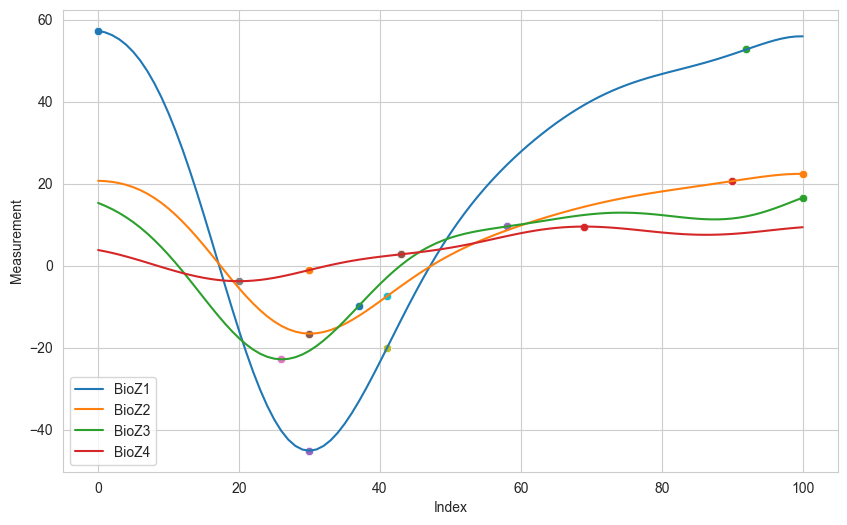

In [157]:
beat_index = (1, 1, 5, 8)
grouped_beats= beat_df.groupby(['Subject', 'Day', 'Trial', 'beat_id'])

beat = grouped_beats.get_group(beat_index)
position_decoder = ((len(beat)) / beat['InterbeatInterval'].mean())  # The index can be found by inverting the equation

beat_reset = beat.reset_index()
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4']

plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=beat, x=beat_reset.index, y=column, label=column)

# Max
sns.scatterplot(data=beat,  x=(beat['position_BioZ1_max'] * position_decoder), y = beat['BioZ1'].max())
sns.scatterplot(data=beat,  x=(beat['position_BioZ2_max'] * position_decoder), y = beat['BioZ2'].max())
sns.scatterplot(data=beat,  x=(beat['position_BioZ3_max'] * position_decoder), y = beat['BioZ3'].max())
sns.scatterplot(data=beat,  x=(beat['position_BioZ4_max'] * position_decoder), y = beat['BioZ4'].max())

# # Min
sns.scatterplot(data=beat,  x=(beat['position_BioZ1_min'] * position_decoder), y = beat['BioZ1'].min())
sns.scatterplot(data=beat,  x=(beat['position_BioZ2_min'] * position_decoder), y = beat['BioZ2'].min())
sns.scatterplot(data=beat,  x=(beat['position_BioZ3_min'] * position_decoder), y = beat['BioZ3'].min())
sns.scatterplot(data=beat,  x=(beat['position_BioZ4_min'] * position_decoder), y = beat['BioZ4'].min())

# Inflection
sns.scatterplot(data=beat,  x=(beat['max_slope_position_BioZ1'] * position_decoder), y = beat['max_slope_BioZ1'])
sns.scatterplot(data=beat,  x=(beat['max_slope_position_BioZ2'] * position_decoder), y = beat['max_slope_BioZ2'])
sns.scatterplot(data=beat,  x=(beat['max_slope_position_BioZ3'] * position_decoder), y = beat['max_slope_BioZ3'])
sns.scatterplot(data=beat,  x=(beat['max_slope_position_BioZ4'] * position_decoder), y = beat['max_slope_BioZ4'])

# Max Slope
sns.scatterplot(data=beat,  x=(beat['inflection_position_BioZ1'] * position_decoder), y = beat['inflection_point_BioZ1'])
sns.scatterplot(data=beat,  x=(beat['inflection_position_BioZ2'] * position_decoder), y = beat['inflection_point_BioZ2'])
sns.scatterplot(data=beat,  x=(beat['inflection_position_BioZ3'] * position_decoder), y = beat['inflection_point_BioZ3'])
sns.scatterplot(data=beat,  x=(beat['inflection_position_BioZ4'] * position_decoder), y = beat['inflection_point_BioZ4'])

plt.xlabel('Index')
plt.ylabel('Measurement')
plt.legend()
plt.show()

In [158]:
columns_to_plot = beats_featureset.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id', 'DBP', 'SBP', 'MAP']).columns
columns_to_plot

Index(['BioZ1_max', 'BioZ1_min', 'BioZ2_max', 'BioZ2_min', 'BioZ3_max',
       'BioZ3_min', 'BioZ4_max', 'BioZ4_min', 'InterbeatInterval',
       'position_BioZ1_max', 'position_BioZ1_min', 'position_BioZ2_max',
       'position_BioZ2_min', 'position_BioZ3_max', 'position_BioZ3_min',
       'position_BioZ4_max', 'position_BioZ4_min', 'BioZ1_BioZ2_cc',
       'BioZ1_BioZ3_cc', 'BioZ1_BioZ4_cc', 'BioZ2_BioZ3_cc', 'BioZ2_BioZ4_cc',
       'BioZ3_BioZ4_cc', 'max_slope_BioZ1', 'inflection_point_BioZ1',
       'max_slope_position_BioZ1', 'inflection_position_BioZ1',
       'max_slope_BioZ2', 'inflection_point_BioZ2', 'max_slope_position_BioZ2',
       'inflection_position_BioZ2', 'max_slope_BioZ3',
       'inflection_point_BioZ3', 'max_slope_position_BioZ3',
       'inflection_position_BioZ3', 'max_slope_BioZ4',
       'inflection_point_BioZ4', 'max_slope_position_BioZ4',
       'inflection_position_BioZ4', 'scaled_max_slope_BioZ1',
       'scaled_inflection_point_BioZ1', 'scaled_max_slope_B

---

### **3. Model Evaluation and Tuning**

#### **3.1 Cross-Validation.**

In [159]:
from sklearn.model_selection import KFold, GroupKFold, LeaveOneGroupOut, cross_validate, cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
import optuna

In order to smooth the data and remove the beat to beat variations they used window average of size 20 with an overlap of 50%.

This also has the added effect reducing the dataset's size by 90%.

In [160]:
beats_featureset

Subject  Day SetupType  Setup  Trial  beat_id        SBP       DBP  \
0            1    1  baseline      1      1        1  117.25990  76.80046   
1            1    1  baseline      1      1        2  122.55184  77.18544   
2            1    1  baseline      1      1        3  120.97179  78.52657   
3            1    1  baseline      1      1        4  120.85991  79.28472   
4            1    1  baseline      1      1        5  124.12496  81.43557   
...        ...  ...       ...    ...    ...      ...        ...       ...   
28047        7    1   cycling      1      3      251  107.57491  61.24011   
28048        7    1   cycling      1      3      252  108.36449  61.35977   
28049        7    1   cycling      1      3      253  109.03478  59.62908   
28050        7    1   cycling      1      3      254  106.93446  59.63800   
28051        7    1   cycling      1      3      255  108.40677  61.85031   

              MAP  BioZ1_max  ...  BioZ4_amplitude    BioZ4_auc  \
0       92.596765  70.075224  ...        15.191851   846.025421   
1       97.824016  70.035225  ...        18.699639   858.040401   
2       97.805233  67.537739  ...        20.993022   405.759958   
3       98.770990  69.052129  ...        18.479576   487.089159   
4      101.586861  71.673083  ...        19.241983   547.461281   
...           ...        ...  ...              ...          ...   
28047   80.822720  57.085762  ...        62.864208 -4398.667701   
28048   80.907033  66.381880  ...        72.358468  3207.701199   
28049   80.701350  66.057551  ...        80.087082  -366.974175   
28050   80.545038  56.879131  ...        52.612900 -2524.230049   
28051   88.801251  56.650698  ...        48.057033  -526.721652   

       BioZ1_scaled_amplitude  BioZ1_scaled_auc  BioZ2_scaled_amplitude  \
0                    2.496409       3781.799119                2.442484   
1                    2.972359       3291.584096                2.847236   
2                    2.869235       2938.336856                3.024119   
3                    2.916752       2768.611179                2.892755   
4                    2.957354       3048.818022                3.264544   
...                       ...               ...                     ...   
28047                2.134000      -3236.379941                0.748969   
28048                2.160810         34.416908                0.684294   
28049                2.274182      -1973.321404                0.703822   
28050                2.221488      -1706.808407                0.669215   
28051                2.024022      -2547.922925                0.728631   

       BioZ2_scaled_auc  BioZ3_scaled_amplitude  BioZ3_scaled_auc  \
0           1321.356979                1.616320       1517.299964   
1           1817.797385                4.044033       3950.902200   
2            965.154476                3.178598        745.445826   
3           1094.673881                3.284581       2325.712135   
4           1119.047245                5.609712        460.803375   
...                 ...                     ...               ...   
28047        -51.273819                0.725333      -4398.667701   
28048       -457.114005                0.834878       3207.701199   
28049        204.506299                0.924052       -366.974175   
28050        379.533183                0.607052      -2524.230049   
28051       -385.074616                0.554486       -526.721652   

       BioZ4_scaled_amplitude  BioZ4_scaled_auc  
0                    2.499645        846.025421  
1                    3.076811        858.040401  
2                    3.454161        405.759958  
3                    3.040602        487.089159  
4                    3.166048        547.461281  
...                       ...               ...  
28047                0.725333      -4398.667701  
28048                0.834878       3207.701199  
28049                0.924052       -366.974175  
28050                0.607052      -2524.230049

In [161]:
window_averaging_df = beats_featureset.copy()

In [162]:
def window_based_averaging(group, window_size=20, overlap = 0.5):

    step = int(window_size * (1 - overlap))

    result = pd.DataFrame(index=group.index)
    
    # Applying averaging to each non-index column
    for column in group.columns.difference(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id']):
        averaged = []
        for start in range(0, len(group), step):
            end = start + window_size

            # Handle cases where the window extends beyond the dataset
            if end > len(group):
                window = group[column][start:]
            else:
                window = group[column][start:end]
            window_average = window.mean()
            averaged.extend([window_average] * min(step, len(group) - start))
        # Ensure the result has the same length as the input
        if len(averaged) < len(group):
            averaged.extend([np.nan] * (len(group) - len(averaged)))
        result[column] = averaged
    return result

# Applying the function to each group
for name, group in window_averaging_df.groupby(['Subject', 'Day', 'Trial']):
    window_averaging_df.loc[group.index, group.columns.difference(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'])] = window_based_averaging(group)[group.columns.difference(['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'beat_id'])]

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22964\1291383625.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  window_averaging_df.loc[group.index, group.columns.difference(['Subject', 'Day', 'SetupType', 'Se

In [163]:
display(window_averaging_df.head())
window_averaging_df.shape

Subject  Day SetupType  Setup  Trial  beat_id         SBP        DBP  \
0        1    1  baseline      1      1        1  124.154516  79.676099   
1        1    1  baseline      1      1        2  124.154516  79.676099   
2        1    1  baseline      1      1        3  124.154516  79.676099   
3        1    1  baseline      1      1        4  124.154516  79.676099   
4        1    1  baseline      1      1        5  124.154516  79.676099   

         MAP  BioZ1_max  ...  BioZ4_amplitude   BioZ4_auc  \
0  99.666693  70.653764  ...        17.125576  447.686839   
1  99.666693  70.653764  ...        17.125576  447.686839   
2  99.666693  70.653764  ...        17.125576  447.686839   
3  99.666693  70.653764  ...        17.125576  447.686839   
4  99.666693  70.653764  ...        17.125576  447.686839   

   BioZ1_scaled_amplitude  BioZ1_scaled_auc  BioZ2_scaled_amplitude  \
0                2.952048       3360.784511                2.917458   
1                2.952048       3360.784511                2.917458   
2                2.952048       3360.784511                2.917458   
3                2.952048       3360.784511                2.917458   
4                2.952048       3360.784511                2.917458   

   BioZ2_scaled_auc  BioZ3_scaled_amplitude  BioZ3_scaled_auc  \
0       1208.515653                2.889279        1216.30189   
1       1208.515653                2.889279        1216.30189   
2       1208.515653                2.889279        1216.30189   
3       1208.515653                2.889279        1216.30189   
4       1208.515653                2.889279        1216.30189   

   BioZ4_scaled_amplitude  BioZ4_scaled_auc  
0                2.817817        447.686839  
1                2.817817        447.686839  
2                2.817817        447.686839  
3                2.817817        447.686839  
4                2.817817        447.686839  

[5 rows x 80 columns]

(28052, 80)

I can remove the beat and remove duplicates to get the final machine learning dataset. 

In [164]:
ml_df = window_averaging_df.drop(columns='beat_id').drop_duplicates()
ml_df

Subject  Day SetupType  Setup  Trial         SBP        DBP        MAP  \
0            1    1  baseline      1      1  124.154516  79.676099  99.666693   
10           1    1  baseline      1      1  120.438845  75.592841  95.254402   
20           1    1  baseline      1      1  114.923606  72.327239  90.756205   
30           1    1  baseline      1      1  112.856923  74.071757  91.345416   
40           1    1  baseline      1      1  115.521345  79.677732  96.568135   
...        ...  ...       ...    ...    ...         ...        ...        ...   
28007        7    1   cycling      1      3  110.210155  58.702765  80.485541   
28017        7    1   cycling      1      3  110.703266  59.671316  81.719367   
28027        7    1   cycling      1      3  107.373918  59.441017  79.848365   
28037        7    1   cycling      1      3  105.412377  59.218009  79.121985   
28047        7    1   cycling      1      3  108.063082  60.743454  82.355478   

       BioZ1_max  BioZ1_min  ...  BioZ4_amplitude   BioZ4_auc  \
0      70.653764 -57.777773  ...        17.125576  447.686839   
10     71.960162 -58.795782  ...        18.906082  491.022853   
20     76.374984 -63.203823  ...        19.581919  405.403348   
30     81.088621 -69.866888  ...        19.114267  180.899280   
40     81.040326 -69.816161  ...        20.018164  255.609526   
...          ...        ...  ...              ...         ...   
28007  61.631537 -54.766469  ...        45.661921  192.202887   
28017  56.923556 -50.667239  ...        58.107068 -267.339545   
28027  56.320540 -50.045180  ...        55.425930 -448.182484   
28037  58.559972 -52.695391  ...        50.267971 -382.277695   
28047  60.611004 -56.447119  ...        63.195938 -921.778475   

       BioZ1_scaled_amplitude  BioZ1_scaled_auc  BioZ2_scaled_amplitude  \
0                    2.952048       3360.784511                2.917458   
10                   3.005475       3878.159461                2.941065   
20                   3.208272       3433.941369                3.179531   
30                   3.469770       2428.864075                3.467566   
40                   3.467494       2478.874075                3.524824   
...                       ...               ...                     ...   
28007                2.150703        303.497129                0.767664   
28017                1.987971        172.701375                0.852797   
28027                1.965335        116.129182                0.816081   
28037                2.055682       -594.728117                0.711831   
28047                2.162900      -1886.003154                0.706986   

       BioZ2_scaled_auc  BioZ3_scaled_amplitude  BioZ3_scaled_auc  \
0           1208.515653                2.889279       1216.301890   
10          1331.951146                2.658350       1214.268370   
20          1112.593389                2.954007       1036.555175   
30           678.713905                3.174929        631.480372   
40           756.041758                3.104726        778.568768   
...                 ...                     ...               ...   
28007        128.370472                0.526851        192.202887   
28017        -52.137225                0.670445       -267.339545   
28027        -81.667569                0.639509       -448.182484   
28037         32.223575                0.579996       -382.277695   
28047        -61.884591                0.729160       -921.778475   

       BioZ4_scaled_amplitude  BioZ4_scaled_auc  
0                    2.817817        447.686839  
10                   3.110779        491.022853  
20                   3.221980        405.403348  
30                   3.145034        180.899280  
40                   3.293760        255.609526  
...                       ...               ...  
28007                0.526851        192.202887  
28017                0.670445       -267.339545  
28027                0.639509       -448.182484  
28037                0.

In their approach they tested multiple different ML setups, some involved training with the hgcp data, and evaluating on the rest.

While others involved training a separate model on each subject’s data.

I am going to compare KFold and Leave1GroupOut cross validation.

> ##### **Now I can use KFold Cross Validation to Assess the Model's performance.**

Cross Validation allows for the whole dataset to be used in the training and evaluation process, by training a model on k different folds.

With KFold each of these splits is determined randomly.

In [165]:
# A dataframe for different model results
results_df = pd.DataFrame(columns=['Target', 'Model', 'MAE', 'MAE_STD', 'RMSE', 'RMSE_STD', 'R2', 'R2_STD'])

In [166]:
def kfold_regression(df, model, target, n_splits=5, return_model=False, shuffle=True, n_jobs=-1, results_df=None):

    X = df.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'DBP', 'SBP', 'MAP'])
    y = df[target]

    cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=1234)
    
    scoring = {'MAE': 'neg_mean_absolute_error',
               'MSE': 'neg_mean_squared_error',
               'RMSE': 'neg_root_mean_squared_error',
               'R2': 'r2'}

    results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_estimator=return_model, n_jobs=n_jobs)
    
    # Calculate mean and std for each metric
    mae_mean, mae_std = -np.mean(results["test_MAE"]), np.std(results["test_MAE"])
    rmse_mean, rmse_std = -np.mean(results["test_RMSE"]), np.std(results["test_RMSE"])
    r2_mean, r2_std = np.mean(results["test_R2"]), np.std(results["test_R2"])

    # Print the results
    print(f'Target: {target}')
    print(f'Model: {type(model).__name__}')
    print(f'Mean Absolute Error: {mae_mean} +- {mae_std}')
    print(f'Root Mean Squared Error: {rmse_mean} +- {rmse_std}')
    print(f'R^2 Score: {r2_mean} +- {r2_std}\n')

    # Append results to the dataframe
    if results_df is not None:
        results_df.loc[len(results_df)] = [target, type(model).__name__, mae_mean, mae_std, rmse_mean, rmse_std, r2_mean, r2_std]    

    if return_model:
        return model.fit(X, y)

Here are the results with the default RandomForestRegressor on the full dataset.

In [167]:
model = RandomForestRegressor(random_state=1234)
kfold_regression(ml_df, model, 'DBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'SBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: RandomForestRegressor
Mean Absolute Error: 5.742235652997555 +- 0.18489018206944127
Root Mean Squared Error: 7.810067532863759 +- 0.2773658790578412
R^2 Score: 0.6776650856452109 +- 0.016747515486004633

Target: SBP
Model: RandomForestRegressor
Mean Absolute Error: 6.732848121785845 +- 0.4116954027029148
Root Mean Squared Error: 9.05464379872791 +- 0.7636996754177261
R^2 Score: 0.6119328571608266 +- 0.040278243344105465

Target: MAP
Model: RandomForestRegressor
Mean Absolute Error: 5.861907275471975 +- 0.23787069807345182
Root Mean Squared Error: 8.11685725000896 +- 0.4202765356870135
R^2 Score: 0.6254530560845014 +- 0.02641743461313148



I'll compare it with a few other regression models using their default parameters.

In [168]:
# AdaBoost Regressor
model = AdaBoostRegressor(random_state=1234)
kfold_regression(ml_df, model, 'DBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'SBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: AdaBoostRegressor
Mean Absolute Error: 7.769453802802003 +- 0.16190433579340816
Root Mean Squared Error: 9.604052029107404 +- 0.19830144017318826
R^2 Score: 0.5120805868500187 +- 0.02786419292503826

Target: SBP
Model: AdaBoostRegressor
Mean Absolute Error: 9.23684454509943 +- 0.3668615870910423
Root Mean Squared Error: 11.47538946401655 +- 0.5200641897080284
R^2 Score: 0.3751993818450823 +- 0.04671061424757834

Target: MAP
Model: AdaBoostRegressor
Mean Absolute Error: 8.045639478983214 +- 0.23584589356323307
Root Mean Squared Error: 9.948275717995097 +- 0.26469733805229384
R^2 Score: 0.4362794324494875 +- 0.04077866790382572



In [169]:
# Linear Regression
model = LinearRegression()
kfold_regression(ml_df, model, 'DBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'SBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: LinearRegression
Mean Absolute Error: 10.836653856623911 +- 6.378005454130547
Root Mean Squared Error: 46.796293950476425 +- 106.46001010637882
R^2 Score: -67.4378991277207 +- 203.27098650767297

Target: SBP
Model: LinearRegression
Mean Absolute Error: 10.899316431916745 +- 3.5943444869358934
Root Mean Squared Error: 31.285025561071812 +- 54.899914009929816
R^2 Score: -15.137921099382552 +- 45.94664182747754



Target: MAP
Model: LinearRegression
Mean Absolute Error: 9.717536066903637 +- 3.312970788646139
Root Mean Squared Error: 28.95730588787548 +- 52.451695389698024
R^2 Score: -17.616291114247886 +- 53.56037461176078



In [170]:
# XGBoost Regressor
model = XGBRegressor(random_state=1234)
kfold_regression(ml_df, model, 'DBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'SBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: XGBRegressor
Mean Absolute Error: 5.6184427316894485 +- 0.2109333259522
Root Mean Squared Error: 7.542526916580802 +- 0.24951618683428747
R^2 Score: 0.6985760333411981 +- 0.026228165721875602

Target: SBP
Model: XGBRegressor
Mean Absolute Error: 6.666479899702088 +- 0.4598694500851914
Root Mean Squared Error: 8.938011568148605 +- 0.6337782085102357
R^2 Score: 0.6216171357069931 +- 0.03390923063398854

Target: MAP
Model: XGBRegressor
Mean Absolute Error: 5.796944040177641 +- 0.29809570534741425
Root Mean Squared Error: 7.802385168881491 +- 0.38160736801042006
R^2 Score: 0.6542043359193734 +- 0.01805474191599931



In [171]:
# SVM Regressor
model = SVR()
kfold_regression(ml_df, model, 'DBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'SBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: SVR
Mean Absolute Error: 11.492400988024626 +- 0.3808876907213842
Root Mean Squared Error: 13.74222915583536 +- 0.38004688889610144
R^2 Score: 0.0029317187773037824 +- 0.006885878572943056

Target: SBP
Model: SVR
Mean Absolute Error: 11.630120348774184 +- 0.4700725634781995
Root Mean Squared Error: 14.52436628384287 +- 0.6066021762725139
R^2 Score: 0.0016182308641944031 +- 0.00459643391579825

Target: MAP
Model: SVR
Mean Absolute Error: 10.865499395487983 +- 0.41263741805945564
Root Mean Squared Error: 13.250885999913658 +- 0.4132655041689778
R^2 Score: 0.002629474607047222 +- 0.00483007520898994



In [172]:
# Extra Trees Regressor
model = ExtraTreesRegressor(random_state=1234)
kfold_regression(ml_df, model, 'DBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'SBP', 10, results_df=results_df)
kfold_regression(ml_df, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: ExtraTreesRegressor
Mean Absolute Error: 5.428041746174175 +- 0.18835418221724284
Root Mean Squared Error: 7.324743519985063 +- 0.3196724575239678
R^2 Score: 0.7165170302478634 +- 0.017039357554267207

Target: SBP
Model: ExtraTreesRegressor
Mean Absolute Error: 6.420254549662191 +- 0.3475007328784068
Root Mean Squared Error: 8.723998914091874 +- 0.6465628224291681
R^2 Score: 0.639977482899811 +- 0.029409860004768293

Target: MAP
Model: ExtraTreesRegressor
Mean Absolute Error: 5.689528650633107 +- 0.26544603803867517
Root Mean Squared Error: 7.749391906052731 +- 0.4552152615200487
R^2 Score: 0.6584919415969169 +- 0.028499967919210764



Lets look at the results.

In [173]:
results_df.sort_values(['Target', 'RMSE'])

Target                  Model        MAE   MAE_STD       RMSE    RMSE_STD  \
15    DBP    ExtraTreesRegressor   5.428042  0.188354   7.324744    0.319672   
9     DBP           XGBRegressor   5.618443  0.210933   7.542527    0.249516   
0     DBP  RandomForestRegressor   5.742236  0.184890   7.810068    0.277366   
3     DBP      AdaBoostRegressor   7.769454  0.161904   9.604052    0.198301   
12    DBP                    SVR  11.492401  0.380888  13.742229    0.380047   
6     DBP       LinearRegression  10.836654  6.378005  46.796294  106.460010   
17    MAP    ExtraTreesRegressor   5.689529  0.265446   7.749392    0.455215   
11    MAP           XGBRegressor   5.796944  0.298096   7.802385    0.381607   
2     MAP  RandomForestRegressor   5.861907  0.237871   8.116857    0.420277   
5     MAP      AdaBoostRegressor   8.045639  0.235846   9.948276    0.264697   
14    MAP                    SVR  10.865499  0.412637  13.250886    0.413266   
8     MAP       LinearRegression   9.717536  3.312971  28.957306   52.451695   
16    SBP    ExtraTreesRegressor   6.420255  0.347501   8.723999    0.646563   
10    SBP           XGBRegressor   6.666480  0.459869   8.938012    0.633778   
1     SBP  RandomForestRegressor   6.732848  0.411695   9.054644    0.763700   
4     SBP      AdaBoostRegressor   9.236845  0.366862  11.475389    0.520064   
13    SBP                    SVR  11.630120  0.470073  14.524366    0.606602   
7     SBP       LinearRegression  10.899316  3.594344  31.285026   54.899914   

           R2      R2_STD  
15   0.716517    0.017039  
9    0.698576    0.026228  
0    0.677665    0.016748  
3    0.512081    0.027864  
12   0.002932    0.006886  
6  -67.437899  203.270987  
17   0.658492    0.028500  
11   0.654204    0.018055  
2    0.625453    0.026417  
5    0.436279    0.040779  
14   0.002629    0.004830  
8  -17.616291   53.560375  
16   0.639977    0.029410  
10   0.621617    0.033909  
1    0.611933    0.040278  
4    0.375199    0.046711  
13   0.001618    0.004596  
7  -15.137921   45.946642

Extra trees was the best at minimising RMSE across the each target type.

This is probably because tree models are adept at dealing with large featurespaces, and highly corrolated features.

In [174]:
# results_df.to_csv("../../data/kfold_results.csv")

> ##### **Lets Compare this with Leave1GroupOut.**

The problem with KFold cross validation is that data from the same person can be placed in both the training and testing folds.

This can cause information to leak to the model, where it can overfit on certain bits of noise that are specific to that person. This results in dramatically misleading cross-validation scores that fail to reflect the model’s actual ability to generalise on new unseen data.

Leave1GroupOut instead, trains the data on all but 1 members of a group, then evaluates the model on the left out subject.

In [175]:
# Assume df has a column 'Subject' indicating the subject ID for each row
def leave_one_subject_out_regression(df, model, target, return_model=False, n_jobs=-1, results_df=None):

    # Exclude target and non-feature columns from X
    X = df.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'DBP', 'SBP', 'MAP'])
    y = df[target]
    groups = df['Subject']  # This assumes there is a 'Subject' column for grouping

    cv = LeaveOneGroupOut()

    scoring = {'MAE': 'neg_mean_absolute_error',
               'MSE': 'neg_mean_squared_error',
               'RMSE': 'neg_root_mean_squared_error',
               'R2': 'r2'}

    results = cross_validate(model, X, y, groups=groups, cv=cv, scoring=scoring, return_estimator=return_model, n_jobs=n_jobs)
    
    # Calculate mean and std for each metric
    mae_mean, mae_std = -np.mean(results["test_MAE"]), np.std(results["test_MAE"])
    rmse_mean, rmse_std = -np.mean(results["test_RMSE"]), np.std(results["test_RMSE"])
    r2_mean, r2_std = np.mean(results["test_R2"]), np.std(results["test_R2"])

    # Print the results
    print(f'Target: {target}')
    print(f'Model: {type(model).__name__}')
    print(f'Mean Absolute Error: {mae_mean} +- {mae_std}')
    print(f'Root Mean Squared Error: {rmse_mean} +- {rmse_std}')
    print(f'R^2 Score: {r2_mean} +- {r2_std}\n')

    # Append results to the dataframe
    if results_df is not None:
        results_df.loc[len(results_df)] = [target, type(model).__name__, mae_mean, mae_std, rmse_mean, rmse_std, r2_mean, r2_std]

    if return_model:
        return model.fit(X, y)


In [176]:
#results_df = pd.DataFrame(columns=['Target', 'Model', 'MAE', 'MAE_STD', 'RMSE', 'RMSE_STD', 'R2', 'R2_STD'])

In [177]:
# RandomForest Regressor
model = RandomForestRegressor(random_state=1234)
leave_one_subject_out_regression(ml_df, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'MAP', 10, results_df=results_df)

# AdaBoost Regressor
model = AdaBoostRegressor(random_state=1234)
leave_one_subject_out_regression(ml_df, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'MAP', 10, results_df=results_df)

# Linear Regression
model = LinearRegression()
leave_one_subject_out_regression(ml_df, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'MAP', 10, results_df=results_df)

# XGBoost Regressor
model = XGBRegressor(random_state=1234)
leave_one_subject_out_regression(ml_df, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'MAP', 10, results_df=results_df)

# SVM Regressor
model = SVR()
leave_one_subject_out_regression(ml_df, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'MAP', 10, results_df=results_df)

# Extra Trees Regressor
model = ExtraTreesRegressor(random_state=1234)
leave_one_subject_out_regression(ml_df, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_df, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: RandomForestRegressor
Mean Absolute Error: 12.715309861855484 +- 3.6428041858739637
Root Mean Squared Error: 15.05733381710248 +- 3.6982152510062747
R^2 Score: -6.845915129352615 +- 14.131325727426432

Target: SBP
Model: RandomForestRegressor
Mean Absolute Error: 11.367267123775317 +- 2.485310858598392
Root Mean Squared Error: 14.202911705892957 +- 2.413186336149642
R^2 Score: -0.5110004497376178 +- 1.1544009342768669

Target: MAP
Model: RandomForestRegressor
Mean Absolute Error: 11.329158161443761 +- 3.6071115720076286
Root Mean Squared Error: 13.643907297598881 +- 3.557873460685924
R^2 Score: -3.5934804665484705 +- 7.989953118120729

Target: DBP
Model: AdaBoostRegressor
Mean Absolute Error: 12.786088627264567 +- 5.537879863300821
Root Mean Squared Error: 14.889242884756353 +- 5.268701468450481
R^2 Score: -10.077651047921032 +- 22.220076379134422

Target: SBP
Model: AdaBoostRegressor
Mean Absolute Error: 11.343678283097415 +- 2.6536416397770926
Root Mean Squared Err

ExtraTreesRegressor(random_state=1234)

In [178]:
results_df.sort_values(['Target', 'RMSE'])

Target                  Model         MAE     MAE_STD         RMSE  \
15    DBP    ExtraTreesRegressor    5.428042    0.188354     7.324744   
9     DBP           XGBRegressor    5.618443    0.210933     7.542527   
0     DBP  RandomForestRegressor    5.742236    0.184890     7.810068   
3     DBP      AdaBoostRegressor    7.769454    0.161904     9.604052   
12    DBP                    SVR   11.492401    0.380888    13.742229   
33    DBP    ExtraTreesRegressor   12.193959    3.515651    14.205955   
21    DBP      AdaBoostRegressor   12.786089    5.537880    14.889243   
18    DBP  RandomForestRegressor   12.715310    3.642804    15.057334   
27    DBP           XGBRegressor   13.174790    4.197565    15.556414   
30    DBP                    SVR   14.186183    3.707140    16.057882   
6     DBP       LinearRegression   10.836654    6.378005    46.796294   
24    DBP       LinearRegression  141.310388  218.102156  1094.659720   
17    MAP    ExtraTreesRegressor    5.689529    0.265446     7.749392   
11    MAP           XGBRegressor    5.796944    0.298096     7.802385   
2     MAP  RandomForestRegressor    5.861907    0.237871     8.116857   
5     MAP      AdaBoostRegressor    8.045639    0.235846     9.948276   
35    MAP    ExtraTreesRegressor   10.929042    3.043096    13.112737   
14    MAP                    SVR   10.865499    0.412637    13.250886   
20    MAP  RandomForestRegressor   11.329158    3.607112    13.643907   
23    MAP      AdaBoostRegressor   12.432513    5.390626    14.761812   
29    MAP           XGBRegressor   12.311686    4.282413    14.822586   
32    MAP                    SVR   12.675065    2.861512    14.859562   
8     MAP       LinearRegression    9.717536    3.312971    28.957306   
26    MAP       LinearRegression  111.338276  167.799870   750.871778   
16    SBP    ExtraTreesRegressor    6.420255    0.347501     8.723999   
10    SBP           XGBRegressor    6.666480    0.459869     8.938012   
1     SBP  RandomForestRegressor    6.732848    0.411695     9.054644   
4     SBP      AdaBoostRegressor    9.236845    0.366862    11.475389   
34    SBP    ExtraTreesRegressor   10.887714    1.902717    13.549009   
19    SBP  RandomForestRegressor   11.367267    2.485311    14.202912   
22    SBP      AdaBoostRegressor   11.343678    2.653642    14.283300   
13    SBP                    SVR   11.630120    0.470073    14.524366   
31    SBP                    SVR   12.240987    1.786118    15.114675   
28    SBP           XGBRegressor   12.402716    2.996103    15.411737   
7     SBP       LinearRegression   10.899316    3.594344    31.285026   
25    SBP       LinearRegression   66.649687   95.534377   224.023100   

       RMSE_STD             R2         R2_STD  
15     0.319672       0.716517       0.017039  
9      0.249516       0.698576       0.026228  
0      0.277366       0.677665       0.016748  
3      0.198301       0.512081       0.027864  
12     0.380047       0.002932       0.006886  
33     3.462183      -6.039934      12.403609  
21     5.268701     -10.077651      22.220076  
18     3.698215      -6.845915      14.131326  
27     4.025787      -7.564373      15.163379  
30     3.204643      -7.165123      13.664232  
6    106.460010     -67.437899     203.270987  
24  2330.886394 -114181.510743  276816.443576  
17     0.455215       0.658492       0.028500  
11     0.381607       0.654204       0.018055  
2      0.420277       0.625453       0.026417  
5      0.264697       0.436279       0.040779  
35     2.921347      -2.865058       6.337935  
14     0.413266       0.002629       0.004830  
20     3.557873      -3.593480       7.989953  
23     5.001284      -5.803144      13.048302  
29     4.220545      -4.915381      10.737713  
32     2.112360      -3.349829       6.460028  
8     52.451695     -17.616291      53.560375  
26  1557.038074  -35139.636082   84403.069928  
16     0.646563       0.639977       0.029410  
10     0.633778       0.621617       0.033909  
1    

As you can see, while extra trees remains the best model, the scores are much worse across the board.

This indicates that leakage is occuring when the Kfold is used.

In [179]:
# results_df.to_csv("../../data/leave_one_out_results.csv")

I compared these scores with an apporach that does not drop outliers.

When outliers are not dropped, the scores are worse in every scenario, by 1-2 points.

Finally I will see how the models perform when subject 7 is dropped as they are the least similar.

This is also what the researchers did with their models.

In [180]:
ml_without_7 = ml_df[ml_df['Subject']!=7]

In [181]:
results_df = pd.DataFrame(columns=['Target', 'Model', 'MAE', 'MAE_STD', 'RMSE', 'RMSE_STD', 'R2', 'R2_STD'])

In [182]:
# RandomForest Regressor
model = RandomForestRegressor(random_state=1234)
leave_one_subject_out_regression(ml_without_7, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'MAP', 10, results_df=results_df)

# AdaBoost Regressor
model = AdaBoostRegressor(random_state=1234)
leave_one_subject_out_regression(ml_without_7, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'MAP', 10, results_df=results_df)

# Linear Regression
model = LinearRegression()
leave_one_subject_out_regression(ml_without_7, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'MAP', 10, results_df=results_df)

# XGBoost Regressor
model = XGBRegressor(random_state=1234)
leave_one_subject_out_regression(ml_without_7, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'MAP', 10, results_df=results_df)

# SVM Regressor
model = SVR()
leave_one_subject_out_regression(ml_without_7, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'MAP', 10, results_df=results_df)

# Extra Trees Regressor
model = ExtraTreesRegressor(random_state=1234)
leave_one_subject_out_regression(ml_without_7, model, 'DBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'SBP', 10, results_df=results_df)
leave_one_subject_out_regression(ml_without_7, model, 'MAP', 10, results_df=results_df)

Target: DBP
Model: RandomForestRegressor
Mean Absolute Error: 11.330861752575283 +- 3.3270630219949964
Root Mean Squared Error: 13.49932546080399 +- 3.38110057175958
R^2 Score: -1.0676384771667615 +- 1.881124918891472

Target: SBP
Model: RandomForestRegressor
Mean Absolute Error: 10.707399961020947 +- 2.1153451238016454
Root Mean Squared Error: 13.58769427471812 +- 2.294249044123482
R^2 Score: -0.03126868911008821 +- 0.16169069140275835

Target: MAP
Model: RandomForestRegressor
Mean Absolute Error: 10.33379756198702 +- 2.7585452978458145
Root Mean Squared Error: 12.738566475881619 +- 2.9998620327563605
R^2 Score: -0.4122860374244374 +- 0.9240326782391955

Target: DBP
Model: AdaBoostRegressor
Mean Absolute Error: 11.366273375677991 +- 3.8984118867470823
Root Mean Squared Error: 13.654702728555788 +- 3.883695393977123
R^2 Score: -1.2542526951773834 +- 2.3044546687646377

Target: SBP
Model: AdaBoostRegressor
Mean Absolute Error: 10.90091919033099 +- 2.3247559148298476
Root Mean Squared Er

ExtraTreesRegressor(random_state=1234)

In [183]:
results_df.sort_values(['Target', 'RMSE'])

Target                  Model         MAE     MAE_STD         RMSE  \
0     DBP  RandomForestRegressor   11.330862    3.327063    13.499325   
15    DBP    ExtraTreesRegressor   11.499399    3.478379    13.560661   
3     DBP      AdaBoostRegressor   11.366273    3.898412    13.654703   
9     DBP           XGBRegressor   11.985827    2.845503    14.533953   
12    DBP                    SVR   13.164672    3.341328    15.289200   
6     DBP       LinearRegression  123.933892  226.406925  1147.861546   
17    MAP    ExtraTreesRegressor   10.105883    2.542822    12.388633   
5     MAP      AdaBoostRegressor   10.221358    2.672040    12.572645   
11    MAP           XGBRegressor   10.247008    2.086861    12.687639   
2     MAP  RandomForestRegressor   10.333798    2.758545    12.738566   
14    MAP                    SVR   11.739367    2.215230    14.196045   
8     MAP       LinearRegression   93.776214  169.927076   733.643658   
16    SBP    ExtraTreesRegressor   10.526667    1.790963    13.401847   
1     SBP  RandomForestRegressor   10.707400    2.115345    13.587694   
10    SBP           XGBRegressor   10.994724    1.874108    13.838835   
4     SBP      AdaBoostRegressor   10.900919    2.324756    13.846160   
13    SBP                    SVR   12.031127    1.817077    15.035823   
7     SBP       LinearRegression   60.296199   95.639925   196.369262   

       RMSE_STD             R2         R2_STD  
0      3.381101      -1.067638       1.881125  
15     3.395428      -1.145213       2.055905  
3      3.883695      -1.254253       2.304455  
9      3.140445      -1.294023       1.886637  
12     3.179995      -1.638985       2.229100  
6   2453.721009 -126996.894592  283786.614542  
17     2.631537      -0.344095       0.867961  
5      2.810822      -0.393699       0.929295  
11     2.344855      -0.348275       0.695636  
2      2.999862      -0.412286       0.924033  
14     1.849013      -0.712767       0.791471  
8   1553.834731  -34839.420271   77814.943191  
16     2.003954      -0.007329       0.144501  
1      2.294249      -0.031269       0.161691  
10     1.943324      -0.070847       0.110173  
4      2.589796      -0.071904       0.210839  
13     1.823793      -0.309859       0.402335  
7    359.276877    -916.316443    2000.411146

In [184]:
# results_df.to_csv("../../data/leave_one_out_results_no_7.csv")

#### **3.2 Feature Selection and Hyperparameter Tuning.**

>##### **Hyperparamter Tuning Using Optuna**

Finally, I am going to utilise Optuna to perform a Bayesian Search of the models and their hyperparameters.

Bayesian search builds probabalistic models to find the parameters that are the most likely to cause an increase to model performance.

It has accuracy advantages over Random Search while being less computationally expensive than grid search allowing for a wider search of parameters.

Optuna can tune paramters to maximise or mimimse any chosen variable.

However one downside is that it is not guaranteeed to find the objectively best parameters.

In [185]:
ml_df

Subject  Day SetupType  Setup  Trial         SBP        DBP        MAP  \
0            1    1  baseline      1      1  124.154516  79.676099  99.666693   
10           1    1  baseline      1      1  120.438845  75.592841  95.254402   
20           1    1  baseline      1      1  114.923606  72.327239  90.756205   
30           1    1  baseline      1      1  112.856923  74.071757  91.345416   
40           1    1  baseline      1      1  115.521345  79.677732  96.568135   
...        ...  ...       ...    ...    ...         ...        ...        ...   
28007        7    1   cycling      1      3  110.210155  58.702765  80.485541   
28017        7    1   cycling      1      3  110.703266  59.671316  81.719367   
28027        7    1   cycling      1      3  107.373918  59.441017  79.848365   
28037        7    1   cycling      1      3  105.412377  59.218009  79.121985   
28047        7    1   cycling      1      3  108.063082  60.743454  82.355478   

       BioZ1_max  BioZ1_min  ...  BioZ4_amplitude   BioZ4_auc  \
0      70.653764 -57.777773  ...        17.125576  447.686839   
10     71.960162 -58.795782  ...        18.906082  491.022853   
20     76.374984 -63.203823  ...        19.581919  405.403348   
30     81.088621 -69.866888  ...        19.114267  180.899280   
40     81.040326 -69.816161  ...        20.018164  255.609526   
...          ...        ...  ...              ...         ...   
28007  61.631537 -54.766469  ...        45.661921  192.202887   
28017  56.923556 -50.667239  ...        58.107068 -267.339545   
28027  56.320540 -50.045180  ...        55.425930 -448.182484   
28037  58.559972 -52.695391  ...        50.267971 -382.277695   
28047  60.611004 -56.447119  ...        63.195938 -921.778475   

       BioZ1_scaled_amplitude  BioZ1_scaled_auc  BioZ2_scaled_amplitude  \
0                    2.952048       3360.784511                2.917458   
10                   3.005475       3878.159461                2.941065   
20                   3.208272       3433.941369                3.179531   
30                   3.469770       2428.864075                3.467566   
40                   3.467494       2478.874075                3.524824   
...                       ...               ...                     ...   
28007                2.150703        303.497129                0.767664   
28017                1.987971        172.701375                0.852797   
28027                1.965335        116.129182                0.816081   
28037                2.055682       -594.728117                0.711831   
28047                2.162900      -1886.003154                0.706986   

       BioZ2_scaled_auc  BioZ3_scaled_amplitude  BioZ3_scaled_auc  \
0           1208.515653                2.889279       1216.301890   
10          1331.951146                2.658350       1214.268370   
20          1112.593389                2.954007       1036.555175   
30           678.713905                3.174929        631.480372   
40           756.041758                3.104726        778.568768   
...                 ...                     ...               ...   
28007        128.370472                0.526851        192.202887   
28017        -52.137225                0.670445       -267.339545   
28027        -81.667569                0.639509       -448.182484   
28037         32.223575                0.579996       -382.277695   
28047        -61.884591                0.729160       -921.778475   

       BioZ4_scaled_amplitude  BioZ4_scaled_auc  
0                    2.817817        447.686839  
10                   3.110779        491.022853  
20                   3.221980        405.403348  
30                   3.145034        180.899280  
40                   3.293760        255.609526  
...                       ...               ...  
28007                0.526851        192.202887  
28017                0.670445       -267.339545  
28027                0.639509       -448.182484  
28037                0.

I will stick with the 4 most performant models, with the goal of minimiseing LeaveOneOut RMSE.

In [189]:
# Define the objective function
def objective(trial):

    ml_df_copy = ml_df.copy()
    # Exclude target and non-feature columns from X
    X = ml_df_copy.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'DBP', 'SBP', 'MAP'])
    y = ml_df_copy['DBP']
    groups = ml_df_copy['Subject']

    # Model selection
    model_name = trial.suggest_categorical('model', ['RandomForest', 'AdaBoost', 'XGBoost', 'ExtraTrees'])

    if model_name == 'RandomForest':
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int('n_estimators_rf', 10, 100),
            max_depth=trial.suggest_int('max_depth_rf', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split_rf', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf_rf', 1, 10),
            max_features=trial.suggest_categorical('max_features_rf', ['sqrt', 'log2']),
            bootstrap=trial.suggest_categorical('bootstrap_et', [True, False]),
            random_state=1234
        )

    elif model_name == 'AdaBoost':
        model = AdaBoostRegressor(
            n_estimators=trial.suggest_int('n_estimators_ab', 50, 100),  
            learning_rate=trial.suggest_float('learning_rate_ab', 0.001, 2),
            loss=trial.suggest_categorical('loss_ab', ['linear', 'square', 'exponential']),
            random_state=1234
        )

    elif model_name == 'XGBoost':
        model = XGBRegressor(
            n_estimators=trial.suggest_int('n_estimators_xgb', 50, 400),
            max_depth=trial.suggest_int('max_depth_xgb', 3, 10),
            learning_rate=trial.suggest_float('learning_rate_xgb', 0.01, 0.3),
            reg_alpha=trial.suggest_float('reg_alpha_xgb', 0, 5),
            reg_lambda=trial.suggest_float('reg_lambda_xgb', 0.1, 10),
            random_state=1234
        )

    elif model_name == 'ExtraTrees':
        model = ExtraTreesRegressor(
            n_estimators=trial.suggest_int('n_estimators_et', 10, 100),
            max_depth=trial.suggest_int('max_depth_et', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split_et', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf_et', 1, 10),
            max_features=trial.suggest_categorical('max_features_et', ['sqrt', 'log2']),
            bootstrap=trial.suggest_categorical('bootstrap_et', [True, False]),
            random_state=1234
        )

    # Cross-validation setup
    cv = LeaveOneGroupOut()
    scoring = 'neg_root_mean_squared_error'
    scores = cross_val_score(model, X, y, groups=groups, cv=cv, scoring=scoring)
    rmse = -scores.mean()

    return rmse

sampler = optuna.samplers.TPESampler(seed=1234)  # For reproducability

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1500, n_jobs=-1)

print(study.best_trial)

[I 2024-04-08 05:24:04,999] A new study created in memory with name: no-name-ffa87426-d589-4fa6-974a-7860a3e91a56
[I 2024-04-08 05:24:06,583] Trial 6 finished with value: 14.328780391591048 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 24, 'max_depth_et': 22, 'min_samples_split_et': 2, 'min_samples_leaf_et': 7, 'max_features_et': 'log2', 'bootstrap_et': True}. Best is trial 6 with value: 14.328780391591048.
[I 2024-04-08 05:24:07,081] Trial 7 finished with value: 13.953962960803992 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 27, 'max_depth_et': 17, 'min_samples_split_et': 5, 'min_samples_leaf_et': 4, 'max_features_et': 'log2', 'bootstrap_et': False}. Best is trial 7 with value: 13.953962960803992.
[I 2024-04-08 05:24:07,109] Trial 3 finished with value: 13.93550668495914 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 25, 'max_depth_et': 23, 'min_samples_split_et': 6, 'min_samples_leaf_et': 4, 'max_features_et': 'sqrt', 'bootstrap_et': True}. Best

In [ ]:
results_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
results_df.to_csv("../../data/optuna_dbp.csv")

# The study can be saved and resumed
import joblib

joblib.dump(study, "../../data/dbp_study.pkl")

# loaded_study = joblib.load("../../data/studies/cleaning_study.pkl")
# print("Best trial until now:")
# print(" Value: ", loaded_study.best_trial.value)
# print(" Params: ")
# for key, value in loaded_study.best_trial.params.items():
#     print(f"    {key}: {value}")

In [ ]:
# Define the objective function
def objective(trial):

    ml_df_copy = ml_df.copy()
    # Exclude target and non-feature columns from X
    X = ml_df_copy.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'DBP', 'SBP', 'MAP'])
    y = ml_df_copy['SBP']
    groups = ml_df_copy['Subject']

    # Model selection
    model_name = trial.suggest_categorical('model', ['RandomForest', 'AdaBoost', 'XGBoost', 'ExtraTrees'])

    if model_name == 'RandomForest':
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int('n_estimators_rf', 10, 100),
            max_depth=trial.suggest_int('max_depth_rf', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split_rf', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf_rf', 1, 10),
            max_features=trial.suggest_categorical('max_features_rf', ['sqrt', 'log2']),
            bootstrap=trial.suggest_categorical('bootstrap_et', [True, False]),
            random_state=1234
        )

    elif model_name == 'AdaBoost':
        model = AdaBoostRegressor(
            n_estimators=trial.suggest_int('n_estimators_ab', 50, 100),  
            learning_rate=trial.suggest_float('learning_rate_ab', 0.001, 2),
            loss=trial.suggest_categorical('loss_ab', ['linear', 'square', 'exponential']),
            random_state=1234
        )

    elif model_name == 'XGBoost':
        model = XGBRegressor(
            n_estimators=trial.suggest_int('n_estimators_xgb', 50, 400),
            max_depth=trial.suggest_int('max_depth_xgb', 3, 10),
            learning_rate=trial.suggest_float('learning_rate_xgb', 0.01, 0.3),
            reg_alpha=trial.suggest_float('reg_alpha_xgb', 0, 5),
            reg_lambda=trial.suggest_float('reg_lambda_xgb', 0.1, 10),
            random_state=1234
        )

    elif model_name == 'ExtraTrees':
        model = ExtraTreesRegressor(
            n_estimators=trial.suggest_int('n_estimators_et', 10, 100),
            max_depth=trial.suggest_int('max_depth_et', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split_et', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf_et', 1, 10),
            max_features=trial.suggest_categorical('max_features_et', ['sqrt', 'log2']),
            bootstrap=trial.suggest_categorical('bootstrap_et', [True, False]),
            random_state=1234
        )

    # Cross-validation setup
    cv = LeaveOneGroupOut()
    scoring = 'neg_root_mean_squared_error'
    scores = cross_val_score(model, X, y, groups=groups, cv=cv, scoring=scoring)
    rmse = -scores.mean()

    return rmse

sampler = optuna.samplers.TPESampler(seed=1234)  # For reproducability

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1500, n_jobs=-1)

print(study.best_trial)

[I 2024-04-08 05:04:39,717] A new study created in memory with name: no-name-91597c63-6580-478c-b22c-1eae7e8e0cd9
[I 2024-04-08 05:04:40,153] Trial 4 finished with value: 14.653992564590425 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 11, 'max_depth_et': 5, 'min_samples_split_et': 9, 'min_samples_leaf_et': 8, 'max_features_et': 'sqrt', 'bootstrap_et': False}. Best is trial 4 with value: 14.653992564590425.
[I 2024-04-08 05:04:40,597] Trial 5 finished with value: 13.796014736378611 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 13, 'max_depth_et': 17, 'min_samples_split_et': 6, 'min_samples_leaf_et': 4, 'max_features_et': 'sqrt', 'bootstrap_et': False}. Best is trial 5 with value: 13.796014736378611.
[I 2024-04-08 05:04:42,132] Trial 0 finished with value: 13.825702731967302 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 50, 'max_depth_et': 30, 'min_samples_split_et': 9, 'min_samples_leaf_et': 5, 'max_features_et': 'sqrt', 'bootstrap_et': True}. Bes

In [ ]:
results_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
results_df.to_csv("../../data/optuna_sbp.csv")

# The study can be saved and resumed
import joblib

joblib.dump(study, "../../data/sbp_study.pkl")

# loaded_study = joblib.load("../../data/studies/cleaning_study.pkl")
# print("Best trial until now:")
# print(" Value: ", loaded_study.best_trial.value)
# print(" Params: ")
# for key, value in loaded_study.best_trial.params.items():
#     print(f"    {key}: {value}")

In [ ]:
# Define the objective function
def objective(trial):

    ml_df_copy = ml_df.copy()
    # Exclude target and non-feature columns from X
    X = ml_df_copy.drop(columns=['Subject', 'Day', 'SetupType', 'Setup', 'Trial', 'DBP', 'SBP', 'MAP'])
    y = ml_df_copy['MAP']
    groups = ml_df_copy['Subject']

    # Model selection
    model_name = trial.suggest_categorical('model', ['RandomForest', 'AdaBoost', 'XGBoost', 'ExtraTrees'])

    if model_name == 'RandomForest':
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int('n_estimators_rf', 10, 100),
            max_depth=trial.suggest_int('max_depth_rf', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split_rf', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf_rf', 1, 10),
            max_features=trial.suggest_categorical('max_features_rf', ['sqrt', 'log2']),
            bootstrap=trial.suggest_categorical('bootstrap_et', [True, False]),
            random_state=1234
        )

    elif model_name == 'AdaBoost':
        model = AdaBoostRegressor(
            n_estimators=trial.suggest_int('n_estimators_ab', 50, 100),  
            learning_rate=trial.suggest_float('learning_rate_ab', 0.001, 2),
            loss=trial.suggest_categorical('loss_ab', ['linear', 'square', 'exponential']),
            random_state=1234
        )

    elif model_name == 'XGBoost':
        model = XGBRegressor(
            n_estimators=trial.suggest_int('n_estimators_xgb', 50, 400),
            max_depth=trial.suggest_int('max_depth_xgb', 3, 10),
            learning_rate=trial.suggest_float('learning_rate_xgb', 0.01, 0.3),
            reg_alpha=trial.suggest_float('reg_alpha_xgb', 0, 5),
            reg_lambda=trial.suggest_float('reg_lambda_xgb', 0.1, 10),
            random_state=1234
        )

    elif model_name == 'ExtraTrees':
        model = ExtraTreesRegressor(
            n_estimators=trial.suggest_int('n_estimators_et', 10, 100),
            max_depth=trial.suggest_int('max_depth_et', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split_et', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf_et', 1, 10),
            max_features=trial.suggest_categorical('max_features_et', ['sqrt', 'log2']),
            bootstrap=trial.suggest_categorical('bootstrap_et', [True, False]),
            random_state=1234
        )

    # Cross-validation setup
    cv = LeaveOneGroupOut()
    scoring = 'neg_root_mean_squared_error'
    scores = cross_val_score(model, X, y, groups=groups, cv=cv, scoring=scoring)
    rmse = -scores.mean()

    return rmse

sampler = optuna.samplers.TPESampler(seed=1234)  # For reproducability

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1500, n_jobs=-1)

print(study.best_trial)

[I 2024-04-08 05:04:39,717] A new study created in memory with name: no-name-91597c63-6580-478c-b22c-1eae7e8e0cd9
[I 2024-04-08 05:04:40,153] Trial 4 finished with value: 14.653992564590425 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 11, 'max_depth_et': 5, 'min_samples_split_et': 9, 'min_samples_leaf_et': 8, 'max_features_et': 'sqrt', 'bootstrap_et': False}. Best is trial 4 with value: 14.653992564590425.
[I 2024-04-08 05:04:40,597] Trial 5 finished with value: 13.796014736378611 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 13, 'max_depth_et': 17, 'min_samples_split_et': 6, 'min_samples_leaf_et': 4, 'max_features_et': 'sqrt', 'bootstrap_et': False}. Best is trial 5 with value: 13.796014736378611.
[I 2024-04-08 05:04:42,132] Trial 0 finished with value: 13.825702731967302 and parameters: {'model': 'ExtraTrees', 'n_estimators_et': 50, 'max_depth_et': 30, 'min_samples_split_et': 9, 'min_samples_leaf_et': 5, 'max_features_et': 'sqrt', 'bootstrap_et': True}. Bes

In [ ]:
results_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
results_df.to_csv("../../data/optuna_map.csv")

# The study can be saved and resumed
import joblib

joblib.dump(study, "../../data/map_study.pkl")

# loaded_study = joblib.load("../../data/studies/cleaning_study.pkl")
# print("Best trial until now:")
# print(" Value: ", loaded_study.best_trial.value)
# print(" Params: ")
# for key, value in loaded_study.best_trial.params.items():
#     print(f"    {key}: {value}")